In [1723]:
import pandas as pd
import numpy as np
from scipy import stats
from unidecode import unidecode
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.impute import SimpleImputer, KNNImputer

In [1725]:
matches = pd.read_csv('C:/Users/shaun/Laliga/final_weather_match_valuation.csv')

In [1727]:
players = pd.read_csv('C:/Users/shaun/Laliga/Players/final_players_data.csv')

## Cleaning and Data Wrangling

In [1730]:
matches.columns

Index(['Unnamed: 0.1', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'Stadium',
       'City', 'Latitude', 'Longitude', 'Place', 'Country', 'Team_unicode',
       'Unnamed: 0', 'max_temp', 'min_temp', 'apparent_temperature_max',
       'apparent_temperature_min', 'wind_speed', 'weather_code',
       'precipitation_sum', 'rain_sum', 'showers_sum', 'snowfall_sum',
       'precipitation_probability_mean', 'Team', 'Squad', 'Avg Age',
       'Foreigners', 'Avg Market Value', 'Total Market Value'],
      dtype='object')

In [1732]:
matches.drop(['Unnamed: 0','Unnamed: 0.1'], axis =1,inplace = True)

In [1734]:
matches.dtypes

Season                              int64
Date                               object
HomeTeam                           object
AwayTeam                           object
FTHG                                int64
FTAG                                int64
FTR                                object
HTHG                                int64
HTAG                                int64
HTR                                object
Referee                           float64
HS                                  int64
AS                                  int64
HST                                 int64
AST                                 int64
HF                                  int64
AF                                  int64
HC                                  int64
AC                                  int64
HY                                  int64
AY                                  int64
HR                                  int64
AR                                  int64
Stadium                           

In [1736]:
#Converting season to object and Date to datetype
matches['Season'] = matches['Season'].astype(object)
matches['Date'] = pd.to_datetime(matches['Date'], format= '%d/%m/%Y')

In [1738]:
matches.rename(columns={'Squad': 'Squad_size'}, inplace=True)

In [1740]:
matches[['Avg Market Value','Total Market Value']].head()

Avg Market Value Total Market Value
0           €1.24m            €38.30m
1           €1.73m            €67.55m
2           €2.76m            €82.80m
3           €4.90m           €166.75m
4          €19.48m           €603.80m

In [1742]:
def convert_to_float(value):
    value = value.replace('€', '')
    if 'bn' in value:
        return float(value.replace('bn', '').strip()) * 1000
    elif 'm' in value:
        return float(value.replace('m', '').strip()) * 1
    elif 'k' in value:
        return float(value.replace('k', '').strip()) * 0.001   
    else:
        return float(value.strip())

matches['Avg Market Value in millions'] = matches['Avg Market Value'].apply(convert_to_float)
matches['Total Market Value in millions'] = matches['Total Market Value'].apply(convert_to_float)

In [1743]:
matches[['Avg Market Value in millions','Total Market Value in millions']].head()

Avg Market Value in millions  Total Market Value in millions
0                          1.24                           38.30
1                          1.73                           67.55
2                          2.76                           82.80
3                          4.90                          166.75
4                         19.48                          603.80

In [1746]:
players.dtypes

Season              int64
Player             object
Nation             object
Pos                object
Squad              object
Age                object
Born              float64
MP                  int64
Starts              int64
Min                object
90s               float64
Perf_Gls            int64
Perf_Ast            int64
Perf_G+A            int64
Perf_G-PK           int64
Perf_PK             int64
Perf_PKatt          int64
Perf_CrdY           int64
Perf_CrdR           int64
Exp_xG            float64
Exp_npxG          float64
Exp_xAG           float64
Exp_npxG+xAG      float64
Prog_PrgC         float64
Prog_PrgP         float64
Prog_PrgR         float64
Per_90_Gls        float64
Per_90_Ast        float64
Per_90_G+A        float64
Per_90_G-PK       float64
Per_90_G+A-PK     float64
Per_90_xG         float64
Per_90_XAG        float64
Per_90_XG+AG      float64
Per_90_npxG       float64
Per_90_npxG+AG    float64
dtype: object

In [1748]:
players['Age'].unique()

array(['27', '29', '33', '20', '25', '34', '21', '28', '31', '30', '35',
       '32', '24', '22', '26', '23', '19', '18', '17', '38', '16', '15',
       '40', '39', '36', '37', '14', '41', nan, '25-048', '21-285',
       '24-184', '22-182', '25-348', '25-023', '38-049', '24-057',
       '23-012', '28-296', '22-155', '28-328', '29-145', '20-311',
       '32-242', '39-170', '28-057', '27-047', '25-293', '26-001',
       '24-267', '20-293', '34-055', '23-330', '23-180', '21-234',
       '25-021', '30-028', '28-098', '28-220', '28-124', '22-039',
       '22-169', '24-363', '30-037', '27-021', '29-144', '22-213',
       '25-351', '23-132', '25-234', '23-051', '29-312', '22-011',
       '30-103', '22-008', '37-204', '21-094', '31-015', '18-264',
       '35-177', '20-162', '24-316', '23-216', '18-316', '30-315',
       '20-122', '33-316', '21-126', '33-051', '28-332', '17-354',
       '20-213', '32-103', '27-326', '23-275', '23-056', '21-251',
       '22-123', '34-037', '19-223', '28-297', '2

In [1750]:
players['Age'] = players['Age'].str.replace('-', '', regex=False)

In [1752]:
players['Age'] = pd.to_numeric(players['Age'], errors='coerce') 

In [1754]:
def get_first_two_digits(number):
    if pd.isna(number):
        return np.nan
    else:
        return int(str(int(number))[:2])

players['Age'] = players['Age'].apply(get_first_two_digits)

In [1756]:
players['Min'] = players['Min'].str.replace(',', '', regex=False)

In [1758]:
players['Min'] = pd.to_numeric(players['Min'], errors='coerce') 

In [1760]:
players['Season'] = players['Season'].astype(object)

In [1761]:
players['Squad'] = players['Squad'].apply(unidecode)
players.replace({'Squad' : { 'Athletic Club' : 'Ath Bilbao', 'Atletico Madrid' : 'Ath Madrid', 'Celta Vigo' : 'Celta',
                             'Espanyol': 'Espanol','Rayo Vallecano':'Vallecano','Real Sociedad':'Sociedad','Sporting Gijon':'Sp Gijon',
                            'Deportivo de La Coruna':'La Coruna'}}, inplace = True)

In [1765]:
def describe_data(df):
    print("***Describing the data:***")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")

    print("\nMissing values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\nUnique values:")
    unique_values = df.nunique()
    print(unique_values)
    
    print("\nColumn details:")
    for column in df.columns:
        col_data = df[column]
        col_dtype = col_data.dtype
        print(f"\nColumn: {column}, Type: {col_dtype}")

        if pd.api.types.is_numeric_dtype(col_data):
            describe_numeric(col_data)
        elif pd.api.types.is_categorical_dtype(col_data) or col_data.dtype == 'object':
            describe_categorical(col_data)
        elif pd.api.types.is_datetime64_any_dtype(col_data):
            describe_datetime(col_data)
        else:
            describe_other(col_data)

    print("\nCorrelation matrix:")
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    print(correlation_matrix)

    return df.shape[0], df.shape[1]

def describe_numeric(col_data):
    stats_data = col_data.describe()
    print(f"  Min: {stats_data['min']:.2f}")
    print(f"  Max: {stats_data['max']:.2f}")
    print(f"  Mean: {stats_data['mean']:.2f}")
    print(f"  Median: {stats_data['50%']:.2f}")
    print(f"  Standard Deviation: {stats_data['std']:.2f}")
    print(f"  Skewness: {col_data.skew():.2f}")
    print(f"  Kurtosis: {col_data.kurtosis():.2f}")
    print(f"  Unique values: {col_data.nunique()}")
    if col_data.nunique() <= 10:
        print("  Value counts:")
        print(col_data.value_counts().sort_index().to_string())

def describe_categorical(col_data):
    num_categories = col_data.nunique()
    print(f"  Number of categories: {num_categories}")
    print(f"  Mode: {col_data.mode().values[0]}")
    if num_categories <= 10:
        print("  Counts per category:")
        print(col_data.value_counts().sort_index().to_string())
    print(f"  Entropy: {stats.entropy(col_data.value_counts()):.2f}")

def describe_datetime(col_data):
    min_date = col_data.min()
    max_date = col_data.max()
    print(f"  Date Range: {min_date} to {max_date}")
    print(f"  Most frequent date: {col_data.value_counts().index[0]}")

def describe_other(col_data):
    unique_vals = col_data.unique()
    print(f"  Number of unique values: {len(unique_vals)}")
    if len(unique_vals) <= 10:
        print("  Unique values:")
        for val in unique_vals:
            print(f"    {val}")

def analyze_unique_values(df):
    print("Columns with less unique values:")
    columns = df.columns
    for col in columns:
        if matches[col].nunique()<2:
            print(f'{col}:', matches[col].unique())

def analyze_missing_data(df):
    null_counts_columns = df.isnull().sum()
    print("Null counts per variable:")
    print(null_counts_columns)
    
    null_counts_rows = df.isnull().sum(axis=1)
    max_nulls = null_counts_rows.max()

    total_rows = len(df)
    rows_with_any_nulls = (null_counts_rows > 0).sum()
    percentage_with_nulls = (rows_with_any_nulls / total_rows) * 100

    print(f"\nRows with the highest number of nulls ({max_nulls} nulls):")
    print(f"Percentage of rows with any nulls: {percentage_with_nulls:.2f}%")

    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
    
    # Histogram
    sns.histplot(null_counts_rows, bins=max_nulls, kde=False, color='blue', ax=ax1)
    ax1.set_title('Histogram of Nulls Per Row')
    ax1.set_xlabel('Number of Nulls')
    ax1.set_ylabel('Frequency of Rows')
    ax1.grid(True)

    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', color='black', xytext=(0, 5), textcoords='offset points')

    # Boxplot 
    sns.boxplot(y=null_counts_rows, color='green', ax=ax2)
    ax2.set_title('Box Plot of Nulls Per Row')
    ax2.set_ylabel('Number of Nulls')

    # Heatmap
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax3)
    ax3.set_title('Heatmap of Null Values')

    # Correlation matrix
    null_corr = df.isnull().corr()
    sns.heatmap(null_corr, annot=False, cmap='coolwarm', ax=ax4)
    ax4.set_title('Correlation Matrix of Null Occurrences')

    plt.tight_layout()
    plt.show()

    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        print("\nNull values by month:")
        columns_with_nulls = df.columns[df.isnull().any()].tolist()
        null_by_date = df[columns_with_nulls].groupby(df['Date'].dt.to_period('M')).apply(lambda x: x.isnull().sum())
        print(null_by_date)

    # Handling null
    print("\nSuggested handling methods:")
    for column in df.columns:
        null_percentage = (df[column].isnull().sum() / len(df)) * 100
        if null_percentage > 0:
            print(f"{column}: {null_percentage:.2f}% nulls")
            if null_percentage < 5:
                print("  Consider mean/median imputation or dropping rows")
            elif null_percentage < 20:
                print("  Consider advanced imputation techniques (e.g., KNN, regression)")
            else:
                print("  Consider dropping the column")

def visualize_missing_patterns(df):
    msno.matrix(df)
    plt.title('Missing Data Patterns')
    plt.show()

def find_duplicates(df):
    duplicates = matches.duplicated().sum()
    if duplicates >0:
        df = df.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")
    else:
        print("No duplicate rows found.")
    return df

In [1361]:
# describing the data
describe_data(matches)

***Describing the data:***
Number of rows: 4040
Number of columns: 49

Missing values:
Referee                           4040
precipitation_probability_mean    4040
dtype: int64

Unique values:
Season                              11
Date                              1419
HomeTeam                            31
AwayTeam                            31
FTHG                                11
FTAG                                 9
FTR                                  3
HTHG                                 6
HTAG                                 6
HTR                                  3
Referee                              0
HS                                  34
AS                                  31
HST                                 18
AST                                 15
HF                                  30
AF                                  32
HC                                  20
AC                                  17
HY                                  10
AY                        

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will

(4040, 49)

Null counts per variable:
Season                               0
Date                                 0
HomeTeam                             0
AwayTeam                             0
FTHG                                 0
FTAG                                 0
FTR                                  0
HTHG                                 0
HTAG                                 0
HTR                                  0
Referee                           4040
HS                                   0
AS                                   0
HST                                  0
AST                                  0
HF                                   0
AF                                   0
HC                                   0
AC                                   0
HY                                   0
AY                                   0
HR                                   0
AR                                   0
Stadium                              0
City                                 0

C:\Users\shaun\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning:

All-NaN slice encountered

C:\Users\shaun\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning:

All-NaN slice encountered



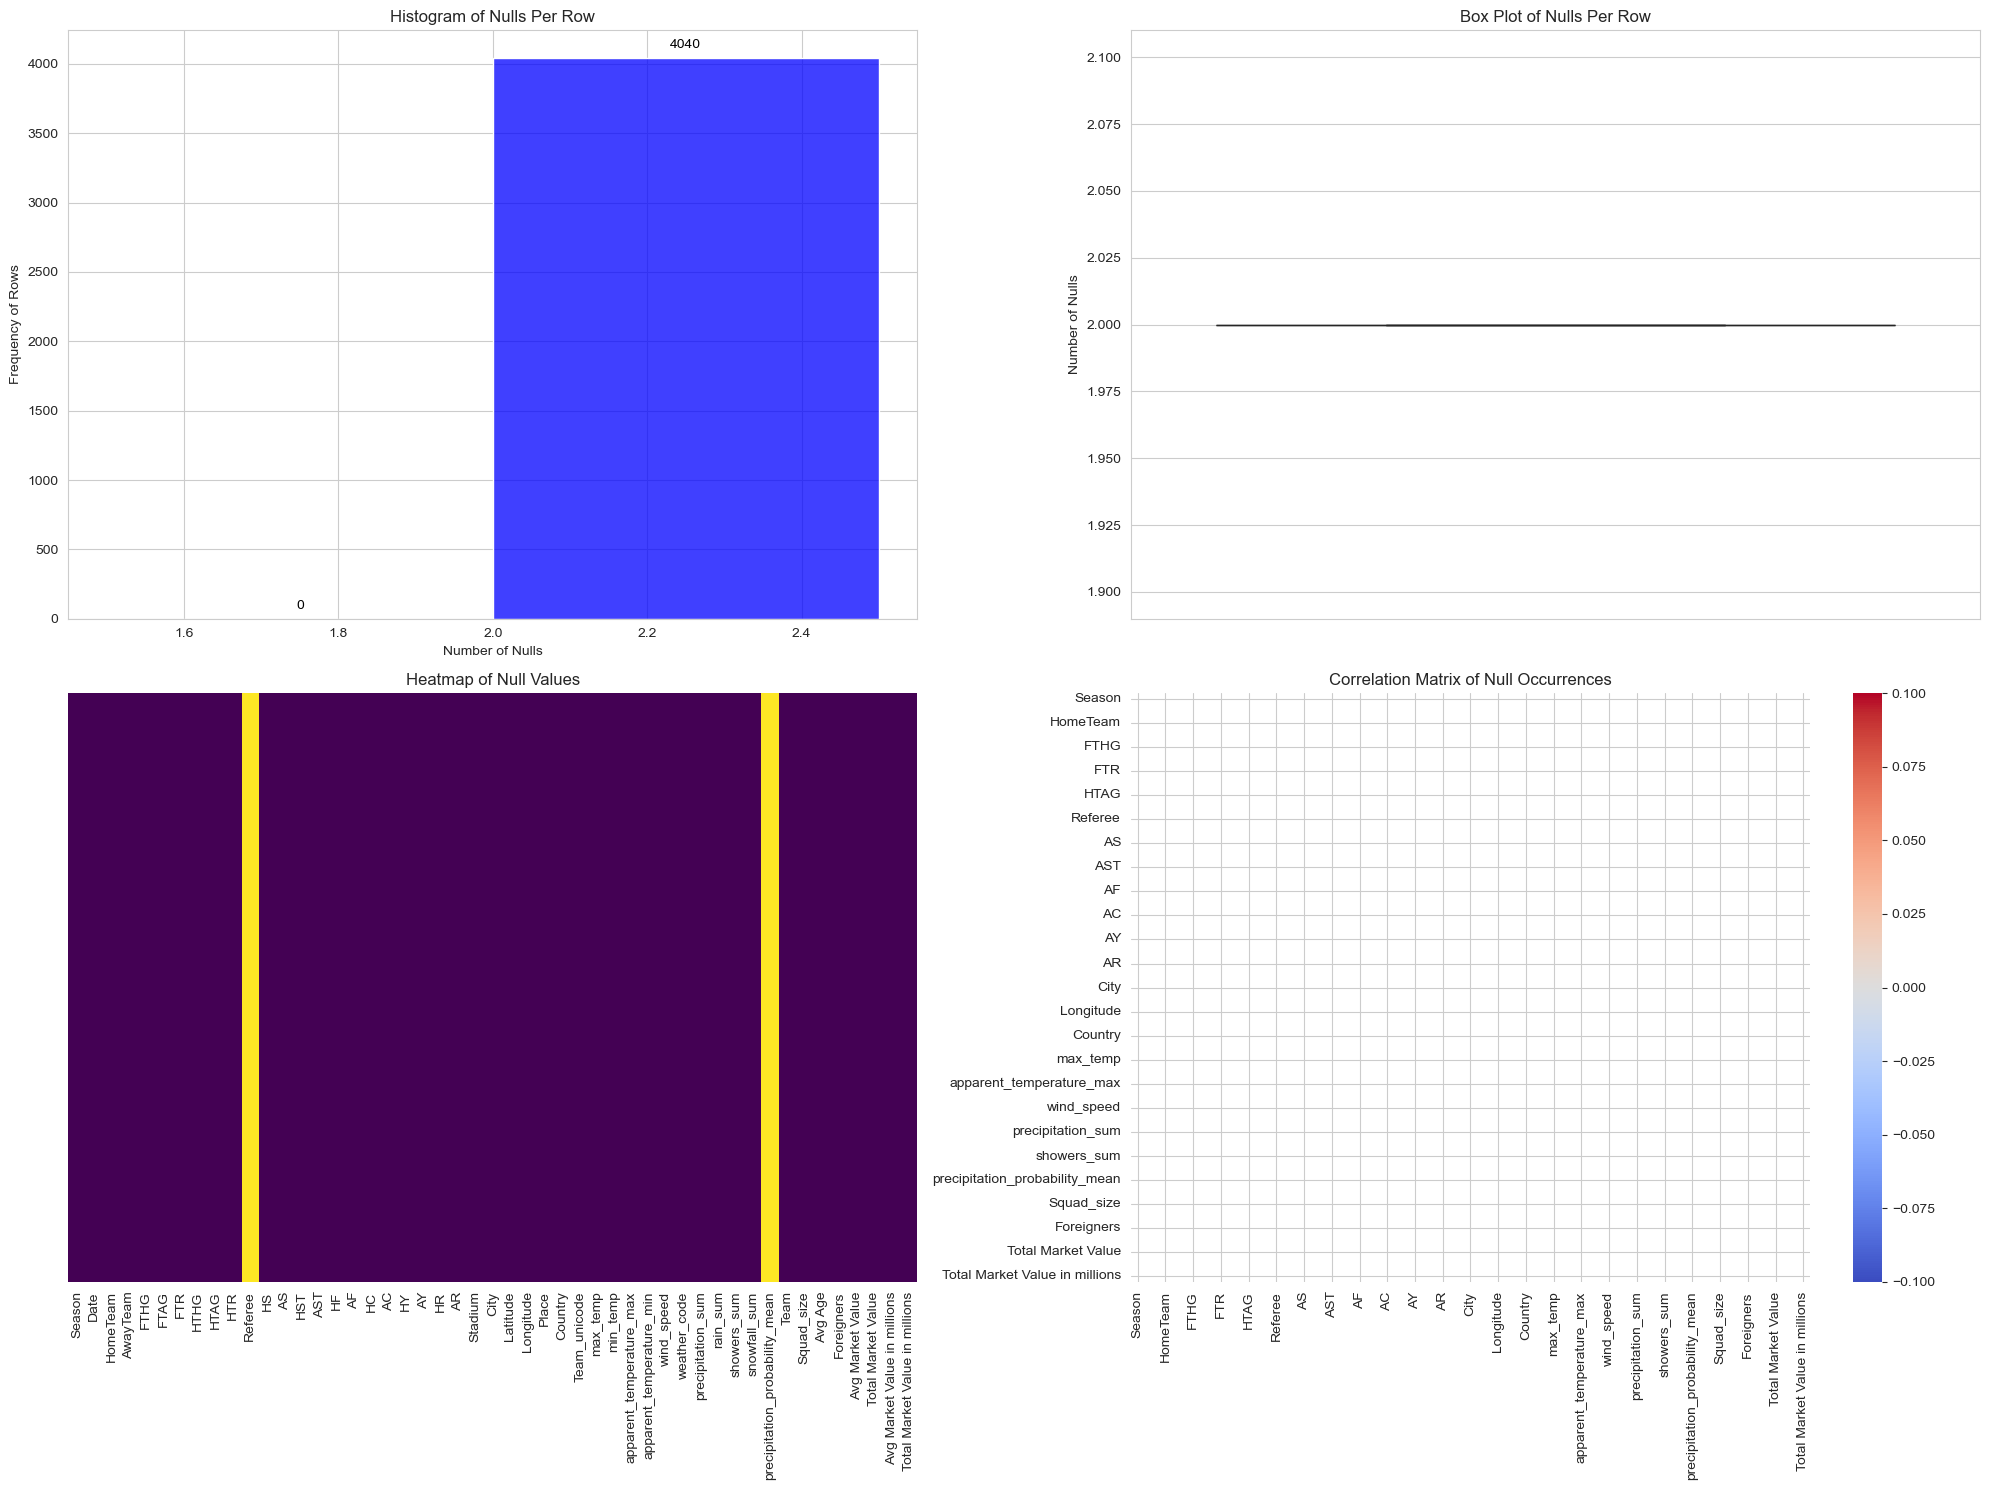


Null values by month:
         Referee  precipitation_probability_mean
Date                                            
2014-08       20                              20
2014-09       40                              40
2014-10       31                              31
2014-11       38                              38
2014-12       30                              30
...          ...                             ...
2024-10       30                              30
2024-11       32                              32
2024-12       39                              39
2025-01       30                              30
2025-02       29                              29

[107 rows x 2 columns]

Suggested handling methods:
Referee: 100.00% nulls
  Consider dropping the column
precipitation_probability_mean: 100.00% nulls
  Consider dropping the column


In [1363]:
analyze_missing_data(matches)

In [1365]:
# Removing columns - Country, showers_sum, Referee, precipitation_probability_mean considering the low number of unique values
matches.drop(['Country','showers_sum', 'Referee', 'precipitation_probability_mean'], axis =1, inplace = True)

In [1525]:
def detect_outliers_democratic(df, z_threshold=3, mad_threshold=3):
    df = df.copy()  
    num_cols = df.select_dtypes(include=['number']).columns  
    outlier_summary = {}

    print("*** Outlier Detection Summary ***\n")

    for col in num_cols:
        values = df[col].dropna()
        
        # IQR Method
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1
        iqr_lower = Q1 - 1.5 * IQR
        iqr_upper = Q3 + 1.5 * IQR
        iqr_outliers = set(values[(values < iqr_lower) | (values > iqr_upper)].index)

        # Z-Score Method
        z_scores = zscore(values)
        z_outliers = set(values[np.abs(z_scores) > z_threshold].index)

        # MAD Method
        median = np.median(values)
        mad = np.median(np.abs(values - median))
        mad_outliers = set(values[np.abs(values - median) > mad_threshold * mad].index)

        all_outliers = list(iqr_outliers) + list(z_outliers) + list(mad_outliers)
        outlier_counts = pd.Series(all_outliers).value_counts()
        final_outliers = outlier_counts[outlier_counts >= 2].index.tolist()

        print(f"{col}: {len(final_outliers)} ouliers detected")
        final_outliers_values = values[final_outliers].values
        if final_outliers:
            print(f"Outliers: {final_outliers_values}\n")

        #Creating box plot
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=values)
        plt.title(f"Boxplot of {col} with Outliers")
        plt.axhline(y=iqr_upper, color='r', linestyle='--', label='IQR Upper Bound')
        plt.axhline(y=iqr_lower, color='g', linestyle='--', label='IQR Lower Bound')
        plt.legend()
        plt.show()

        if final_outliers:
            outlier_summary[col] = final_outliers

    if not outlier_summary:
        print("No significant outliers detected.")
    else:
        for col, indices in outlier_summary.items():
            print(f"{col}: {len(indices)} outliers")

*** Outlier Detection Summary ***

FTHG: 115 ouliers detected
Outliers: [ 7  6  6  6  6  6  6  7  6  6  6  6  6  7  6  7  7  6  6  6  6  6  6  8
  6  6  7  6  7  6 10  9  7  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]



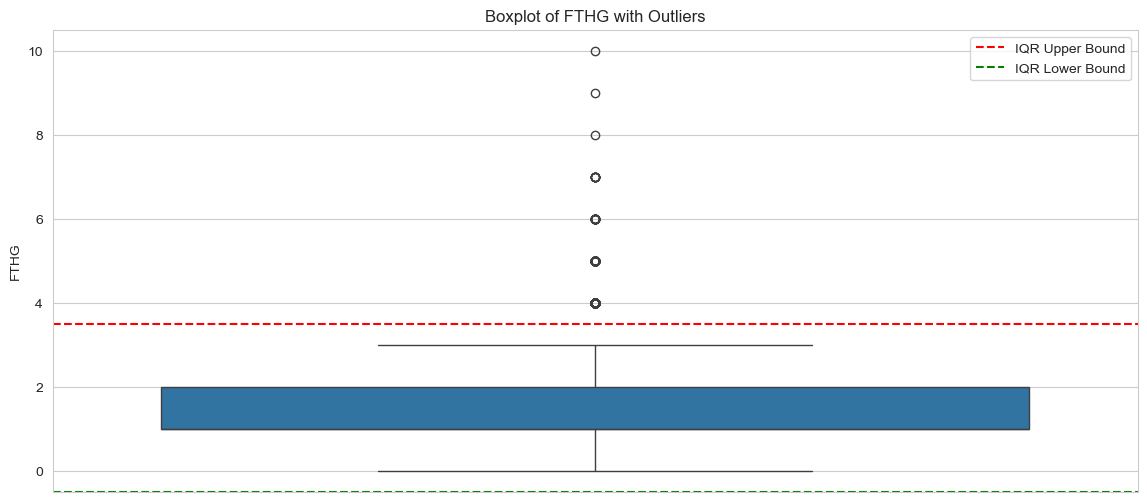

FTAG: 44 ouliers detected
Outliers: [6 6 8 6 6 8 6 6 6 7 8 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5]



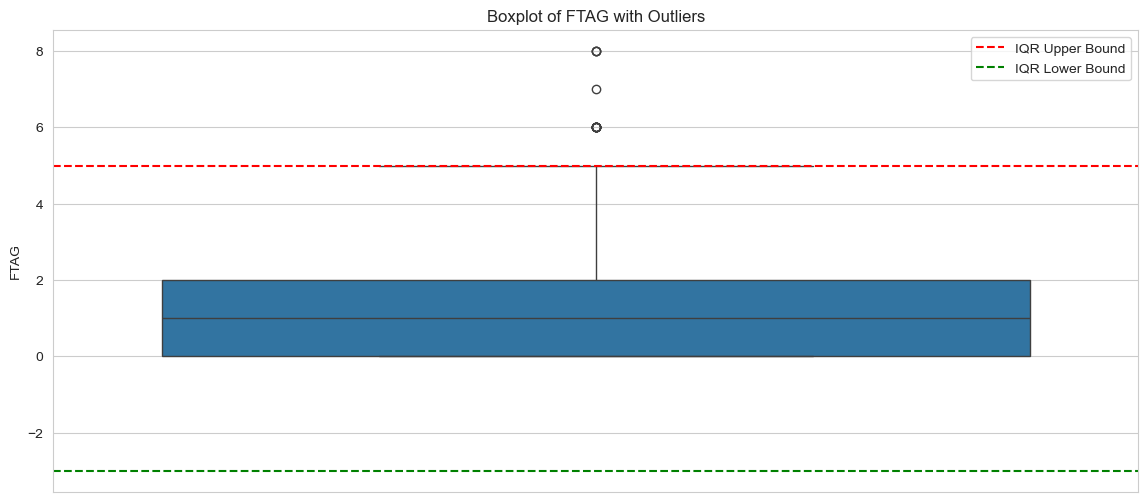

HTHG: 136 ouliers detected
Outliers: [4 4 4 4 4 4 4 4 4 5 5 4 4 4 4 4 4 5 4 4 5 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]



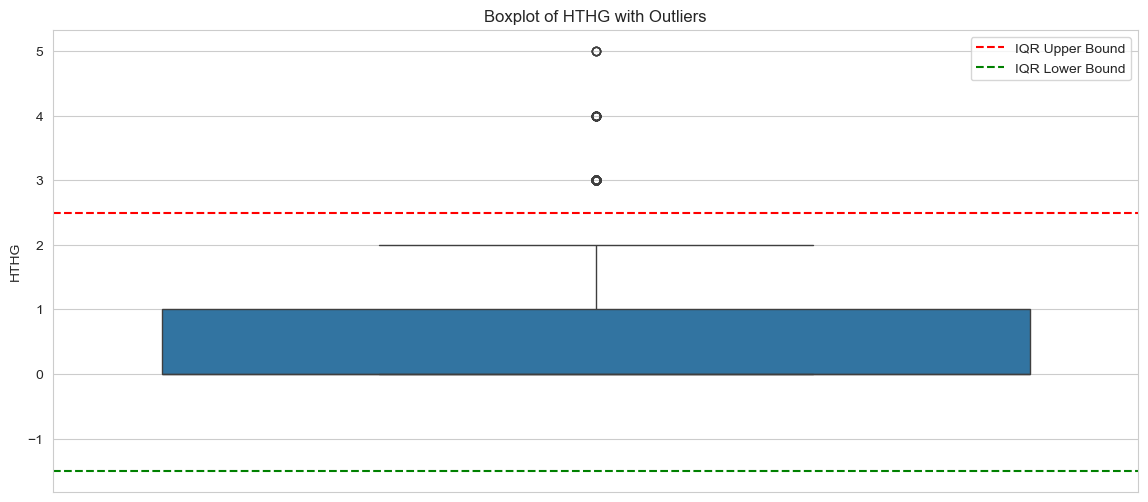

HTAG: 60 ouliers detected
Outliers: [3 3 3 3 3 3 4 3 4 5 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3]



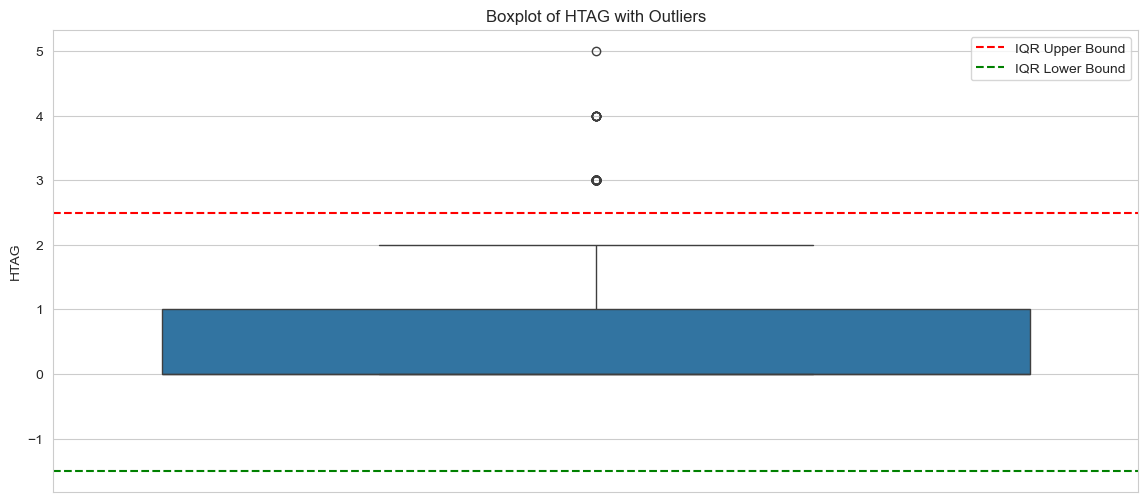

HS: 69 ouliers detected
Outliers: [32 29 28 32 30 28 28 29 28 28 34 29 28 34 28 28 28 29 29 31 36 30 31 28
 30 30 31 30 31 35 29 29 28 31 30 27 27 26 27 26 27 27 27 27 26 27 27 26
 27 27 27 26 26 26 26 27 26 27 27 26 26 27 26 27 27 26 26 27 27]



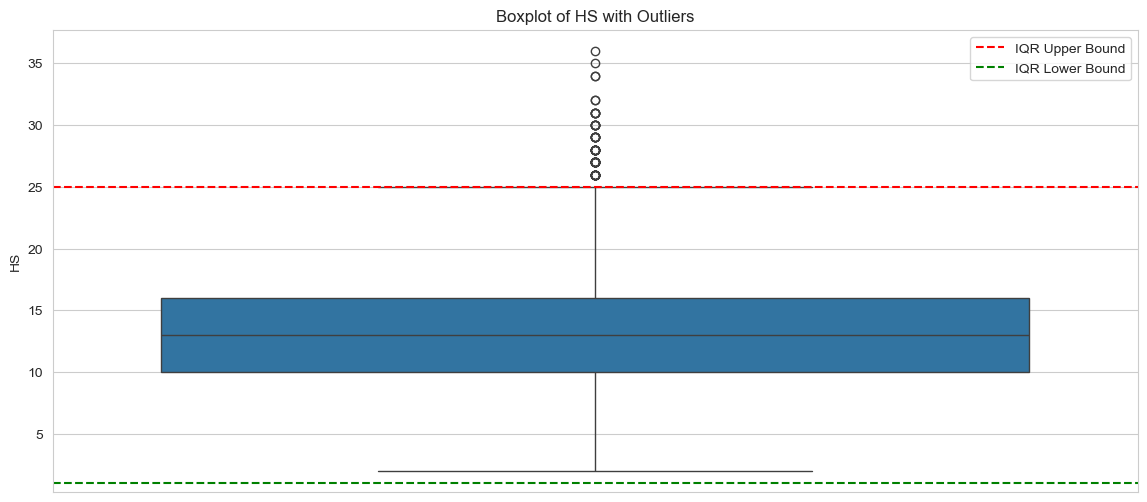

AS: 31 ouliers detected
Outliers: [24 28 25 24 27 25 24 24 28 24 24 29 27 25 25 27 26 24 35 27 29 23 23 23
 23 23 23 23 23 23 23]



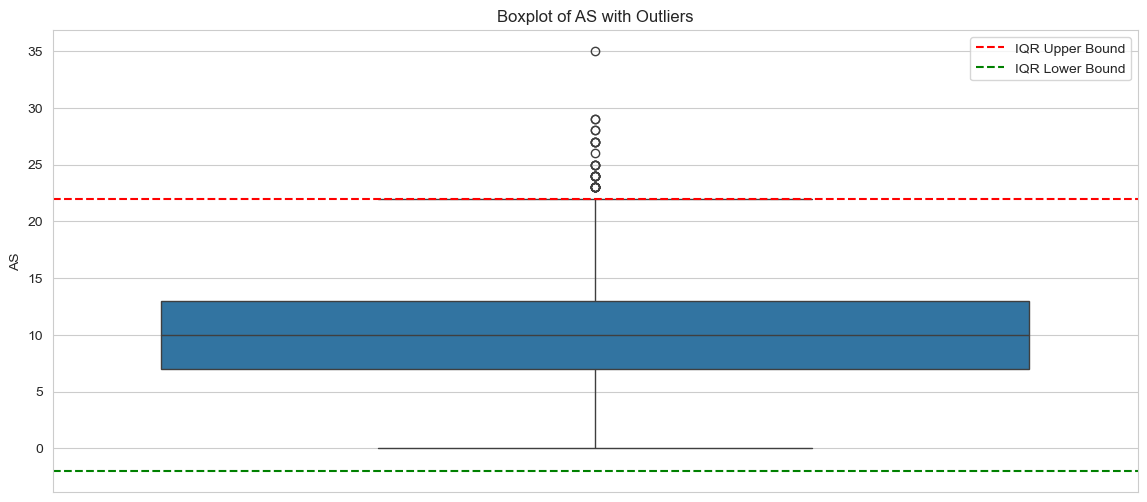

HST: 104 ouliers detected
Outliers: [17 13 14 13 13 13 14 13 13 13 13 13 14 13 14 13 13 16 13 13 13 17 13 15
 13 15 13 14 14 12 12 11 12 11 12 11 12 12 11 11 12 11 11 12 11 11 11 11
 11 11 12 12 11 11 11 11 11 12 11 11 12 11 12 11 12 12 12 12 12 11 11 12
 12 11 11 11 11 11 11 11 12 11 11 11 12 12 11 11 12 12 11 11 12 11 12 11
 11 11 11 12 11 11 11 11]



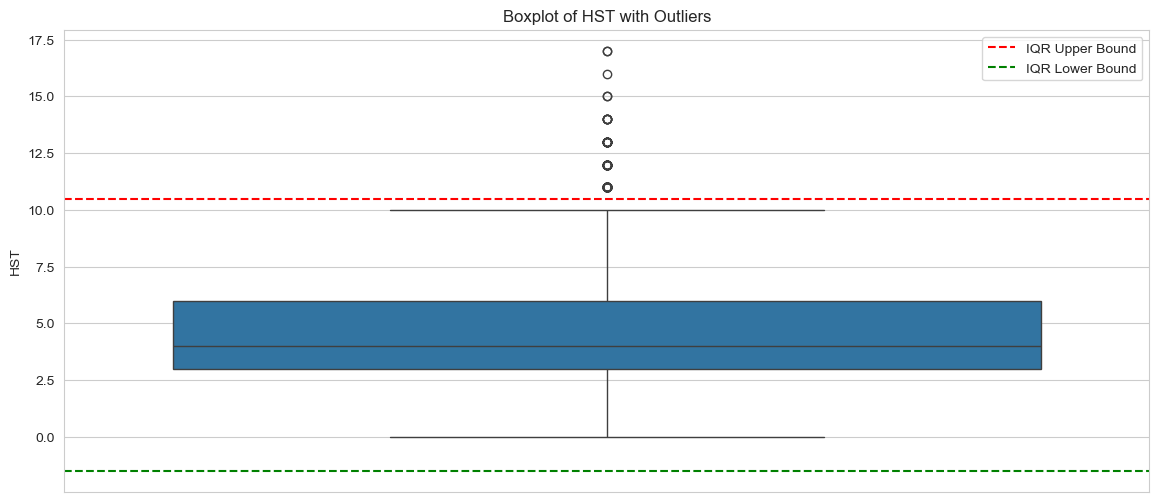

AST: 46 ouliers detected
Outliers: [11 13 11 12 11 11 11 11 12 11 11 11 15 11 11 11 11 11 11 13 12 13 11 11
 11 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]



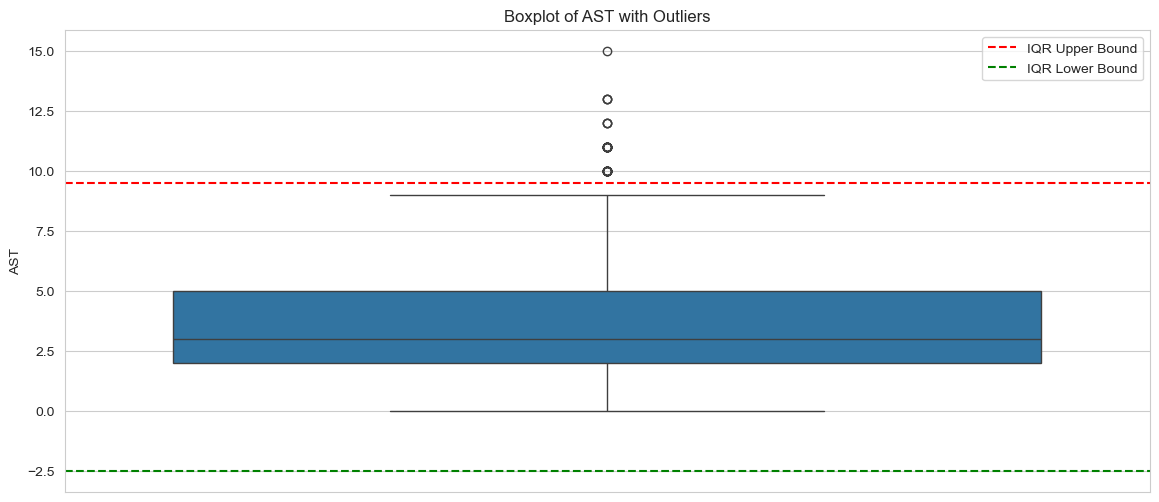

HF: 61 ouliers detected
Outliers: [33 28 26 27 29 29 28 28 26 28 26 28 26  1 26 28  1 26 26 26 28 26 29 26
 24  3 25 25 25 25  3 25 25 24  2 24 24 24 25  3 24 24 24 24 25 25 25 24
 24  3 25 24 25 25  3 25 24 25 25 24  3]



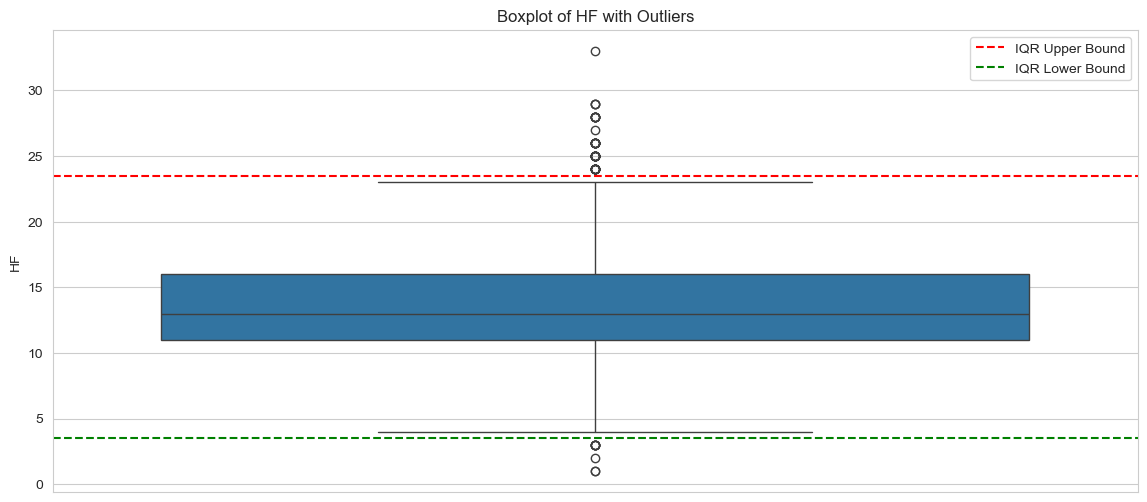

AF: 31 ouliers detected
Outliers: [27 27 29 27  0 29 27 29 28 30 30 27 31 28 27 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26]



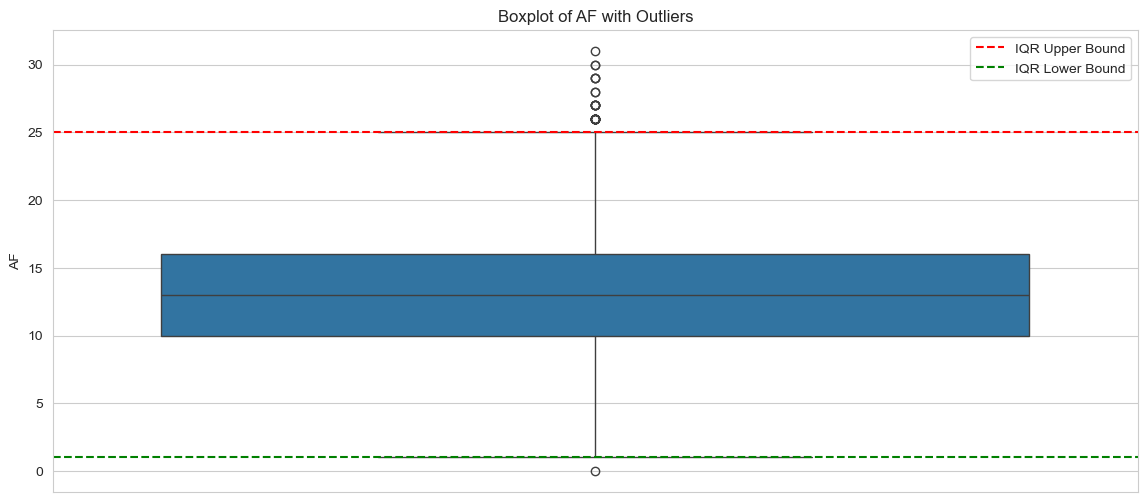

HC: 37 ouliers detected
Outliers: [14 14 17 15 14 14 16 19 14 15 14 14 15 14 17 20 14 16 14 14 16 20 15 15
 15 15 14 14 17 14 14 14 17 15 16 14 14]



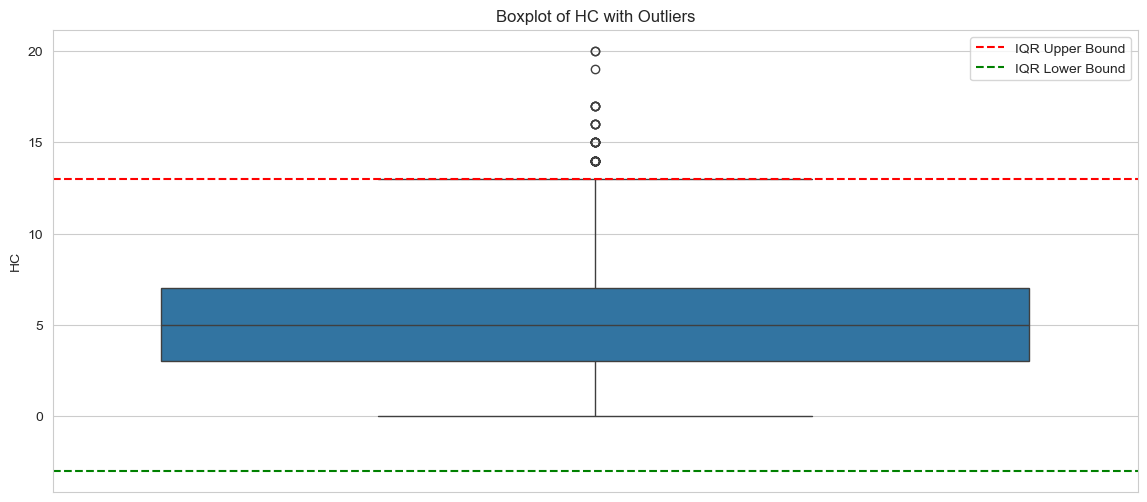

AC: 33 ouliers detected
Outliers: [14 13 13 13 15 17 13 14 14 13 13 15 13 13 14 13 13 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12]



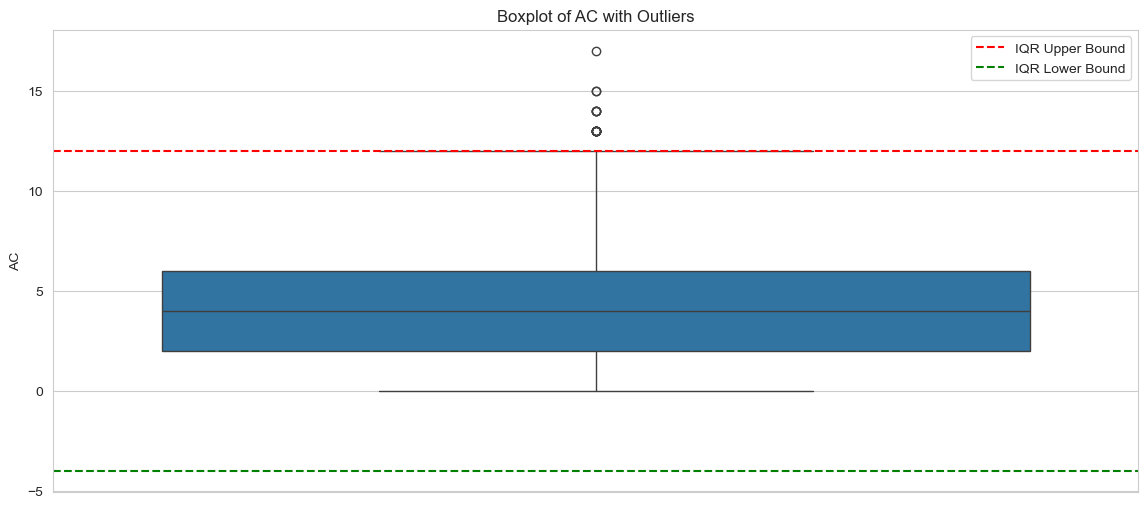

HY: 49 ouliers detected
Outliers: [8 8 8 8 8 8 8 9 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7]



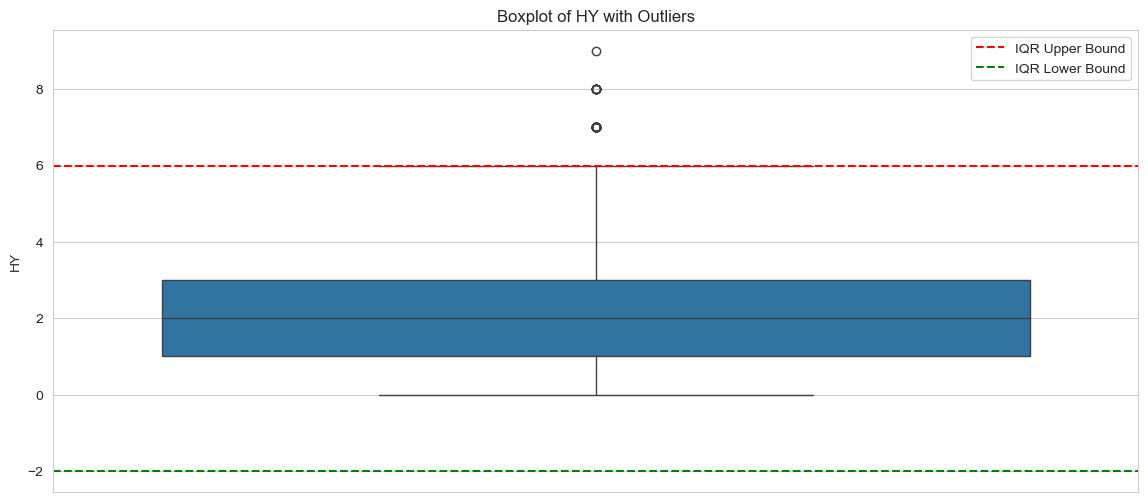

AY: 11 ouliers detected
Outliers: [8 9 8 9 8 8 8 8 8 8 8]



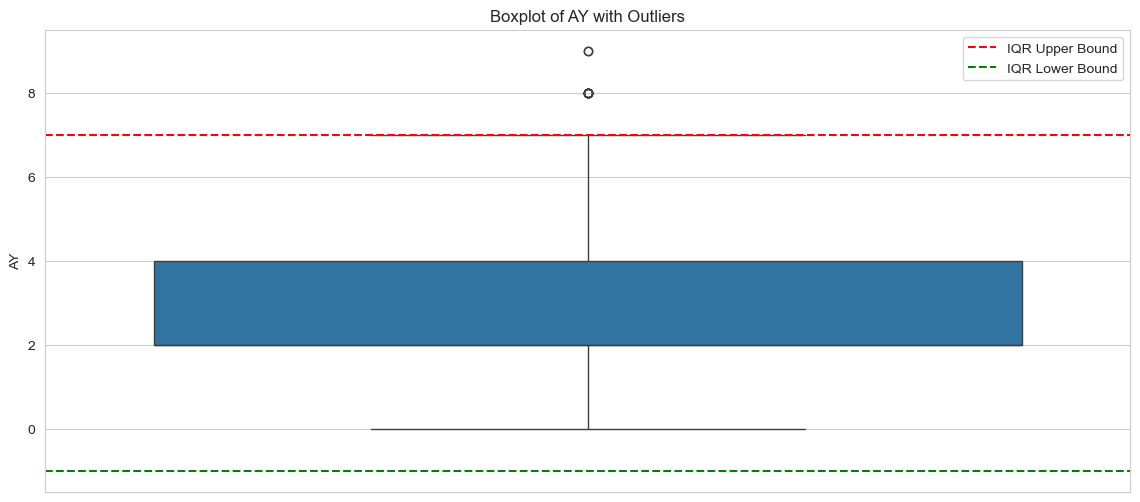

HR: 428 ouliers detected
Outliers: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]



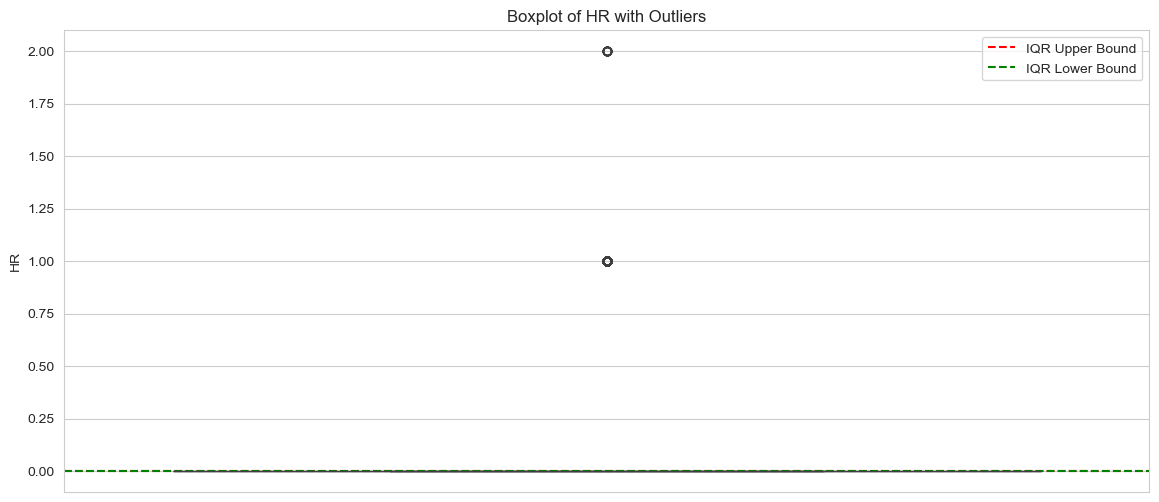

AR: 490 ouliers detected
Outliers: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

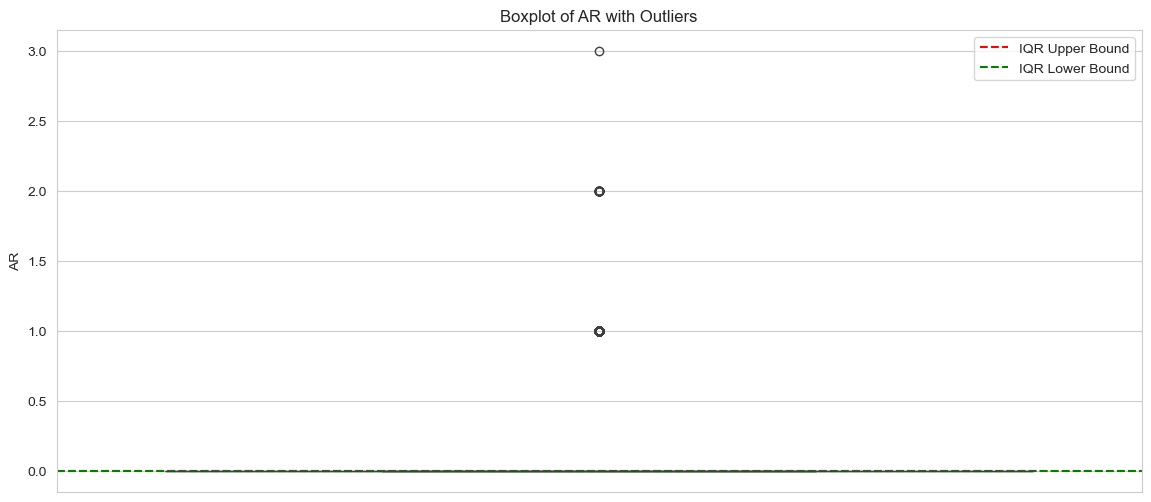

Latitude: 88 ouliers detected
Outliers: [27.958611 27.958611 27.958611 27.92948  27.958611 27.92948  27.958611
 27.958611 27.958611 27.958611 27.958611 27.92948  27.958611 27.958611
 27.958611 27.92948  27.958611 27.958611 27.92948  27.958611 27.958611
 27.958611 27.958611 27.92948  27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.92948  27.958611 27.958611 27.958611
 27.958611 27.958611 27.92948  27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611 27.92948  27.92948  27.958611
 27.958611 27.958611 27.92948  27.958611 27.92948  27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611 27.958611
 27.958611 27.958611 27.958611 27.958611]



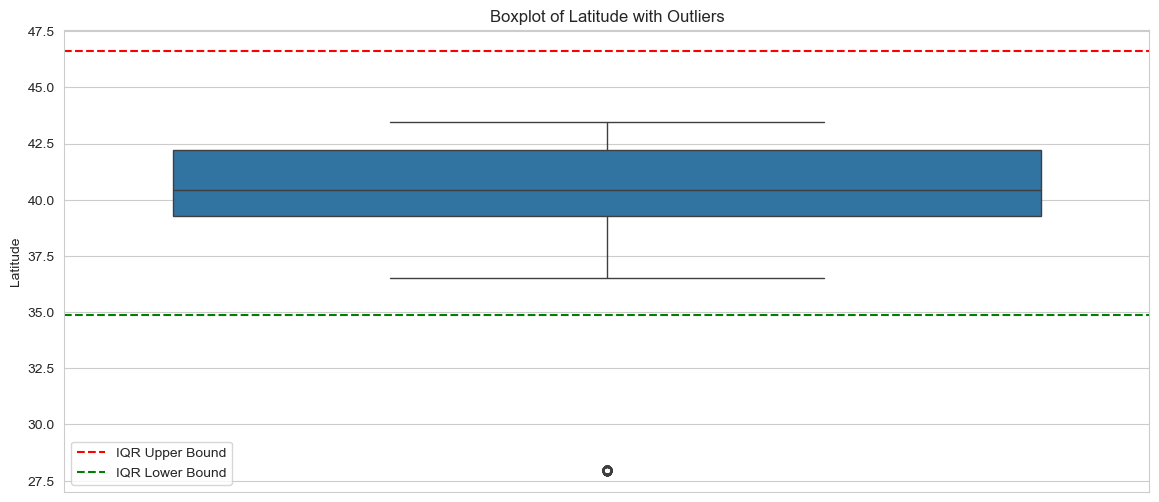

Longitude: 88 ouliers detected
Outliers: [-15.5925   -15.5925   -15.5925   -15.549978 -15.5925   -15.549978
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.549978
 -15.5925   -15.5925   -15.5925   -15.549978 -15.5925   -15.5925
 -15.549978 -15.5925   -15.5925   -15.5925   -15.5925   -15.549978
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.549978 -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.549978 -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.549978 -15.549978 -15.5925   -15.5925   -15.5925
 -15.549978 -15.5925   -15.549978 -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925   -15.5925   -15.5925
 -15.5925   -15.5925   -15.5925   -15.5925 

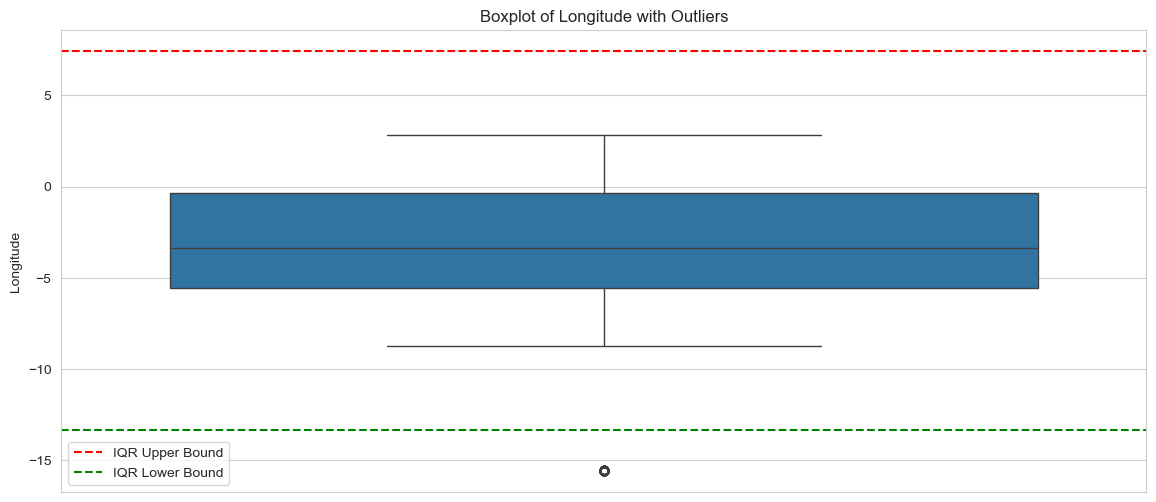

max_temp: 20 ouliers detected
Outliers: [40.3 41.9 40.7 45.  42.2 42.3 44.2 38.2 39.1 38.3 38.  38.8 38.9 39.8
 39.1 39.  39.3 38.6 39.8 38.8]



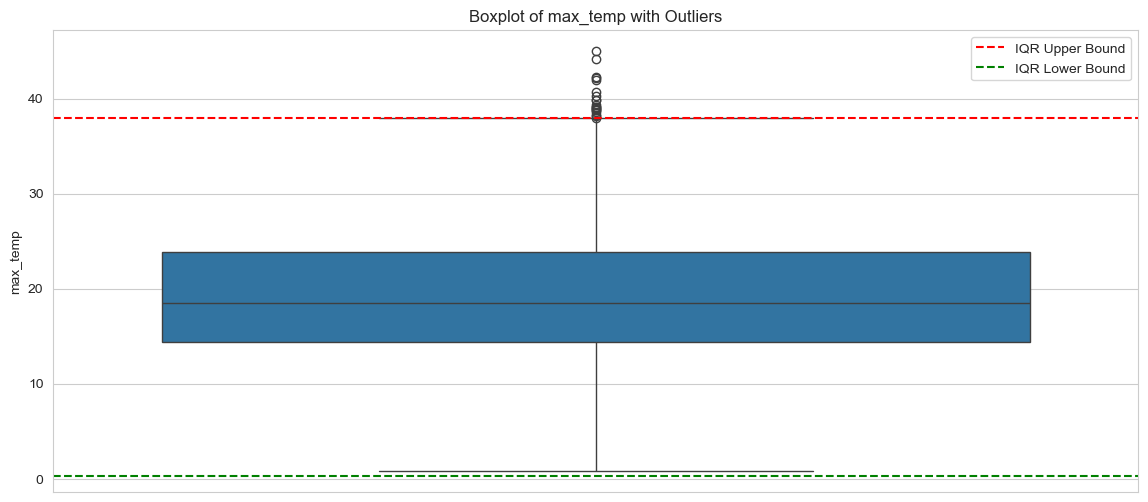

min_temp: 6 ouliers detected
Outliers: [-8.3 28.6 26.5 26.3 -6.6 26.6]



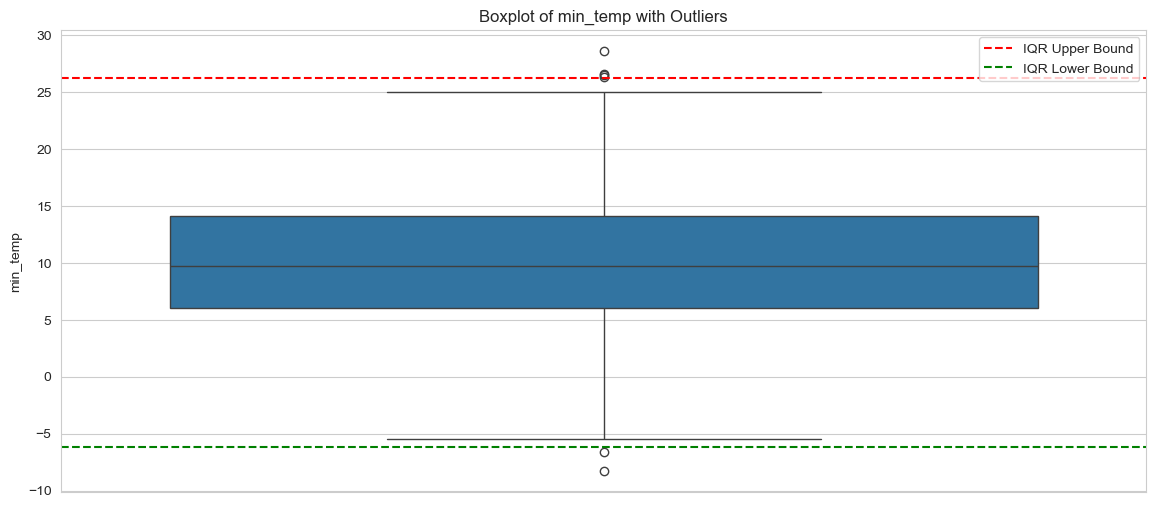

apparent_temperature_max: 7 ouliers detected
Outliers: [43.  43.4 43.2 43.2 43.6 41.2 42. ]



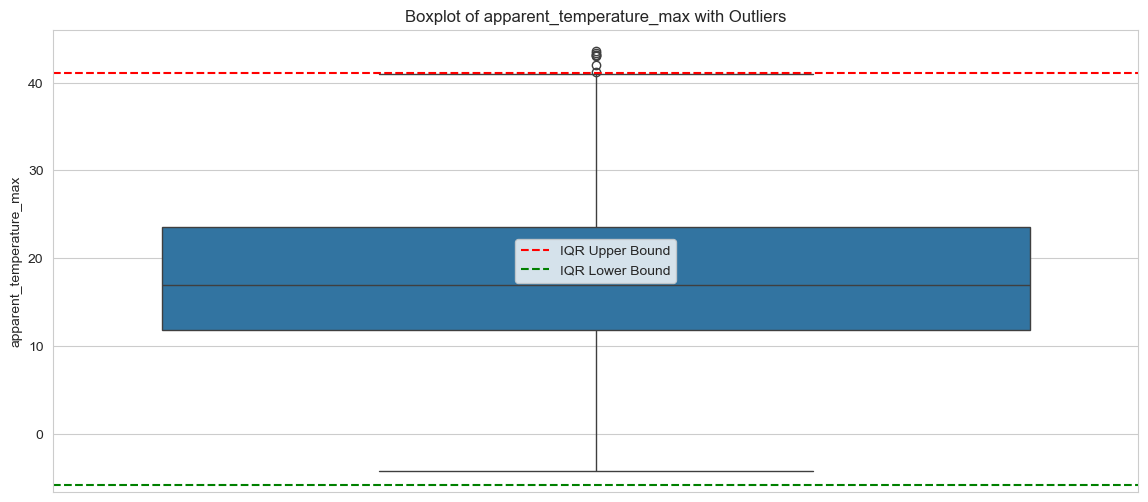

apparent_temperature_min: 1 ouliers detected
Outliers: [-13.]



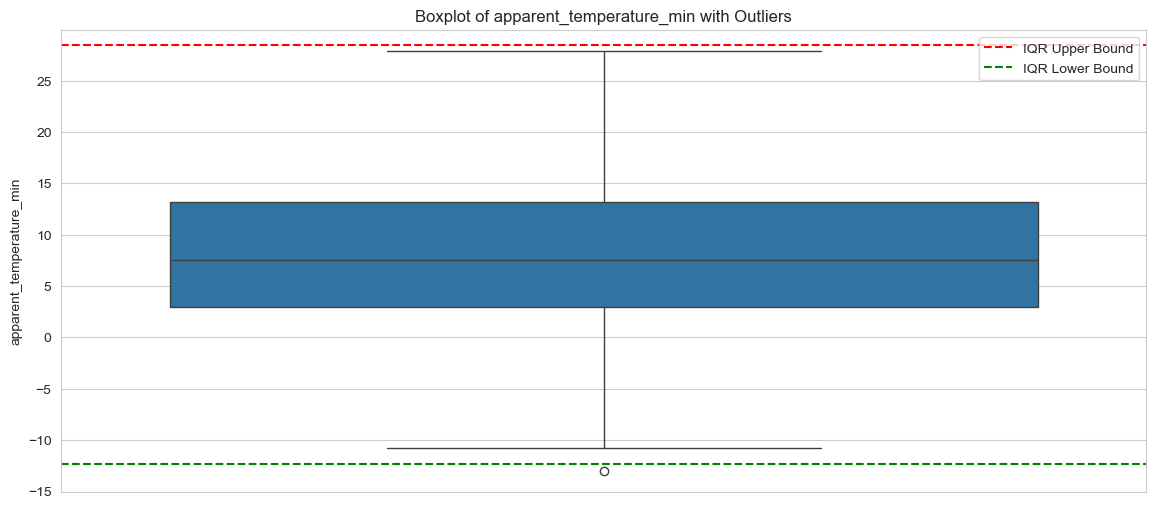

wind_speed: 111 ouliers detected
Outliers: [56.4 47.5 38.3 39.7 43.9 44.3 38.7 40.9 42.9 39.  43.4 37.9 40.5 42.
 39.1 41.6 39.1 41.2 38.  42.8 40.5 38.9 40.9 42.  42.  40.9 44.2 40.3
 39.5 38.8 43.3 48.4 38.9 44.  40.1 40.7 39.3 39.8 41.8 44.  46.7 39.5
 38.  39.1 41.5 52.9 41.8 45.8 42.1 42.4 45.9 35.2 34.1 34.9 36.9 36.7
 34.4 35.9 34.2 37.  35.8 35.6 33.9 36.8 34.8 34.7 36.2 35.6 35.5 37.2
 34.  37.1 35.2 34.5 35.1 34.7 35.5 36.4 37.2 35.  34.9 36.5 36.8 36.3
 37.4 37.2 36.3 34.  35.9 34.4 37.  34.  34.6 36.9 34.8 34.  36.2 34.2
 35.9 35.1 35.4 35.6 33.9 36.4 35.1 34.6 35.8 36.9 35.8 33.9 36. ]



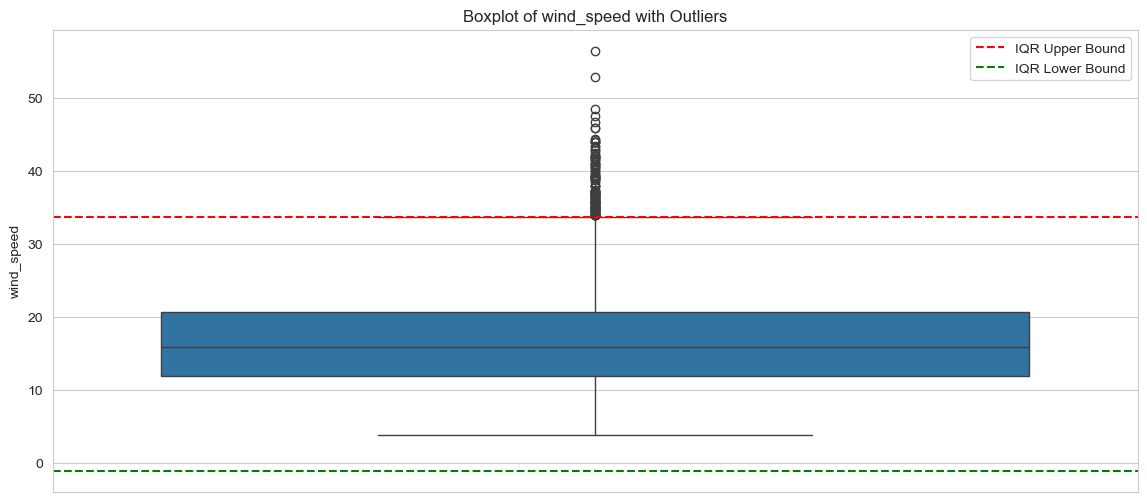

weather_code: 0 ouliers detected


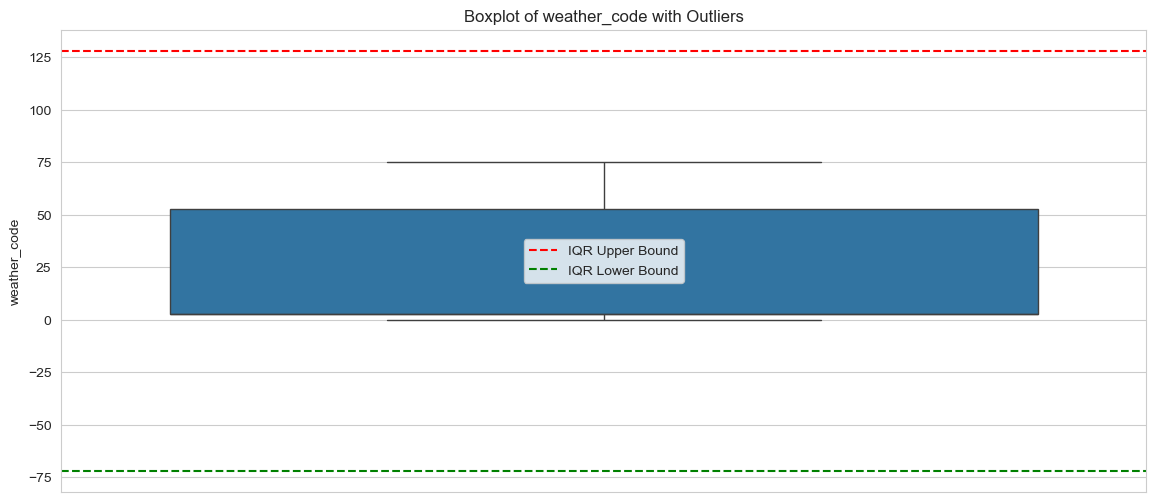

precipitation_sum: 690 ouliers detected
Outliers: [22.6 28.5 40.2 31.1 23.  22.5 37.1 27.2 42.  83.5 25.  21.8 22.1 27.6
 39.8 40.6 41.4 31.3 20.7 32.3 25.9 24.6 26.5 21.4 22.5 20.3 20.3 21.8
 38.  59.8 23.  31.9 21.4 27.6 27.9 29.9 32.6 28.  21.  22.4 24.1 21.9
 25.  20.4 40.  29.8 48.8 23.1 22.3 21.2 24.6 33.6 24.9 23.  23.6 31.2
 47.6 31.3 27.3 21.6 20.6 28.4 29.3 32.  31.2 58.1 25.4 20.9 20.8 26.9
 27.2 21.9 37.9 21.8 27.9 22.1 46.1 43.7 22.8 31.3 21.3 24.5 56.8 20.8
 35.5 39.7 28.2 24.4 42.1 71.6 24.1 25.5 37.6 20.2 19.9 20.6 29.8 22.5
 19.9 24.4 32.6 33.4 24.6 22.4 12.8  7.8  4.9  9.2  6.8 10.9  3.5  5.2
  4.   5.2 19.5  3.3  5.4  4.  16.2 18.9  8.5 12.6  3.6  3.8  8.5 14.2
  6.6  8.4 12.   9.7  3.3  3.7  6.2 18.3  5.8  3.8  5.1 12.4 18.3  8.2
  3.5 19.3 14.5  5.   3.7  7.2 13.7 18.5  4.5 13.1  6.5  3.8  9.9 10.6
  3.5 15.9  5.5  4.3  3.8  9.7  5.3  3.9  8.   8.4  9.2  9.4  7.6 17.5
  5.8  4.8 11.9  4.2 12.  18.7  5.3  9.   5.3 14.5  5.8  5.1  8.5  4.6
  5.7 12.9 13.1  6.1 11.2  

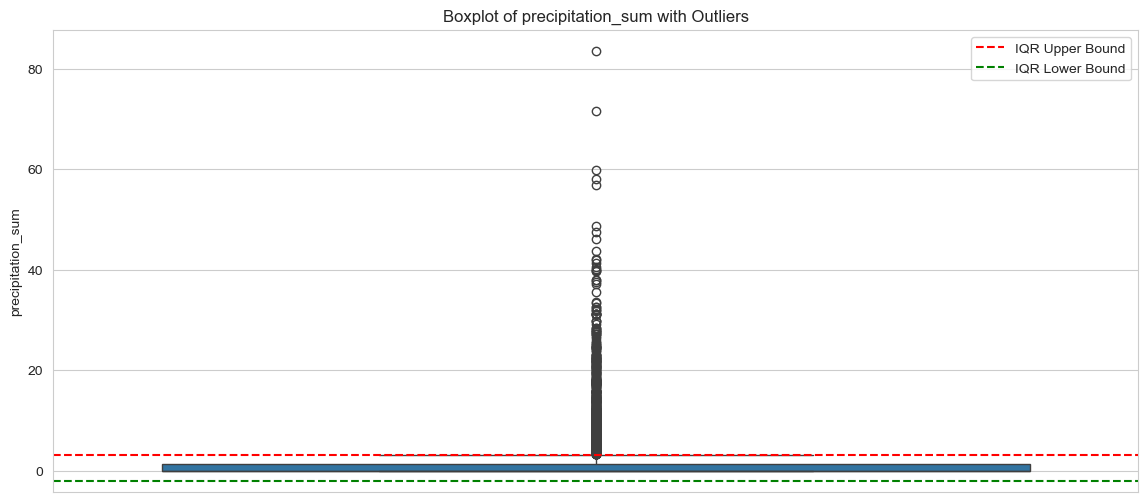

rain_sum: 686 ouliers detected
Outliers: [19.9 20.6 40.2 26.5 24.6 31.1 37.9 28.  31.2 22.5 47.6 28.4 27.2 24.4
 22.8 22.5 22.5 23.6 22.4 32.6 24.1 20.2 42.  21.9 46.1 39.  21.9 20.8
 58.1 20.3 32.  22.6 25.4 32.3 31.3 20.7 20.9 31.3 31.2 38.  27.9 21.4
 27.6 26.9 31.4 27.2 23.  23.  24.4 59.8 20.3 21.8 20.8 29.3 83.5 48.8
 24.1 39.8 42.1 40.6 28.5 23.1 22.3 29.9 35.5 20.8 21.2 24.5 32.6 31.3
 27.9 27.6 22.4 22.1 29.8 33.4 24.9 24.5 23.  33.6 27.3 21.8 37.6 39.7
 37.1 25.  25.  21.  20.4 21.3 56.8 20.6 21.6 41.4 22.1 28.2 24.4 40.
 20.7 29.8 71.6 25.5 19.9 10.7  4.7  6.6  3.5  3.6  7.6 12.1 12.6 18.9
 10.9  6.6  5.8  3.3  9.7 12.5  3.7  6.2 18.3  3.8 18.3  8.2 12.  14.5
  5.   3.7 13.7 18.5  4.5 13.1  6.5 19.3  8.4 14.2  7.2  9.2  7.8  6.8
  5.4  4.3  8.   6.9  9.4 11.2  8.9  7.1  6.8 17.7  5.2  4.2  5.8  5.5
  3.6  3.4  8.8  5.5 13.1  4.3  8.5 16.2  4.  12.4  9.4  3.8  8.5  4.9
  9.9  5.1  3.5  3.3  3.8  3.5  5.2  5.2 19.5  4.   9.4  7.6  5.8  5.
  8.4  7.1  4.7  9.   3.8  6.1  9.6 17

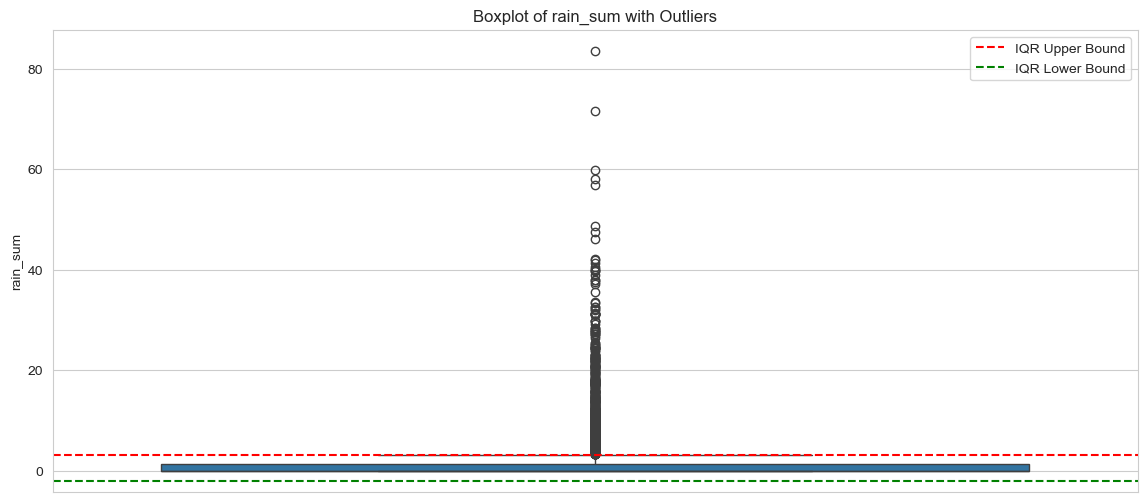

snowfall_sum: 52 ouliers detected
Outliers: [5.81 3.5  0.7  2.38 2.03 0.77 2.17 5.6  1.68 1.05 5.53 3.29 1.05 0.91
 1.33 0.7  4.34 0.98 0.07 0.14 0.07 0.21 0.56 0.14 0.07 0.07 0.49 0.07
 0.14 0.14 0.35 0.07 0.35 0.42 0.28 0.28 0.21 0.14 0.21 0.21 0.14 0.07
 0.07 0.07 0.07 0.42 0.49 0.14 0.35 0.49 0.42 0.07]



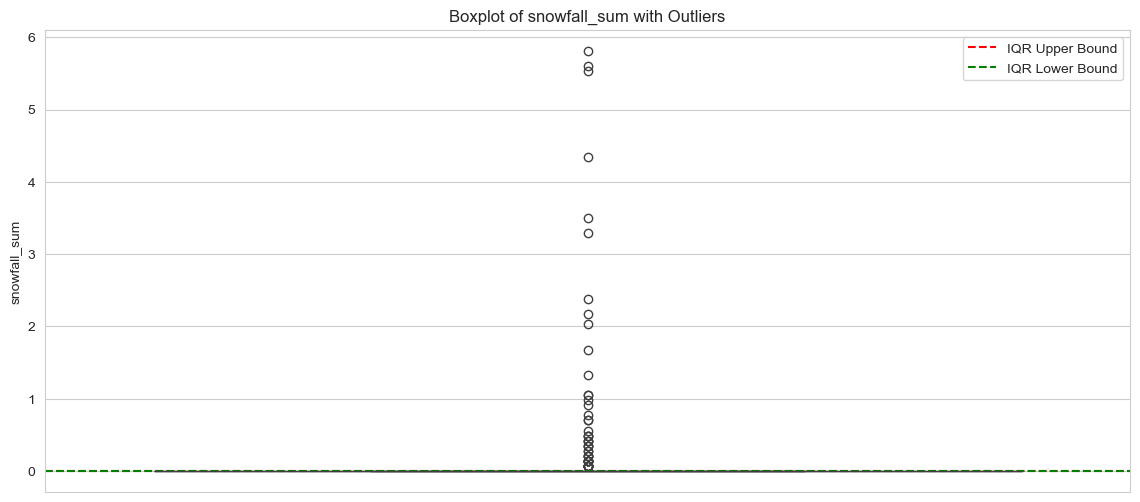

Squad_size: 19 ouliers detected
Outliers: [49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49]



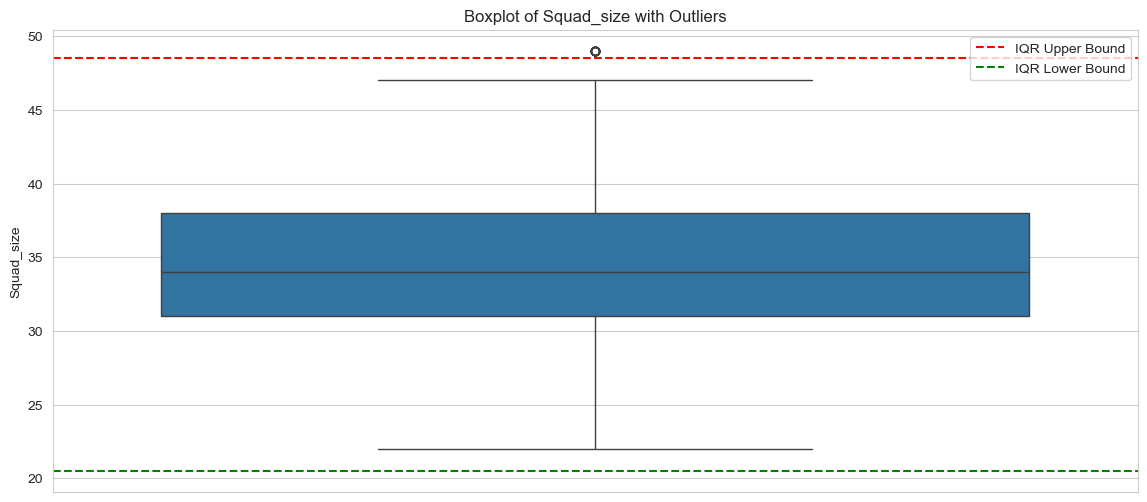

Avg Age: 11 ouliers detected
Outliers: [29.8 29.8 29.8 29.8 29.8 29.8 29.8 29.8 29.8 29.8 29.8]



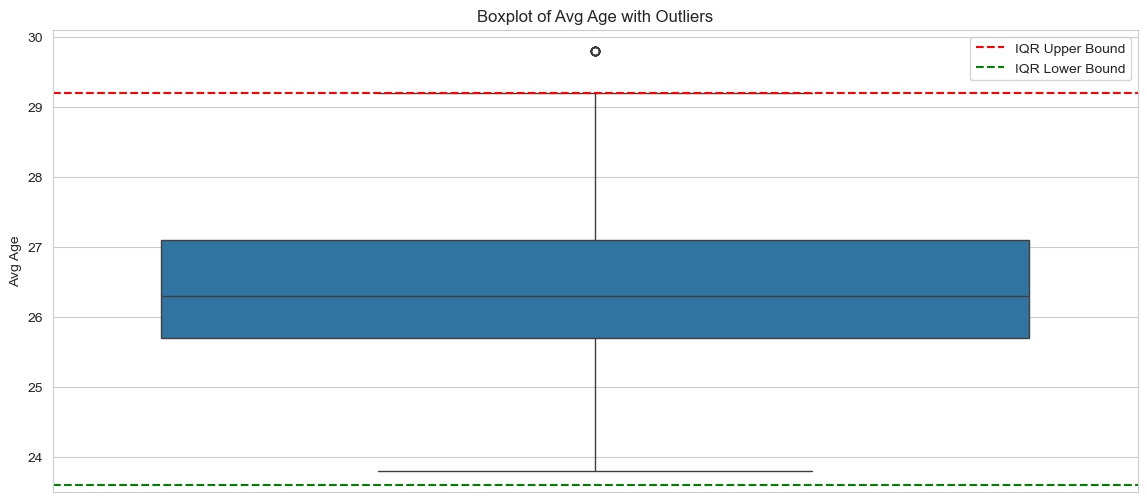

Foreigners: 0 ouliers detected


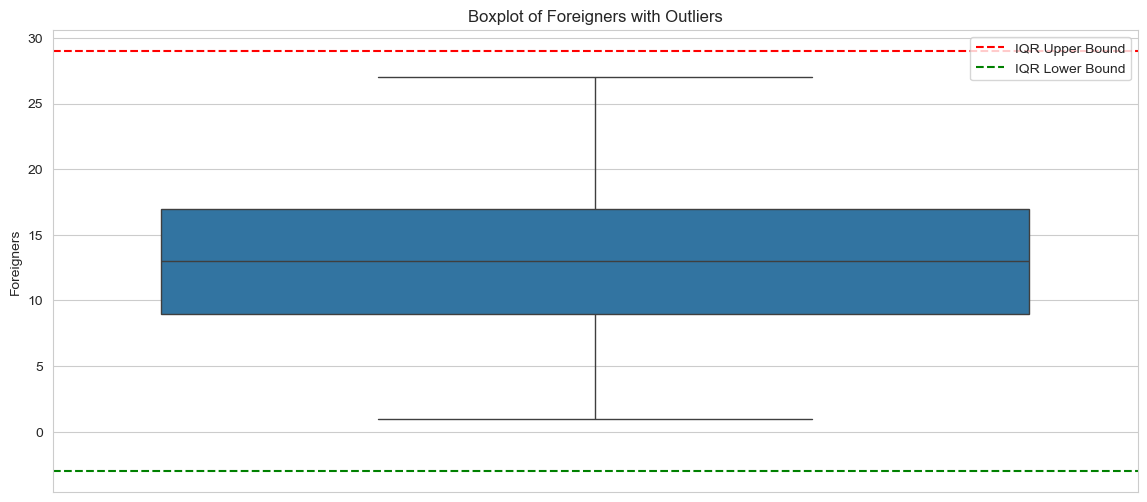

Avg Market Value in millions: 484 ouliers detected
Outliers: [34.19 34.19 32.01 39.02 53.61 32.01 34.19 39.02 53.61 34.19 53.61 34.19
 53.61 34.19 53.61 39.02 34.19 53.61 39.02 53.61 32.01 32.01 39.02 32.01
 32.01 32.01 32.01 32.01 34.19 32.01 32.01 34.19 32.01 32.01 34.19 32.01
 32.01 32.01 32.01 32.01 34.19 34.19 34.19 39.02 32.01 39.02 53.61 39.02
 39.02 53.61 34.19 34.19 34.19 39.02 34.19 53.61 53.61 34.19 39.02 34.19
 24.11 25.65 29.85 24.11 29.85 20.41 24.11 29.85 19.75 19.75 29.85 19.75
 20.41 19.75 19.75 26.21 29.72 24.11 24.89 29.85 26.21 24.11 20.41 24.89
 25.65 29.72 24.11 25.65 19.75 25.65 29.85 24.11 29.85 19.75 25.65 19.75
 25.65 25.65 19.75 20.41 29.85 29.85 19.75 25.65 29.85 20.41 29.85 19.75
 20.41 19.75 29.85 20.41 29.85 25.65 19.75 25.65 19.75 24.89 20.41 29.85
 20.41 19.75 24.11 20.41 19.75 25.65 29.85 19.75 29.85 24.11 29.85 19.75
 25.65 19.75 29.85 20.41 24.11 21.82 29.72 29.72 21.6  27.69 21.6  21.82
 24.89 16.84 21.6  29.72 26.21 16.84 24.89 21.6  29.72 26.21 16

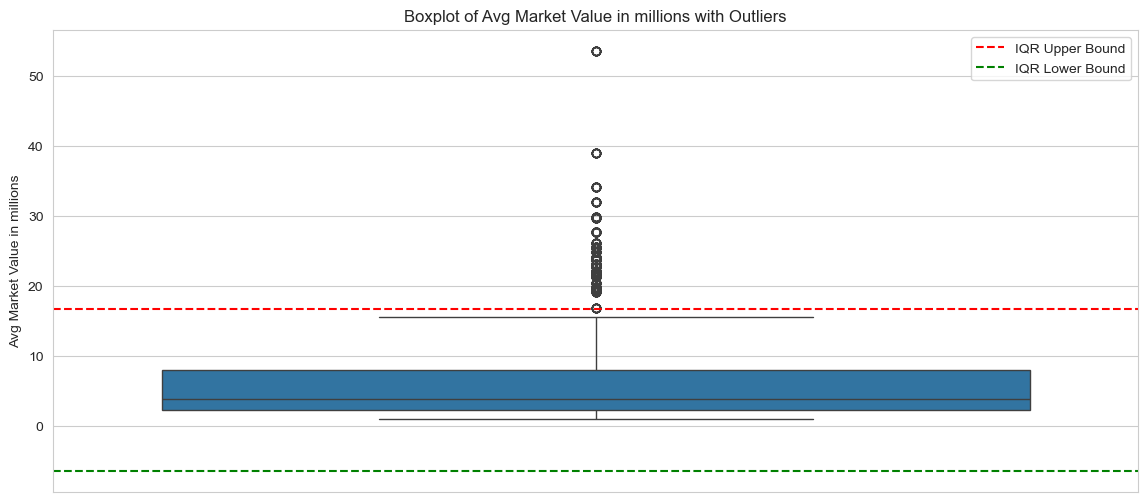

Total Market Value in millions: 497 ouliers detected
Outliers: [1380.   1230.   1090.   1160.   1160.   1090.   1380.   1160.   1380.
 1160.   1380.   1380.   1090.   1160.   1380.   1160.   1380.   1160.
 1090.   1380.   1160.   1230.   1090.   1160.   1230.   1380.   1380.
 1160.   1090.   1380.   1380.   1090.   1090.   1090.   1380.   1090.
 1380.   1090.   1380.   1090.   1090.   1380.   1090.   1160.   1090.
 1380.   1160.   1380.   1160.   1380.   1160.   1160.   1090.   1230.
 1090.   1090.   1230.   1160.   1230.   1160.   1230.   1230.   1160.
 1230.   1160.   1090.   1230.   1230.    923.45  802.9   836.8   711.15
  923.45  765.3   711.15  923.45  836.8   955.35  711.15  802.9   923.45
  836.8   955.35  765.3   836.8   955.35  955.35  955.35  711.15  916.2
  765.3   802.9   765.3   836.8   923.45  802.9   711.15  765.3   916.2
  955.35  765.3   711.15  923.45  923.45  923.45  802.9   836.8   923.45
  836.8   955.35  836.8   711.15  955.35  955.35  711.15  836.8   955.35
  83

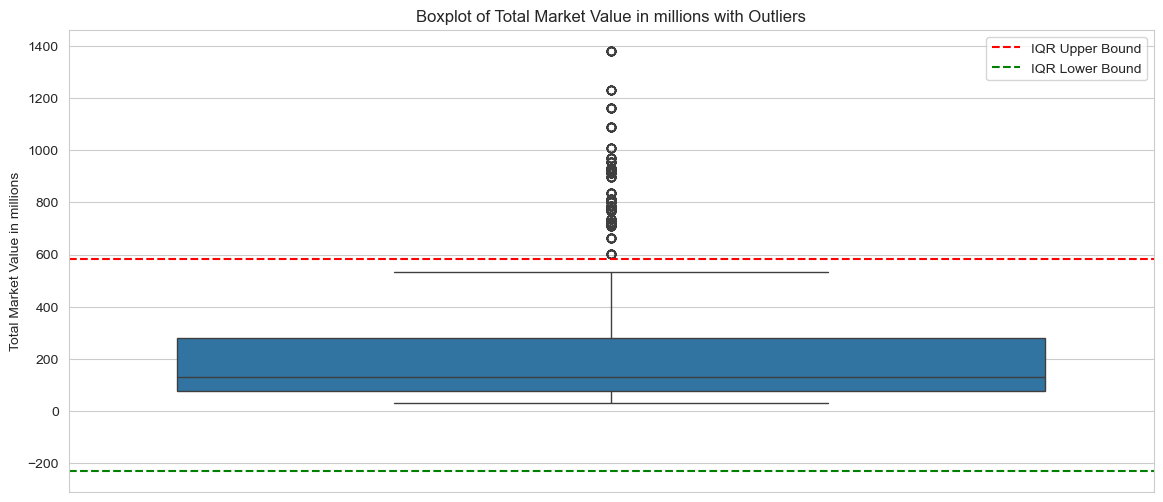

TotalGoals: 34 ouliers detected
Outliers: [ 9  9 10  9 12 10 10 10 10  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8]



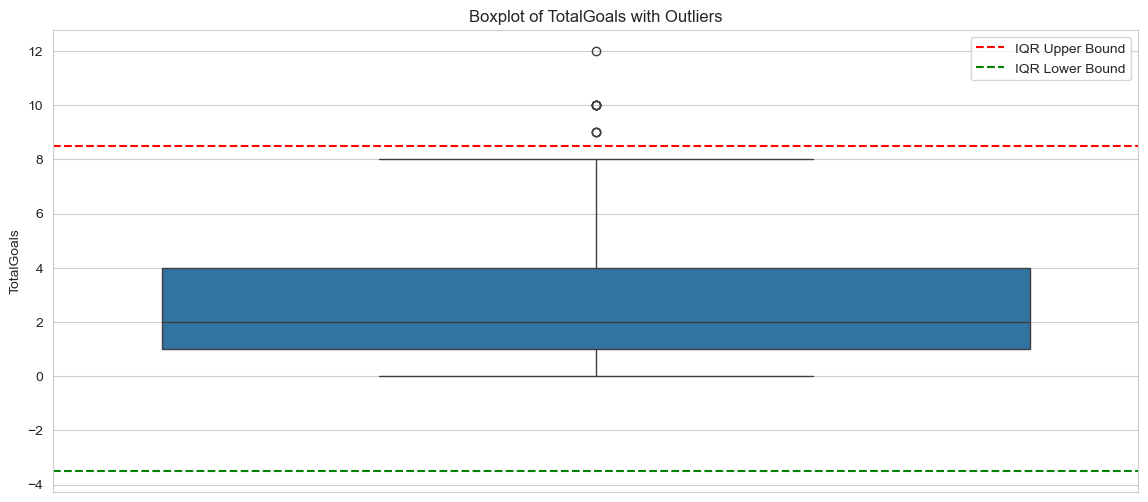

FTHG: 115 outliers
FTAG: 44 outliers
HTHG: 136 outliers
HTAG: 60 outliers
HS: 69 outliers
AS: 31 outliers
HST: 104 outliers
AST: 46 outliers
HF: 61 outliers
AF: 31 outliers
HC: 37 outliers
AC: 33 outliers
HY: 49 outliers
AY: 11 outliers
HR: 428 outliers
AR: 490 outliers
Latitude: 88 outliers
Longitude: 88 outliers
max_temp: 20 outliers
min_temp: 6 outliers
apparent_temperature_max: 7 outliers
apparent_temperature_min: 1 outliers
wind_speed: 111 outliers
precipitation_sum: 690 outliers
rain_sum: 686 outliers
snowfall_sum: 52 outliers
Squad_size: 19 outliers
Avg Age: 11 outliers
Avg Market Value in millions: 484 outliers
Total Market Value in millions: 497 outliers
TotalGoals: 34 outliers


In [1527]:
detect_outliers_democratic(matches)

In [160]:
analyze_unique_values(matches)

Columns with less unique values:
Referee: [nan]
Country: ['Spain']
showers_sum: [0.]
precipitation_probability_mean: [nan]


In [401]:
find_duplicates(matches)

No duplicate rows found.


Season       Date    HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0      2014 2014-08-23     Almeria     Espanol     1     1   D     0     0   
1      2014 2014-08-23     Granada   La Coruna     2     1   H     0     1   
2      2014 2014-08-23      Malaga  Ath Bilbao     1     0   H     1     0   
3      2014 2014-08-23     Sevilla    Valencia     1     1   D     1     0   
4      2014 2014-08-24   Barcelona       Elche     3     0   H     1     0   
...     ...        ...         ...         ...   ...   ...  ..   ...   ...   
4035   2024 2025-02-16     Espanol  Ath Bilbao     1     1   D     0     0   
4036   2024 2025-02-16  Valladolid     Sevilla     0     4   A     0     2   
4037   2024 2025-02-16    Mallorca  Las Palmas     3     1   H     3     0   
4038   2024 2025-02-16       Betis    Sociedad     3     0   H     0     0   
4039   2024 2025-02-17   Barcelona   Vallecano     1     0   H     1     0   

     HTR  ...  rain_sum  showers_sum  snowfall_sum  \
0      D  ...       0.6          0.0           0.0   
1      A  ...       0.0          0.0           0.0   
2      H  ...       0.0          0.0           0.0   
3      H  ...       0.0          0.0           0.0   
4      H  ...       1.5          0.0           0.0   
...   ..  ...       ...          ...           ...   
4035   D  ...       0.0          0.0           0.0   
4036   A  ...       4.2          0.0           0.0   
4037   H  ...       0.0          0.0           0.0   
4038   D  ...       0.0          0.0           0.0   
4039   H  ...       0.0          0.0           0.0   

      precipitation_probability_mean        Team  Squad  Avg Age  Foreigners  \
0                                NaN     Almeria     31     25.5          11   
1                                NaN     Granada     39     25.8          22   
2                                NaN      Malaga     30     27.1          18   
3                                NaN     Sevilla     34     25.5          14   
4                                NaN   Barcelona     31     25.9          17   
...                              ...         ...    ...      ...         ...   
4035                             NaN     Espanol     28     26.0           8   
4036                             NaN  Valladolid     25     26.7          17   
4037                             NaN    Mallorca     24     28.8          10   
4038                             NaN       Betis     26     27.8          13   
4039                             NaN   Barcelona     26     24.9           8   

      Avg Market Value  Total Market Value  
0               €1.24m             €38.30m  
1               €1.73m             €67.55m  
2               €2.76m             €82.80m  
3               €4.90m            €166.75m  
4              €19.48m            €603.80m  
...                ...                 ...  
4035            €2.48m             €69.50m  
4036            €1.82m             €45.60m  
4037            €3.46m             €83.00m  
4038            €7.11m            €184.95m  
4039           €39.02m             €1.01bn  

[4040 rows x 47 columns]

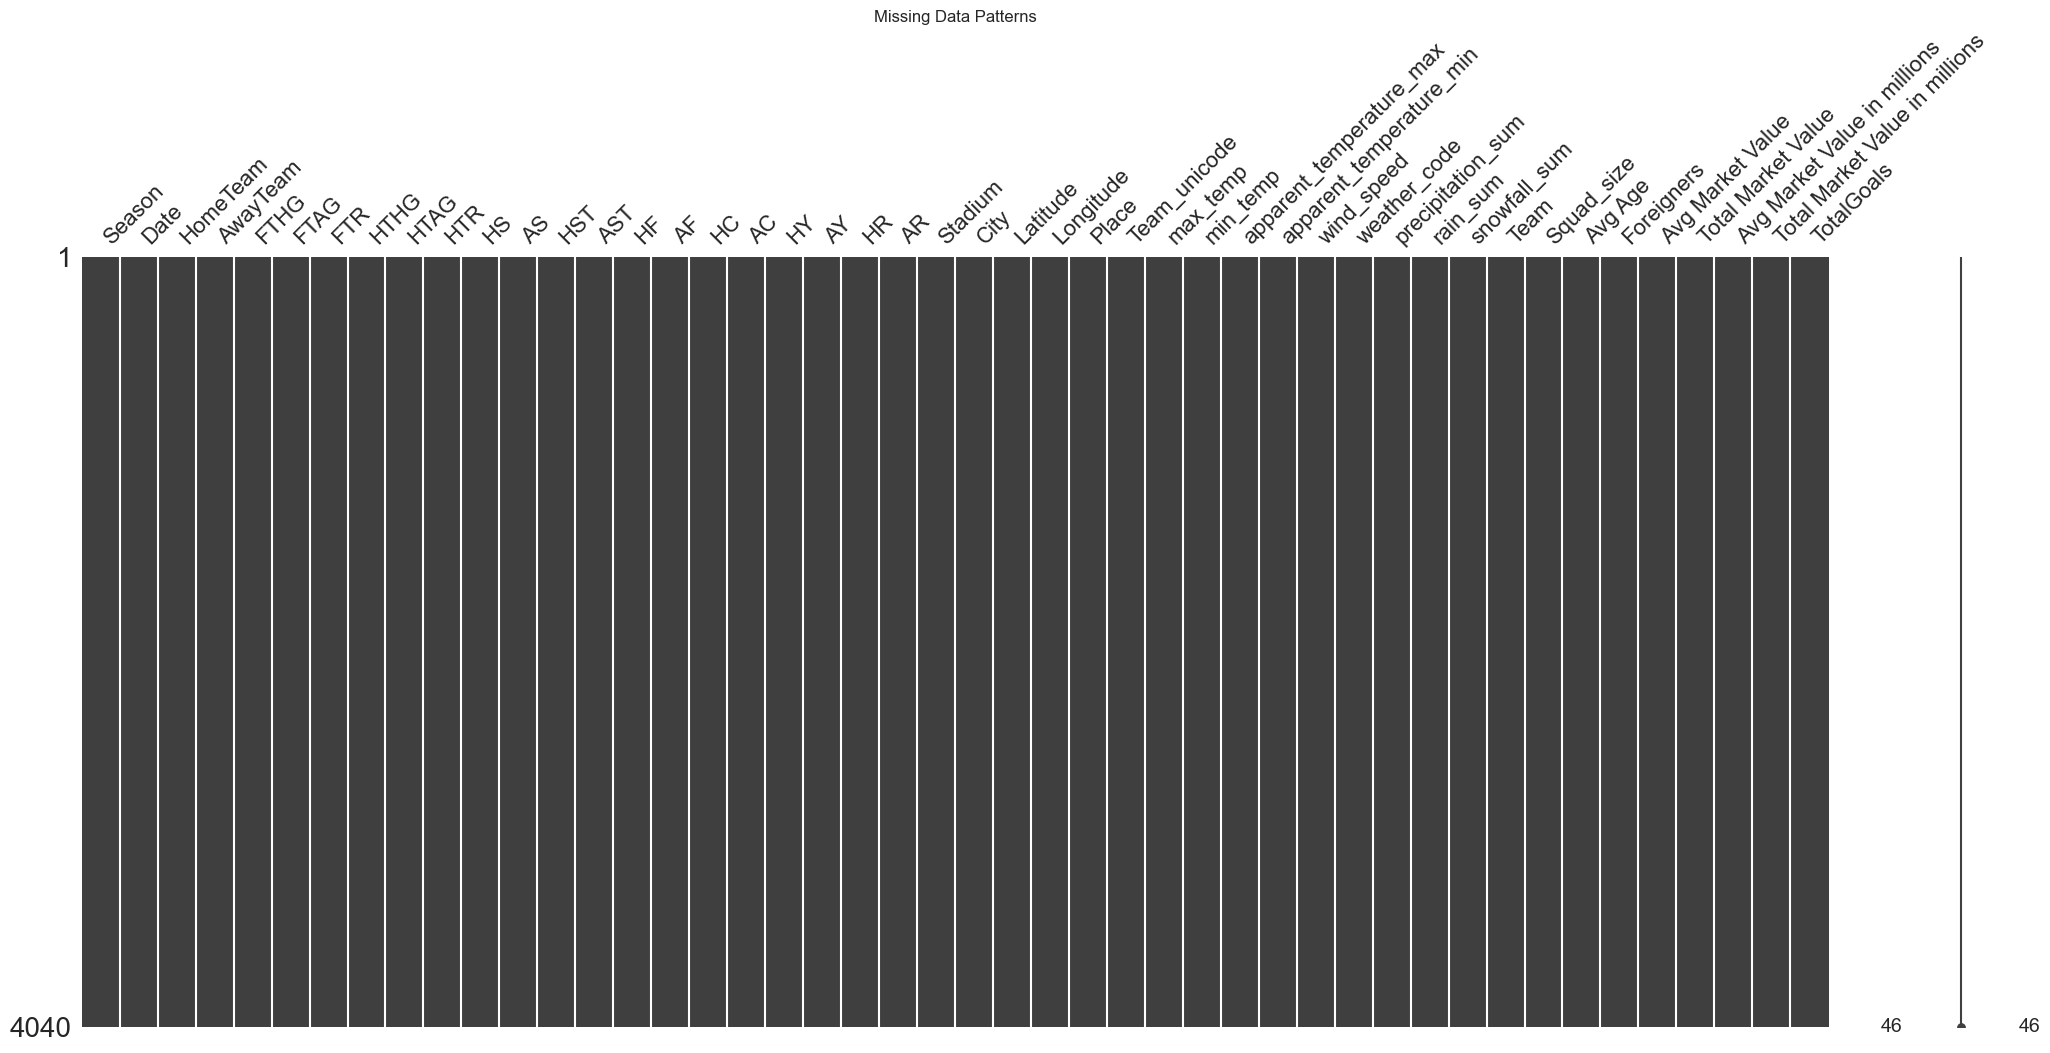

In [1594]:
visualize_missing_patterns(matches)

In [1592]:
describe_data(players)

***Describing the data:***
Number of rows: 6279
Number of columns: 36

Missing values:
Exp_xG            1628
Exp_npxG          1628
Exp_xAG           1628
Exp_npxG+xAG      1628
Prog_PrgC         1628
Prog_PrgP         1628
Prog_PrgR         1628
Per_90_xG         1628
Per_90_XAG        1628
Per_90_XG+AG      1628
Per_90_npxG       1628
Per_90_npxG+AG    1628
dtype: int64

Unique values:
Season              11
Player            2157
Nation              99
Pos                 10
Squad               31
Age                 28
Born                31
MP                  38
Starts              39
Min               2595
90s                377
Perf_Gls            37
Perf_Ast            19
Perf_G+A            43
Perf_G-PK           32
Perf_PK             10
Perf_PKatt          13
Perf_CrdY           19
Perf_CrdR            4
Exp_xG             172
Exp_npxG           151
Exp_xAG             97
Exp_npxG+xAG       198
Prog_PrgC          153
Prog_PrgP          258
Prog_PrgR          283
Per_90_Gls

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\shaun\AppData\Local\Temp\ipykernel_16588\1514477107.py:22: DeprecationWarning:

is_categorical_dtype is deprecated and will

  Min: 0.00
  Max: 10.16
  Mean: 0.21
  Median: 0.13
  Standard Deviation: 0.31
  Skewness: 11.52
  Kurtosis: 284.53
  Unique values: 144

Column: Per_90_npxG, Type: float64
  Min: 0.00
  Max: 4.07
  Mean: 0.11
  Median: 0.05
  Standard Deviation: 0.19
  Skewness: 7.34
  Kurtosis: 107.51
  Unique values: 108

Column: Per_90_npxG+AG, Type: float64
  Min: 0.00
  Max: 10.16
  Mean: 0.20
  Median: 0.13
  Standard Deviation: 0.30
  Skewness: 12.46
  Kurtosis: 318.81
  Unique values: 137

Correlation matrix:
                     Age      Born        MP    Starts       Min       90s  \
Age             1.000000 -0.797117  0.223566  0.231128  0.229988  0.229986   
Born           -0.797117  1.000000 -0.228874 -0.260670 -0.262365 -0.262380   
MP              0.223566 -0.228874  1.000000  0.908728  0.926421  0.926448   
Starts          0.231128 -0.260670  0.908728  1.000000  0.994414  0.994403   
Min             0.229988 -0.262365  0.926421  0.994414  1.000000  0.999997   
90s             0.229986

(6279, 36)

Null counts per variable:
Season               0
Player               0
Nation               1
Pos                  0
Squad                0
Age                  2
Born                 2
MP                   0
Starts               0
Min                  0
90s                  0
Perf_Gls             0
Perf_Ast             0
Perf_G+A             0
Perf_G-PK            0
Perf_PK              0
Perf_PKatt           0
Perf_CrdY            0
Perf_CrdR            0
Exp_xG            1628
Exp_npxG          1628
Exp_xAG           1628
Exp_npxG+xAG      1628
Prog_PrgC         1628
Prog_PrgP         1628
Prog_PrgR         1628
Per_90_Gls           0
Per_90_Ast           0
Per_90_G+A           0
Per_90_G-PK          0
Per_90_G+A-PK        0
Per_90_xG         1628
Per_90_XAG        1628
Per_90_XG+AG      1628
Per_90_npxG       1628
Per_90_npxG+AG    1628
dtype: int64

Rows with the highest number of nulls (12 nulls):
Percentage of rows with any nulls: 25.95%


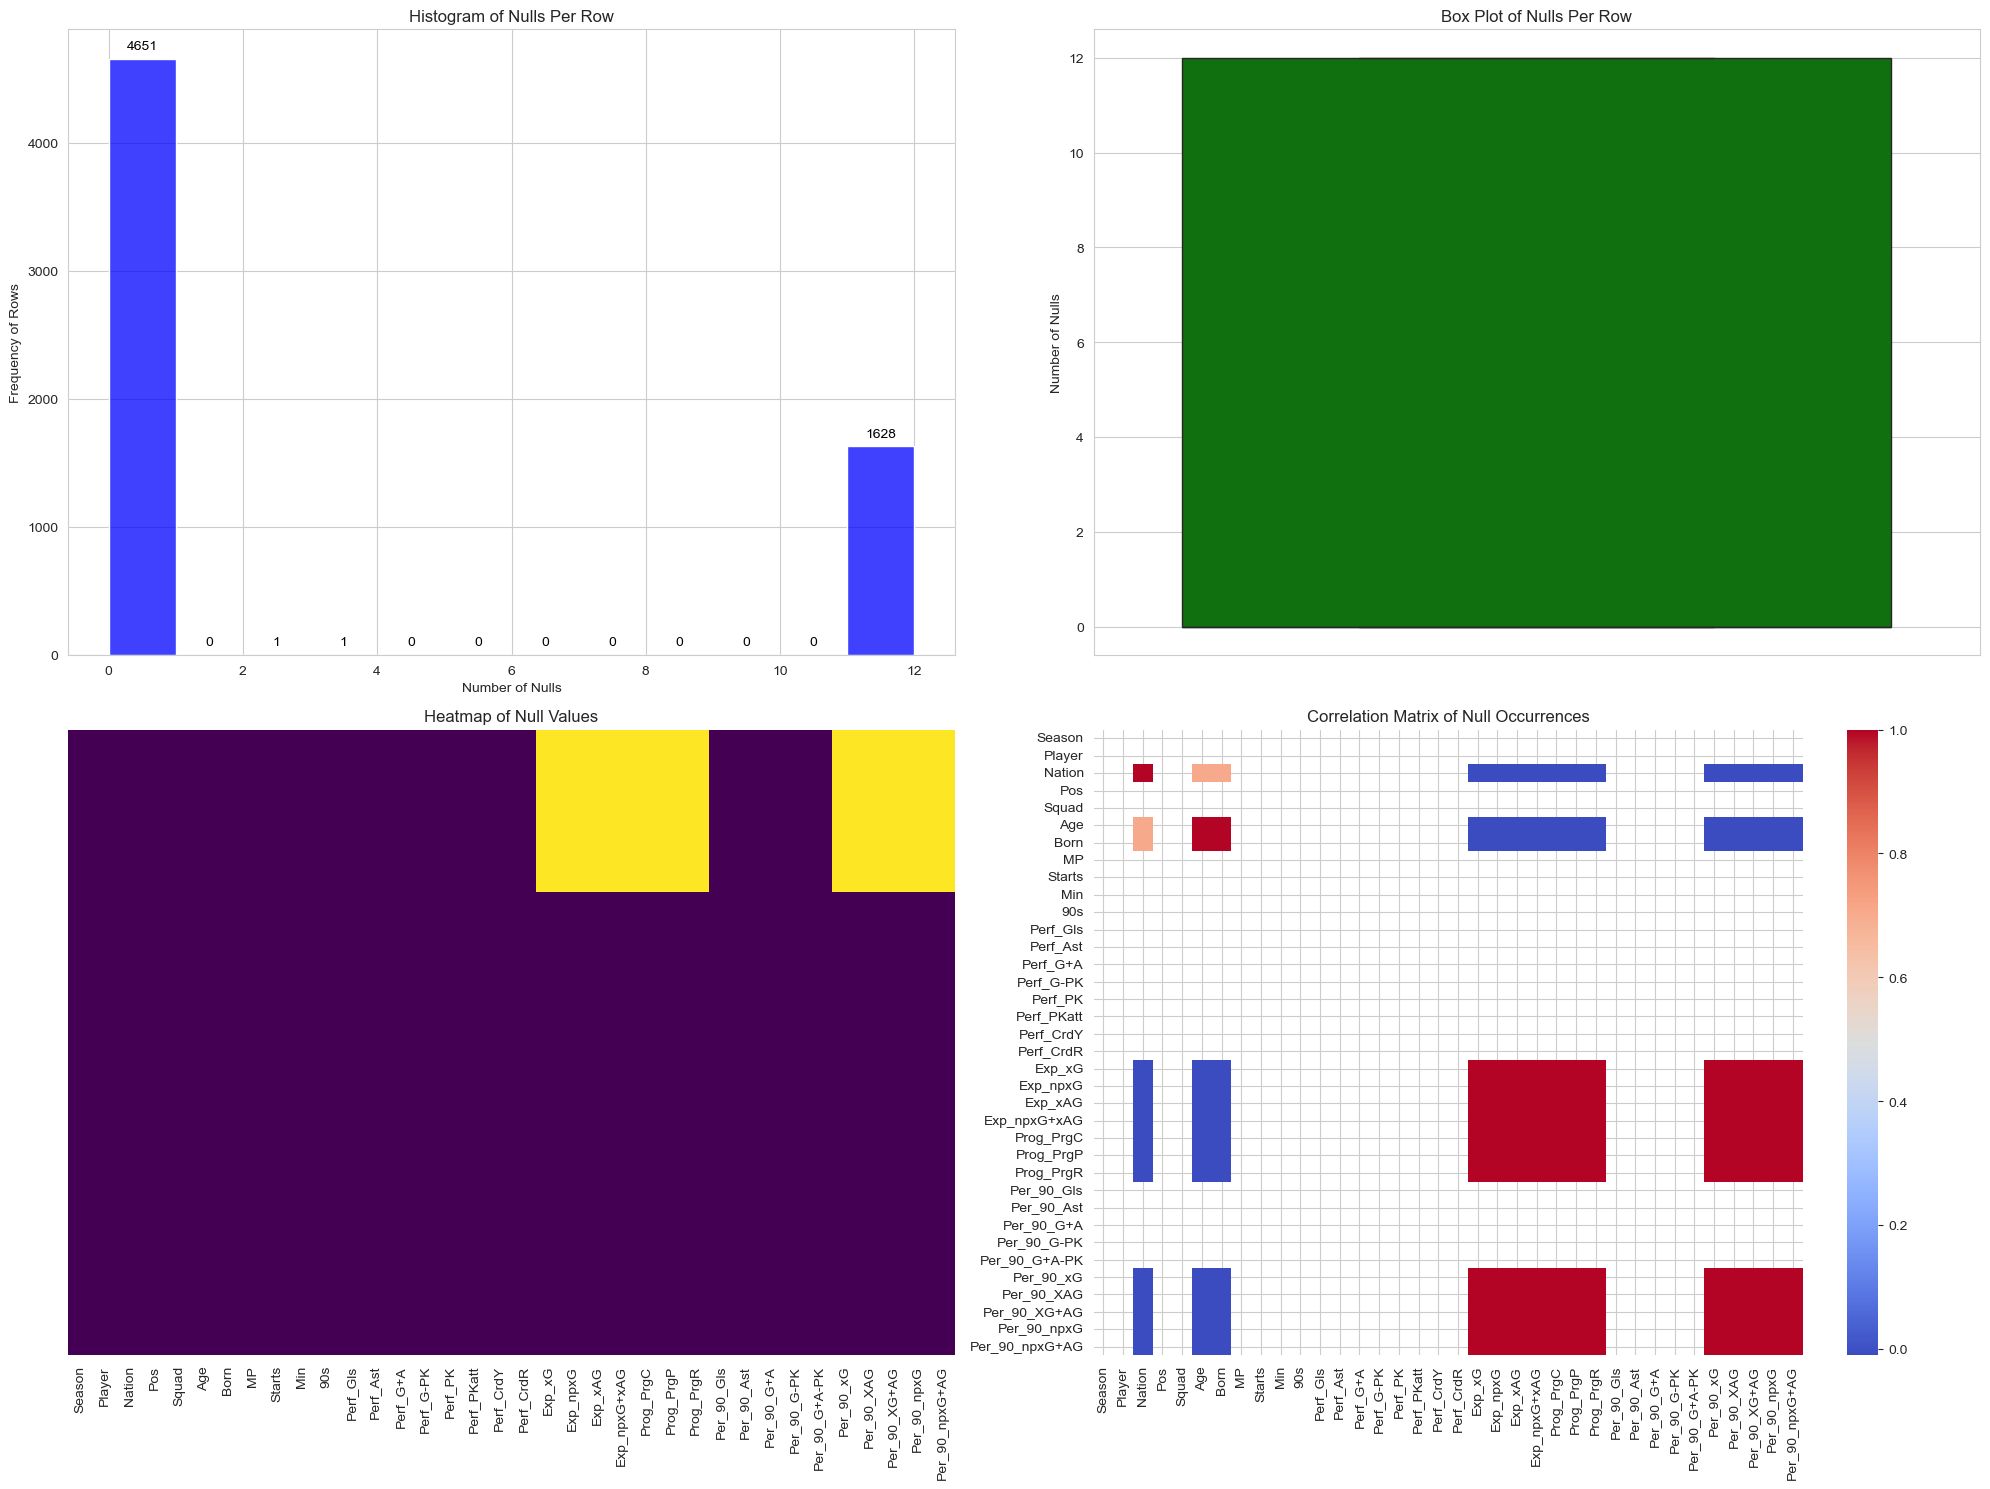


Suggested handling methods:
Nation: 0.02% nulls
  Consider mean/median imputation or dropping rows
Age: 0.03% nulls
  Consider mean/median imputation or dropping rows
Born: 0.03% nulls
  Consider mean/median imputation or dropping rows
Exp_xG: 25.92% nulls
  Consider dropping the column
Exp_npxG: 25.92% nulls
  Consider dropping the column
Exp_xAG: 25.92% nulls
  Consider dropping the column
Exp_npxG+xAG: 25.92% nulls
  Consider dropping the column
Prog_PrgC: 25.92% nulls
  Consider dropping the column
Prog_PrgP: 25.92% nulls
  Consider dropping the column
Prog_PrgR: 25.92% nulls
  Consider dropping the column
Per_90_xG: 25.92% nulls
  Consider dropping the column
Per_90_XAG: 25.92% nulls
  Consider dropping the column
Per_90_XG+AG: 25.92% nulls
  Consider dropping the column
Per_90_npxG: 25.92% nulls
  Consider dropping the column
Per_90_npxG+AG: 25.92% nulls
  Consider dropping the column


In [1218]:
analyze_missing_data(players)

*** Outlier Detection Summary ***

Age: 8 ouliers detected
Outliers: [40. 40. 41. 40. 41. 40. 40. 40.]



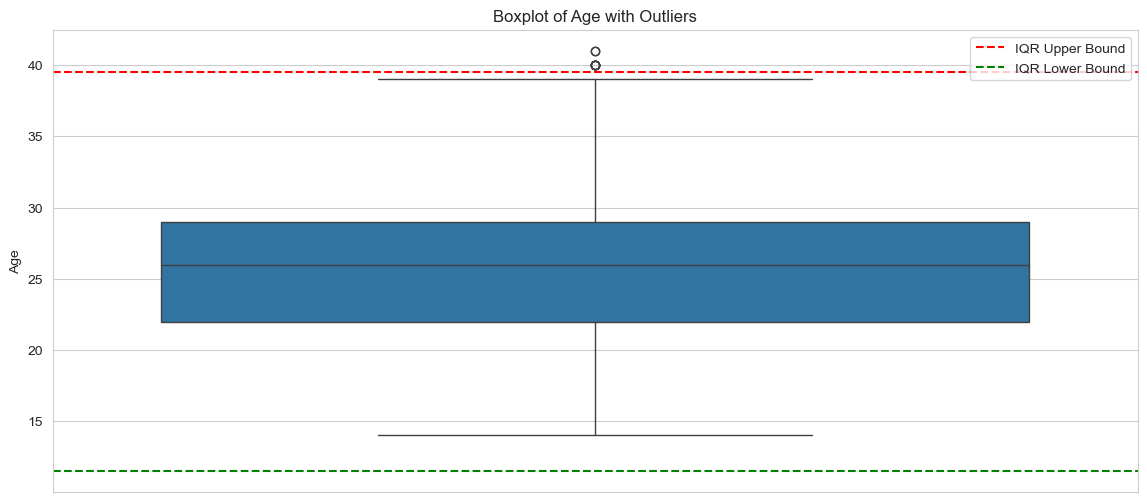

Born: 5 ouliers detected
Outliers: [1976. 1976. 1976. 1976. 1975.]



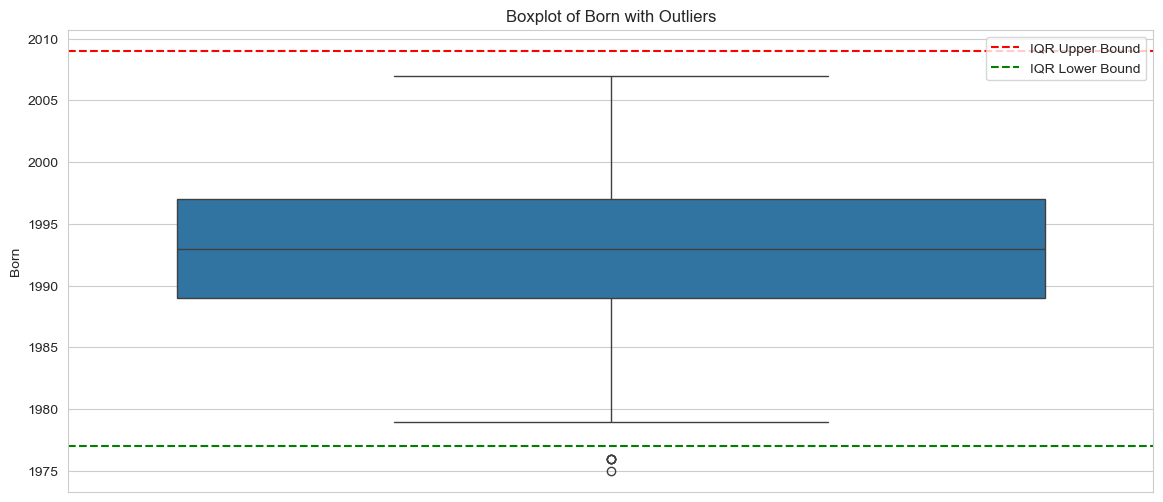

MP: 0 ouliers detected


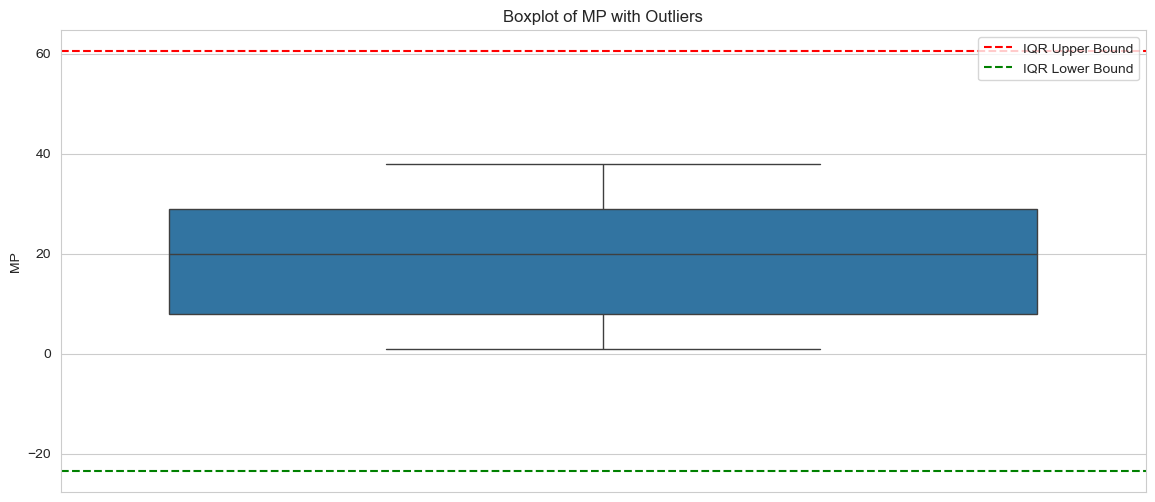

Starts: 0 ouliers detected


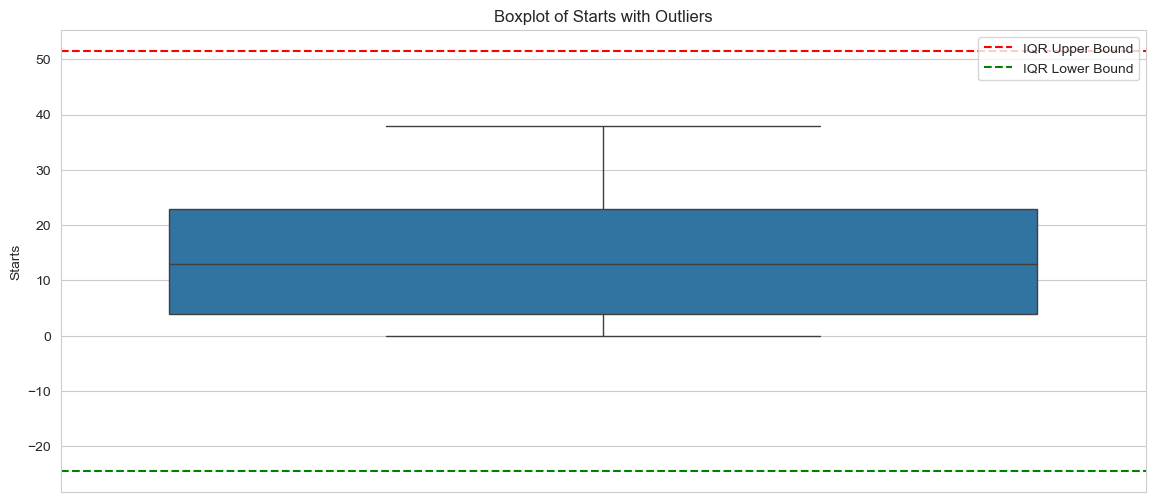

Min: 0 ouliers detected


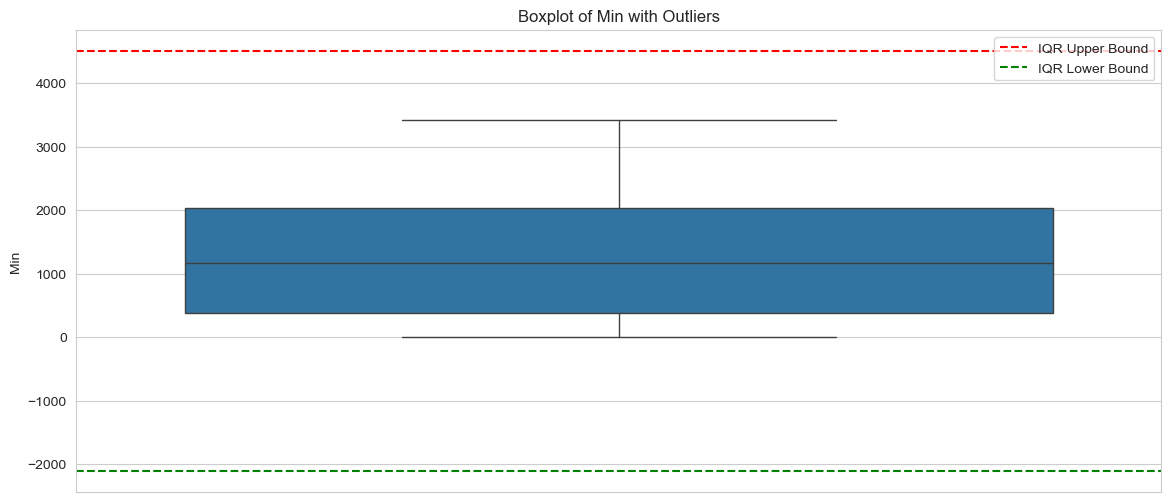

90s: 0 ouliers detected


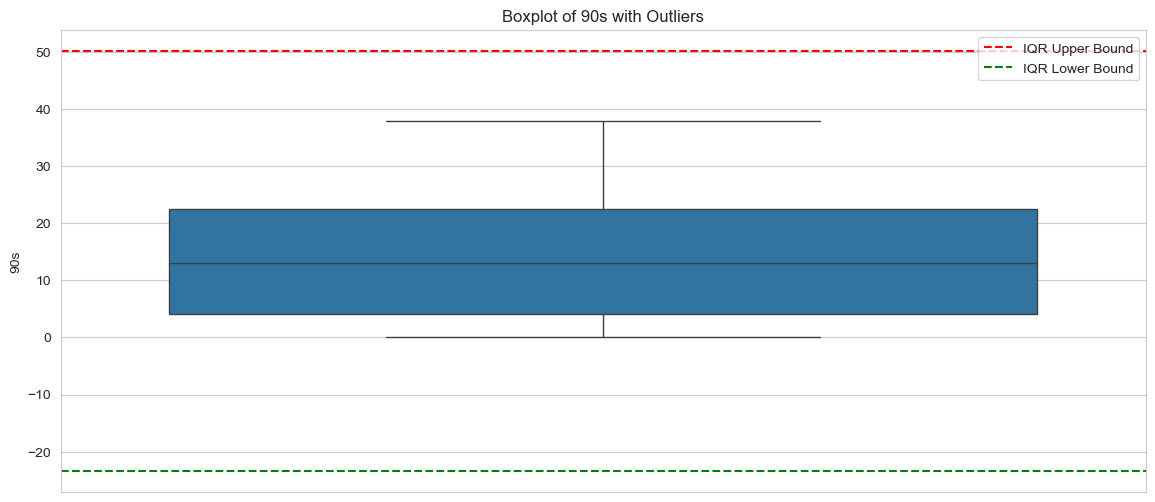

Perf_Gls: 523 ouliers detected
Outliers: [18 12 16 16 23 14 22 12 21 13 13 15 26 15 24 12 17 12 14 35 40 25 12 18
 14 16 19 13 12 15 13 13 16 14 19 36 14 12 13 20 13 13 16 14 13 12 19 18
 24 12 19 19 21 12 15 17 12 19 21 13 12 30 12 12 13 23 22 15 16 13 17 12
 19 15 18 20 27 17 34 12 12 16 12 28 23 24 12 13 16 13 16 16 14 12 15 16
 14 19 23 12 15 15 18 37 15 13 13 13 14 17 25 12 13 14 13 17 14 16 20 13
 13 22 13 17 16 15 14 13 25 43 21 20 21 22 17 12 18 16 12 12 15 17 12 48
 13 12 13 26 14 13  9  8  7  8  9  9  6  9  7  6  7  7  8  7  6 11  6  6
 10  6  7  8  8  8  7 11  6  9  6  8  8  8  6 10  9  6  9 10 10  7  7  7
  7  6  6  6 10  7  8  6  8 10  6  7  8  6  6  6  6  8  6 11  6  9  7  8
 10  9  6  8  6 10 10  8 11  7  7  7  7  8  7 11  6  7  8  9  7 11 11  7
  6  8 10  6 11 10  8  8 10  6  6  7  7 10  8  8 10  6  7  7  7  9 10  7
  8  8  6  6  7  6  6  7  6 10  6  7  8  7 11  8  6  7  6  7  7  6  8  7
  7  9  8  6  7  9  6 11  6  7  9  7  9  7 10  6  6 11  8  7 10  7  7  7
  9 11  9 

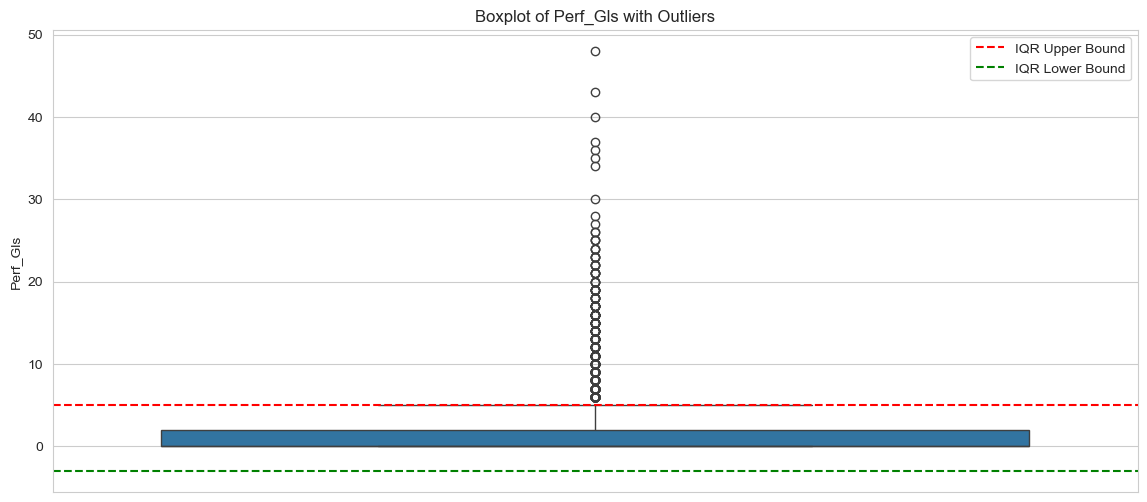

Perf_Ast: 259 ouliers detected
Outliers: [ 9 10  7  8  7  9 13  9  8  9 12  9 18  7  9  8  9  7  8 11 10  7 10 12
  7  7  8  9  8  7  8 10  9  7  9  7  7 10  9 10  8 10  8  7  9 10  7  8
  7  7 12 16  8  9 13  9 10  7  8  7  9 13  7  7 13  8 10 17  7 13  7  9
 10  7  8  8 10  7 14  7 13  9 12  7  9  7 10 11  8  8  8  8  8  8  7 12
  7 12  7  7  8 14  7  7  7 13  8  9 10  8  7  8  7 10  7  7 11  7  7 11
  9  7 10  7 10  7  7  9 11  7  7  7  7 11  8  8 21 10  7  8  8 10 10 16
  7  8  8  7 10  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]



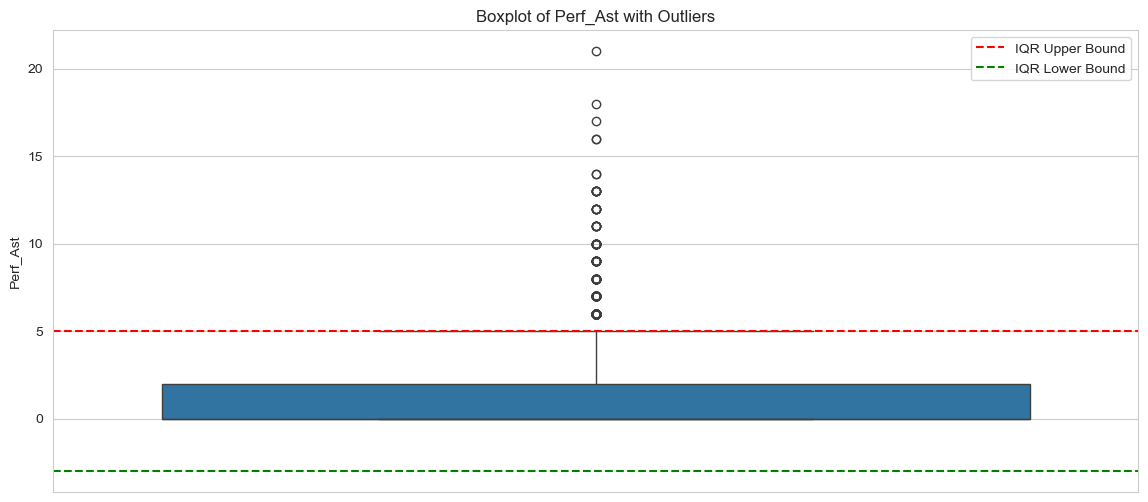

Perf_G+A: 389 ouliers detected
Outliers: [21 29 27 31 40 18 17 18 23 19 20 26 30 17 26 29 19 31 19 20 23 19 25 31
 17 19 29 20 18 22 49 21 27 19 30 26 19 17 39 29 21 17 18 18 18 19 27 17
 17 25 27 21 19 23 20 22 17 19 22 18 24 32 19 23 20 32 20 40 23 34 18 17
 17 24 21 46 18 18 17 44 17 57 46 64 18 39 19 31 17 26 24 18 21 17 18 28
 20 21 27 23 19 21 27 27 37 23 20 22 17 46 19 26 22 61 21 18 23 26 17 20
 17 29 20 19 17 18 22 20 26 11 12 13 14 11 12 11 12 16 14 14 15 13 14 12
 11 12 11 11 11 14 11 12 12 15 14 13 13 16 11 14 16 11 12 12 12 11 14 14
 15 14 16 13 11 11 11 12 13 15 16 11 11 12 15 16 11 15 13 14 12 12 12 12
 12 11 12 14 11 12 12 11 15 11 13 15 13 14 12 15 13 15 12 14 14 11 12 15
 11 13 14 14 16 12 11 16 11 16 12 14 12 12 16 14 12 14 13 13 16 12 13 13
 16 16 13 12 11 13 12 16 12 11 11 11 13 13 13 15 15 12 12 16 15 13 13 11
 13 11 14 11 12 12 12 13 13 12 15 12 12 11 13 11 15 12 12 11 11 14 13 15
 12 11 16 16 14 11 15 12 13 14 13 12 11 12 11 12 14 11 12 15 11 12 14 14
 11 12 16 

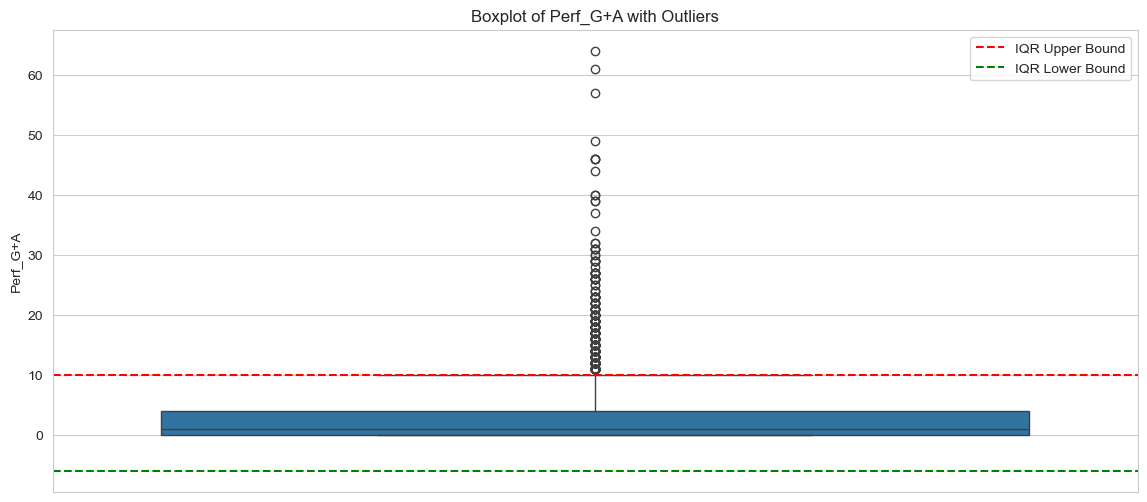

Perf_G-PK: 461 ouliers detected
Outliers: [13 15 15 13 24 12 11 14 16 17 11 19 13 14 17 12 13 11 14 12 12 23 11 12
 12 23 38 13 11 16 12 32 11 11 12 12 27 12 12 17 13 13 11 28 12 21 12 12
 29 11 14 37 12 11 20 11 17 15 11 11 18 15 13 17 14 12 13 11 11 14 16 16
 11 13 15 31 13 18 11 15 11 23 11 19 11 22 11 16 15 11 12 20 19 14 22 13
 38 23 18 15 11 15 17 14 15 12 11 18 16 12 12 32 15 15 16 17 12 12 11 16
 24 17 20 11 13 12 17 12 11 12 11 15 14 14 15 12 14 12 21  9  7  8  6  6
  7  8  8  7  7  7  6  7  7  7  6  9  8  9  9 10  6  7  9  6  9  9 10  6
  6  6  7  6  6  6  7  8  7  7  6 10  7 10 10  6  6  7  7  6  6  6  7  6
  8 10  9  6  8  6  6 10  7  7  8  8  8  7  6  9  7  8  8  7  9  7  7  8
  6  6  6  7  8  7  6  6  8  9  6  9  8  6  7  6  6  7  7  7  9  7  6  7
  9  6  8  7  8  8  7  8  6  7  9  6  6  8  6  7  9  9  6  7 10  7  7  8
  6 10  6  7 10  8  6  8  7 10  7  6 10  9  9  7  7  6  6  6  6 10  9  6
  6 10  9  7  6  7  6  6 10  7  6  8  9  6  9 10  6  6  6  6  6  7  6  8
  6  8  8

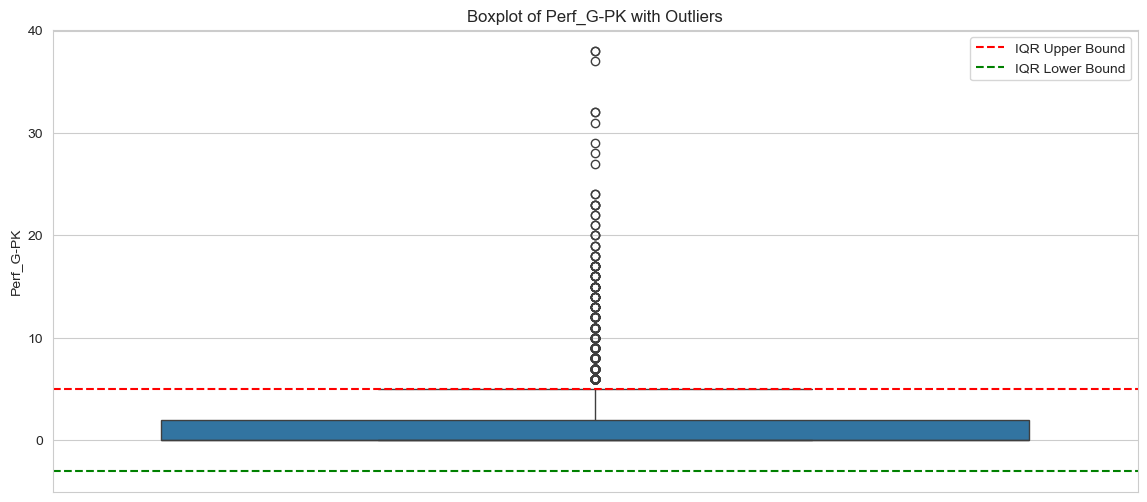

Perf_PK: 472 ouliers detected
Outliers: [ 5  4  4  3  3  7  5  3  5  5  6  3  3  3  3  5  4  3  5  5  4  4  5  3
  8  3  3  7  5 10  3  4  7  4  3  3  3  5  5  5  3  3  5  3  4  3  5  5
  4  5  5  6  6  3  3  4  3  3  4  6  3  5  5  7  4  7  3  3  3  3  7  3
  5  3  3  3 10  3  3  4  3  5  4  3  5  5  4  3  4  6  3  3  3  5  3  6
  4  4  3  7  3  3  3  6  5  3  3  5  7  5  5  3  4  4  3  3  3  6  3  6
  6  3  3  3  4  4  3  3  3  3  2  1  1  1  1  2  1  1  2  1  1  1  1  1
  1  1  2  1  2  1  2  1  2  2  2  2  1  1  1  1  1  1  2  1  1  1  1  2
  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  2  1  1  1  1  2  1
  1  1  1  2  1  2  1  1  1  1  1  2  1  1  2  1  1  2  2  1  1  2  2  1
  2  2  1  2  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  2  1  1  1  1
  1  2  1  1  2  1  1  2  1  1  1  1  1  2  1  1  1  1  1  2  1  1  1  1
  1  1  2  1  1  1  2  1  2  2  1  1  2  2  1  1  2  1  1  1  1  1  1  1
  2  2  1  1  1  1  1  2  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  

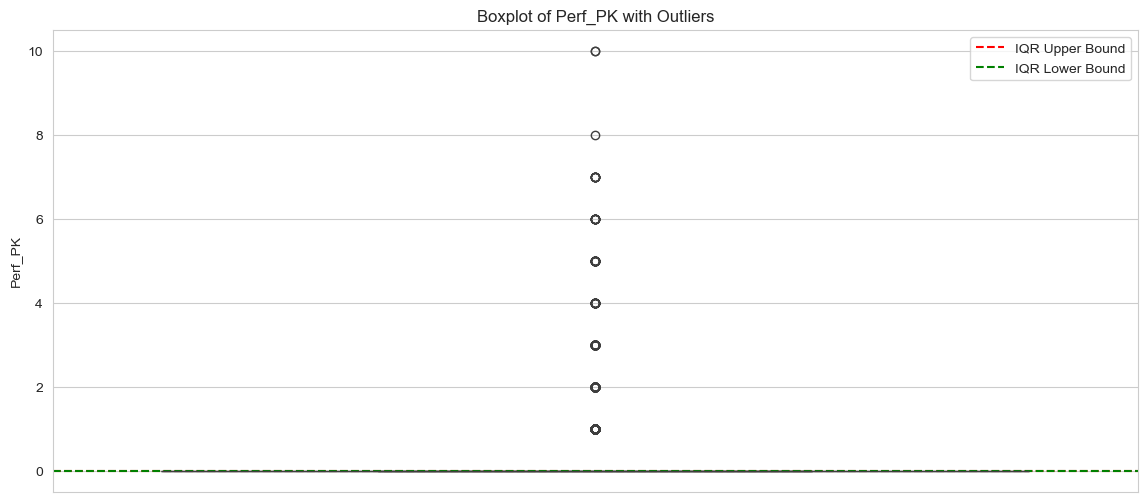

Perf_PKatt: 582 ouliers detected
Outliers: [ 5  3  3  4  7  7  7  3  3  6  6  9  3  3  4  5  4  3  5  3  5  5  5  5
  5  4  6  4  5  6  6  3  5  8  3 12  5  3  3  4  8  5  4  3  5  3  3  6
  7  5  3  4  5  4  4  3  6  5  5  7  5  4  3  8  3  3  3  4  5  3  5 10
  3  5  4  3  3  4  7  4  5  5  9  3  5  3  4  5  4  3 11  3  6  4  6  3
  3  4  4  4  8  5  3  3  4  3  5  5  4  3  3  3  3  4  3  3  7  3  3  3
  3  5  4  5  3  8  4  5  5  5  4  4  6  5  3  5  3  3  5  7  3  5  6  4
  4  4  7  3  3  3  3  3  3  3  3  8  5  7  3  3  4  4  4  3  3  7  4  3
  4  3  5  3  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  2  2  2  1  1  2  2  2  1  2  1  1  1  2  1  1  1  1  2  2  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  2  1  1  2  1  1  1  1  1
  2  1  1  1  1  1  1  1  2  1  2  2  2  1  2  1  1  1  1  1  2  2  2  1
  2  1  2  1  2  2  1  2  1  2  2  2  1  1  1  1  2  1  2  1  1  1  1  1
  1  2  1  1  2  1  2  2  2  1  1  1  2  1  1  1  1  1  2  1  2  1  1  1
  2  1  

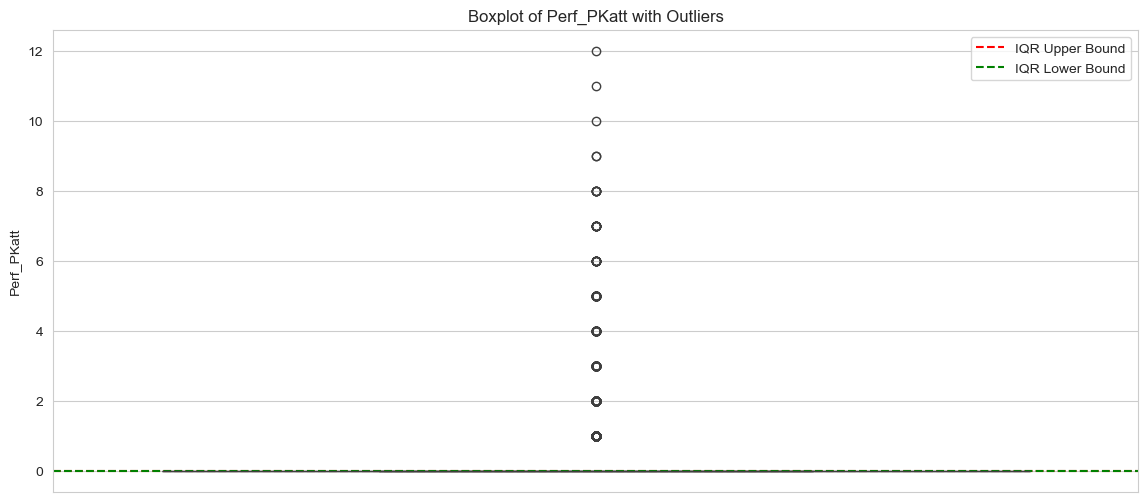

Perf_CrdY: 127 ouliers detected
Outliers: [14 14 13 15 15 14 15 13 14 13 13 13 13 13 16 15 13 14 14 15 14 13 17 13
 15 13 14 15 15 13 16 18 14 16 13 14 17 14 14 13 14 16 13 14 13 13 17 13
 15 13 14 13 14 13 13 14 13 13 13 14 13 15 13 13 13 17 14 14 15 13 14 17
 13 13 14 15 13 14 14 14 14 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12]



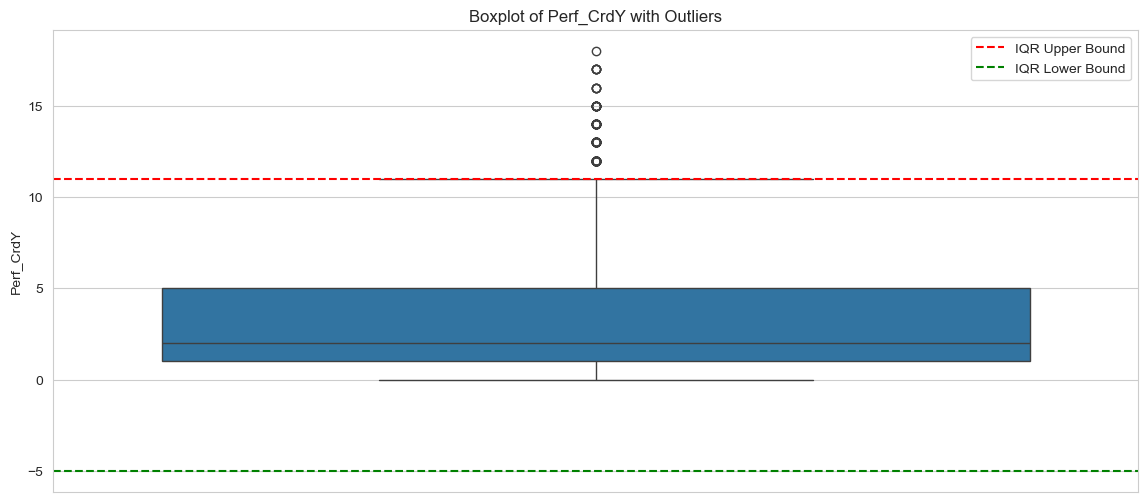

Perf_CrdR: 879 ouliers detected
Outliers: [2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

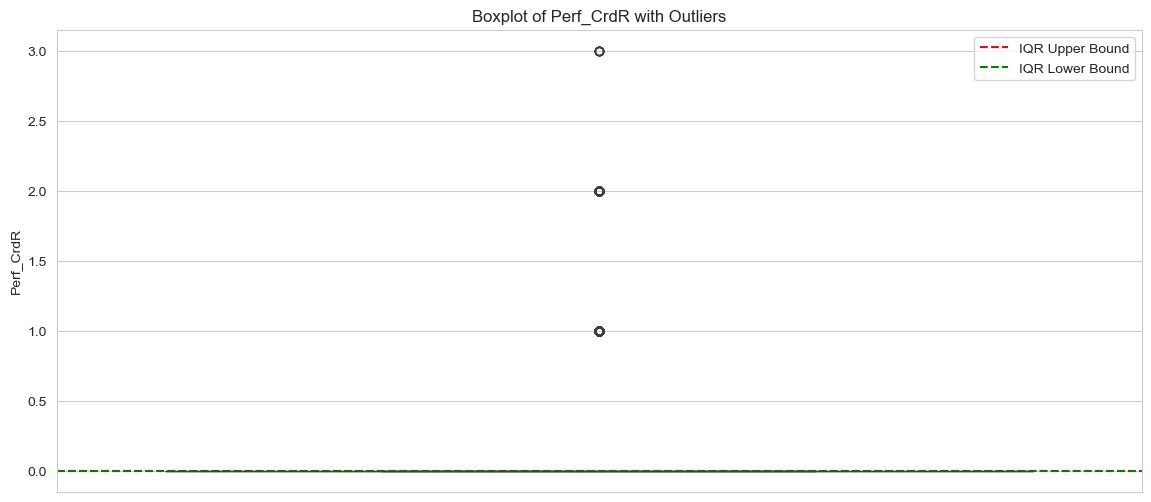

Exp_xG: 490 ouliers detected
Outliers: [12.5 10.8 15.1 11.7 12.  13.9 11.1 10.3 15.6 10.4 12.7 16.2 14.1 23.1
 10.9 13.8 11.7 10.8 12.3 10.6 15.6 10.7 12.2 12.5 10.5 14.8 11.  10.1
 13.1 19.4 11.2 10.7 18.9 18.  10.4 11.2 17.3 14.  12.  11.8 12.1 11.5
 11.3 10.2 11.1 12.3 11.  23.8 21.5 12.3 12.8 10.1 12.4 16.8 12.8 11.
 11.4 13.6 13.7 14.1 13.5 11.7 13.8 16.  17.7 11.9 15.3 25.2 15.8 11.1
 16.  12.9 27.1 12.4 14.5 10.2 14.7 24.3 11.9 15.5 13.1 14.6 22.1 11.6
 11.  13.5 12.3 24.2 11.5 10.8 20.3 12.7 12.9 11.1 14.1 11.6 12.3 18.1
 10.8 20.5 15.3 14.9 11.1 11.5 14.1 11.9 12.8 13.1 14.5 12.7 11.1 11.2
 10.5 17.6 10.8 11.7 23.4 23.7 11.  11.9 14.3 10.2 18.5 10.8 14.2  4.7
  8.4  6.3  7.3  9.6  5.5  6.1  6.5  4.8  6.4  5.   5.7  9.8  6.1  4.6
  9.2  5.4  5.2  5.5  5.6  6.2  5.6  7.5  5.6  9.   4.9  7.7  9.   5.7
  6.5  8.3  7.3  4.9  5.2  5.7  5.3  5.6  9.1  4.9  7.4  4.7  6.6  6.1
  7.4  5.9  5.5  7.   5.2  5.4  7.8  5.1  5.6  9.7  7.8  6.2  5.8  7.2
  4.9  6.2  6.3  4.6  5.2  4.8  4.8  9.

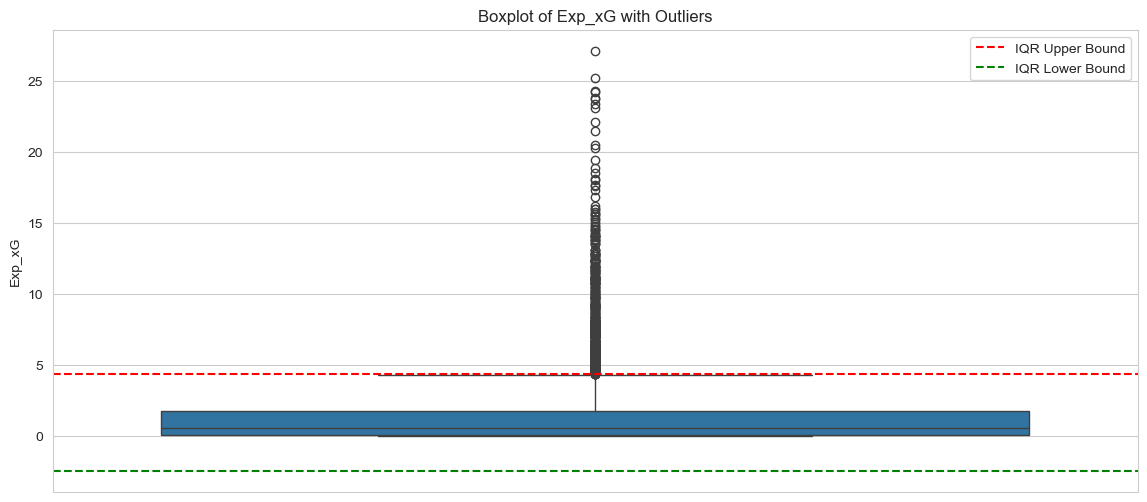

Exp_npxG: 444 ouliers detected
Outliers: [10.2 15.6 13.  11.3 13.  10.3 10.4 20.  12.3 10.  10.2 11.1 13.1 10.5
 10.5  9.4 17.8 23.5  9.   9.   9.1  9.3 11.2 10.2 13.6 13.3 11.2  9.7
 12.3  8.7 11.3  9.3 14.9 10.6 19.9 11.  13.2 15.   9.2  9.9 11.2 10.4
 16.3  9.5 12.3 15.  15.4 13.6 13.7  9.2  8.8 10.3 17.7 11.1  9.   9.6
 12.3 10.  17.9 11.5 10.   8.7 12.  10.8 10.1  8.7  9.1 12.9 14.5 10.8
 11.9  9.6 16.  10.9  9.  10.5 10.1  9.3 12.9 10.8  9.5 10.7 11.  15.6
 12.7  9.6  8.8 10.4 11.1 10.3 22.  14.8 13.8  9.1  9.5 15.3 16.4  9.1
  9.9 12.3  9.2 24.   9.4 17.3 10.8  9.2 11.1 15.1 10.2 13.6 22.6 12.8
 11.5 13.9 10.   8.9  8.8 11.7 10.9 13.3 11.6  7.5  4.6  8.5  4.6  4.9
  8.1  7.3  4.6  7.   7.6  6.7  4.4  5.7  4.5  7.4  6.6  4.7  4.9  7.9
  6.6  4.9  5.2  5.3  6.6  4.4  7.3  8.   7.3  5.6  4.9  5.6  7.5  4.9
  5.6  5.6  6.2  7.4  6.9  5.6  5.5  5.2  4.6  5.6  4.6  5.4  5.5  5.6
  4.7  6.4  7.5  5.2  5.7  5.7  5.8  5.8  6.2  4.2  7.7  5.7  6.8  5.1
  4.8  4.5  5.1  6.2  4.6  4.2  7.5 

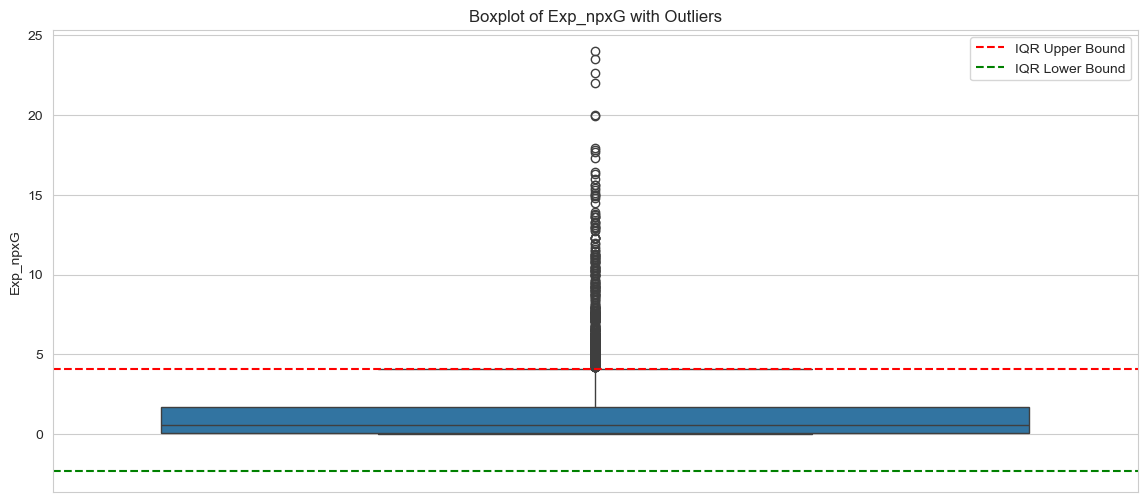

Exp_xAG: 302 ouliers detected
Outliers: [ 7.6  6.9  6.4  6.2  7.9  7.7 13.8  7.6  9.5  6.4  6.2  6.4  6.4  6.2
  6.2  6.5  6.8  6.2  7.6  7.6 13.9  6.   6.4  8.6  6.  11.1  7.7  7.
  6.2 10.3  7.9  9.8  9.5  6.7  7.4  6.   6.6  6.7  9.6  6.3  9.4  6.
  7.9  6.9  7.5  7.   6.7  6.1  7.   6.7  6.   6.5  6.9  6.8  6.1  6.
  7.4 14.4  6.1  8.   6.3  7.4  6.   6.3  7.4  6.8  8.3  6.4  9.5  7.1
  7.   6.7  7.5  6.4  9.2  7.7  6.6  7.8  7.4  6.5  6.3  6.8 10.9  6.4
 10.5  6.2 10.   8.   6.2 15.4  9.   6.9  6.5  6.2  6.3  6.8  7.  10.1
  4.2  5.   5.4  4.4  5.7  4.1  5.3  4.8  5.7  5.9  4.8  4.6  4.8  4.4
  5.   5.9  4.2  4.1  5.5  5.2  5.2  5.7  4.5  5.   5.5  4.3  4.3  4.1
  4.2  5.4  4.6  4.2  5.1  5.6  4.7  4.9  5.6  4.1  5.2  4.9  4.1  4.1
  5.8  4.6  4.6  4.2  4.5  4.8  5.8  4.7  5.   4.4  4.7  5.   5.6  4.8
  4.7  5.7  5.8  5.7  4.8  4.4  4.5  4.8  5.   4.5  5.2  4.1  4.3  5.6
  5.7  5.3  5.   4.3  5.7  4.2  5.3  4.4  4.3  4.6  5.6  5.5  4.7  4.2
  5.   4.2  4.2  4.7  5.6  5.2  4.4  5.1

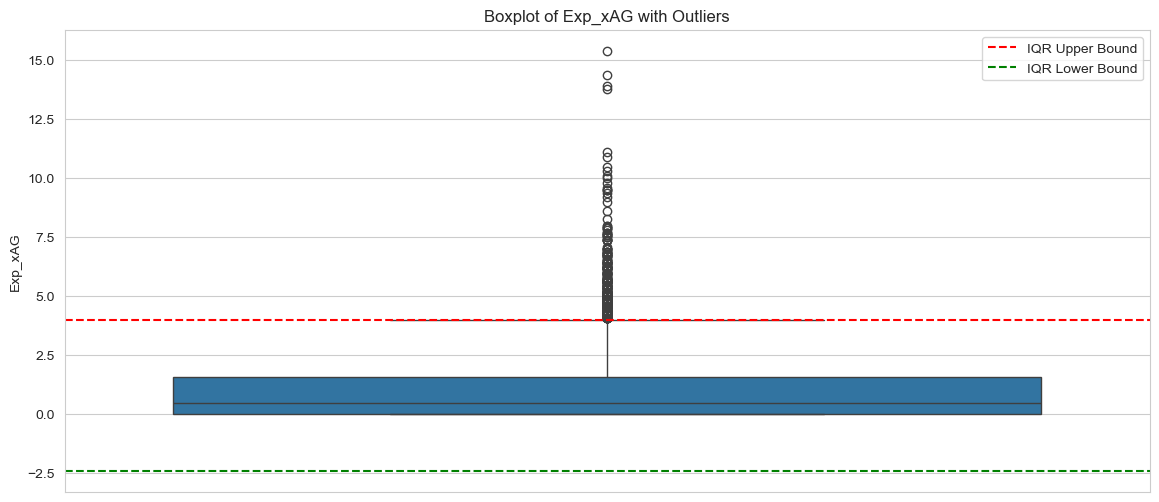

Exp_npxG+xAG: 350 ouliers detected
Outliers: [17.5 13.8 14.5 24.1 13.6 15.6 16.3 17.6 20.5 18.5 30.8 13.9 16.9 19.9
 19.1 13.7 23.9 16.  29.8 19.9 16.4 17.2 26.1 26.9 14.6 22.4 17.3 13.8
 15.1 16.5 34.2 20.7 14.9 16.6 15.7 18.  23.3 18.1 37.9 15.4 14.8 23.
 19.6 16.1 18.3 18.8 16.8 18.  14.4 13.5 24.5 17.5 18.5 14.  15.8 27.2
 16.7 17.  14.  17.8 14.9 16.1 18.2 14.6 24.1 19.9 14.3 16.  14.6 16.8
 33.2 14.9 15.6 20.3 13.7 13.6 14.  21.3 14.2 14.6 19.3 23.9 27.  14.
 13.6 19.  14.5 17.7 14.2 11.4  9.   9.  11.5 10.3 10.1 12.1 10.   9.1
 12.9  9.7 11.3  9.3 11.6 13.4  9.3  9.3  9.1  9.8 10.9 10.4 11.7 11.4
 10.3 10.6  9.  11.3 10.1 10.6 10.2 11.2  8.8  9.6  8.4 13.4 10.   8.5
 12.6  9.8 10.6  9.7 11.7  9.1 12.   9.8  9.2 11.3  8.4 10.5 11.7 10.3
  8.3 12.9  8.6  9.1  9.   9.3  8.4 12.3  9.   9.  11.8 10.  12.5  9.9
 10.4  8.9 10.8 10.   9.  11.4 11.4  9.9 13.4  8.7  9.8 10.8  9.3  8.7
 11.   9.2 13.1 11.7 10.9  8.3  9.7 11.6 10.4 13.2 12.7  9.9 11.8  8.7
  8.8 13.1 11.5  9.6 11.  12.9  9.

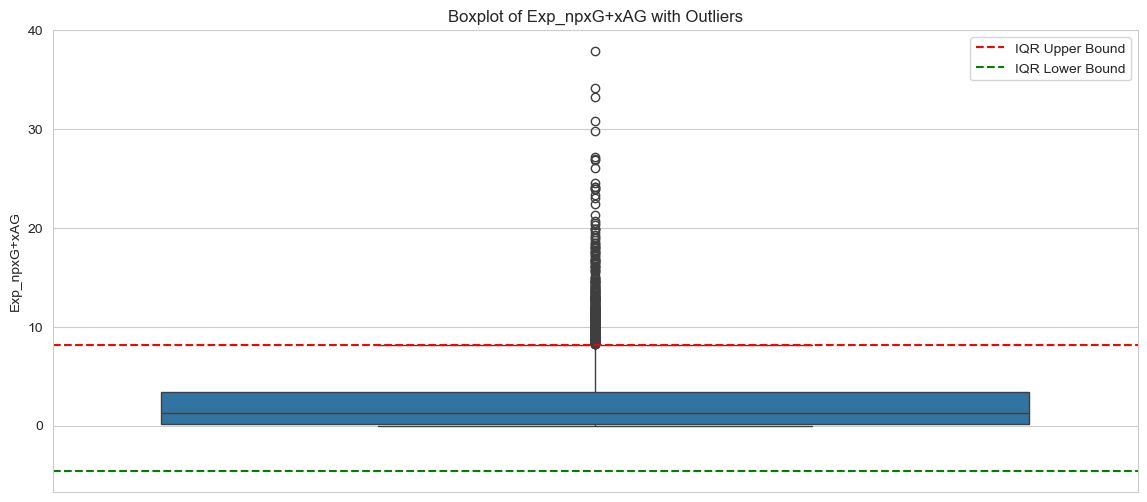

Prog_PrgC: 300 ouliers detected
Outliers: [140. 104. 146. 114. 144. 107. 119. 122. 131. 113. 150. 137. 136. 137.
 112. 110. 113. 154. 106. 144. 110. 127. 117. 104. 116. 107. 221. 108.
 181. 115. 135. 136. 114. 108. 112. 146. 104. 127. 123. 176. 105. 174.
 127. 117. 193. 153. 119. 159. 111. 128. 120. 110. 112. 123. 211. 141.
 146. 154. 119. 117. 116. 140. 106. 105. 104. 127. 110. 143. 116. 114.
 141. 225. 118. 123. 203. 111. 121. 114. 107. 215. 106. 105. 104. 124.
 183. 131. 220. 133. 170. 122. 124. 151. 115.  72.  97.  70.  76.  91.
  83.  76.  73.  90.  71.  88.  85.  91. 103.  72.  87.  95.  99.  84.
  95.  81.  82.  81.  98.  88.  84. 100.  96.  77.  87.  82.  81.  87.
  93.  72.  74.  70.  91.  86.  94.  84.  77.  97.  71.  74.  87.  76.
  80.  76.  71.  96.  76.  94.  84.  75.  71. 102.  79.  80.  90.  76.
  70.  87.  95.  75.  70.  70.  73.  75.  80.  97.  92.  71.  72.  71.
  86.  98.  82.  91.  72. 100.  94.  89.  90.  78.  70.  90.  77.  78.
  74.  74.  82.  93.  93. 103.  88.

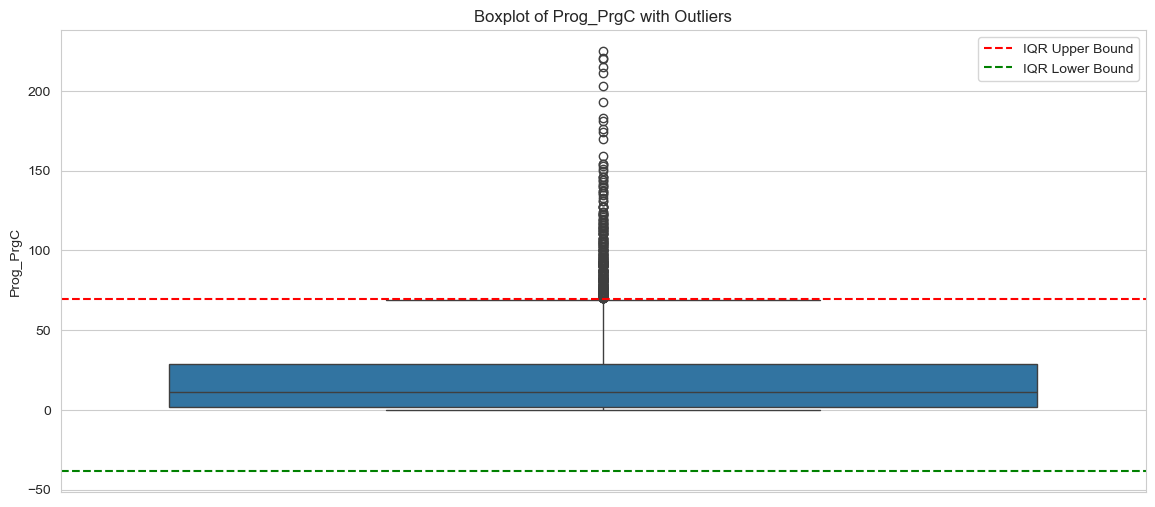

Prog_PrgP: 163 ouliers detected
Outliers: [203. 318. 215. 256. 363. 210. 254. 224. 218. 319. 269. 333. 204. 221.
 221. 232. 305. 294. 254. 203. 204. 221. 238. 219. 210. 274. 219. 254.
 220. 214. 250. 232. 216. 229. 237. 258. 216. 212. 290. 245. 212. 220.
 205. 204. 255. 291. 298. 280. 207. 233. 295. 238. 295. 209. 211. 251.
 231. 208. 254. 244. 206. 211. 292. 250. 327. 204. 269. 323. 250. 262.
 335. 263. 291. 214. 296. 259. 277. 261. 328. 283. 350. 320. 183. 197.
 179. 180. 182. 197. 184. 182. 170. 172. 196. 184. 171. 184. 179. 175.
 185. 188. 177. 193. 180. 174. 172. 169. 173. 184. 167. 199. 178. 200.
 176. 167. 195. 181. 171. 171. 179. 184. 202. 189. 166. 191. 168. 197.
 169. 170. 181. 196. 182. 181. 183. 167. 184. 174. 195. 181. 167. 171.
 175. 175. 201. 182. 182. 172. 192. 179. 169. 169. 184. 173. 170. 181.
 187. 197. 185. 191. 177. 198. 173. 199. 168.]



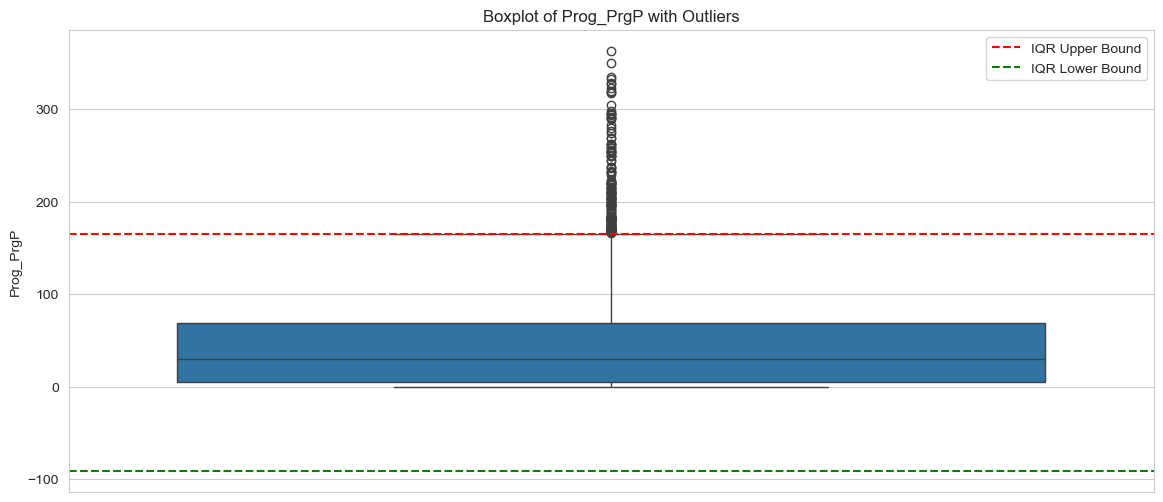

Prog_PrgR: 242 ouliers detected
Outliers: [247. 294. 239. 232. 268. 237. 372. 267. 269. 261. 256. 263. 249. 234.
 314. 253. 294. 237. 265. 241. 250. 252. 278. 251. 241. 240. 372. 263.
 251. 252. 270. 252. 254. 339. 277. 230. 256. 260. 248. 265. 273. 249.
 229. 239. 239. 231. 288. 229. 244. 268. 263. 316. 495. 327. 237. 293.
 304. 269. 249. 233. 263. 349. 259. 245. 231. 341. 321. 242. 236. 298.
 261. 229. 261. 233. 283. 232. 252. 288. 235. 293. 264. 312. 264. 256.
 263. 244. 331. 296. 485. 235. 350. 302. 239. 333. 233. 354. 229. 301.
 256. 234. 184. 186. 180. 212. 199. 175. 218. 177. 183. 191. 213. 185.
 215. 184. 196. 181. 187. 183. 219. 178. 202. 188. 201. 180. 173. 200.
 179. 214. 207. 186. 176. 206. 173. 193. 201. 224. 224. 209. 201. 224.
 193. 217. 197. 215. 175. 204. 182. 182. 182. 190. 220. 173. 205. 217.
 185. 177. 185. 193. 222. 178. 177. 218. 226. 191. 181. 174. 182. 186.
 209. 188. 202. 217. 222. 200. 187. 186. 196. 209. 177. 213. 215. 213.
 199. 179. 180. 183. 178. 180. 215.

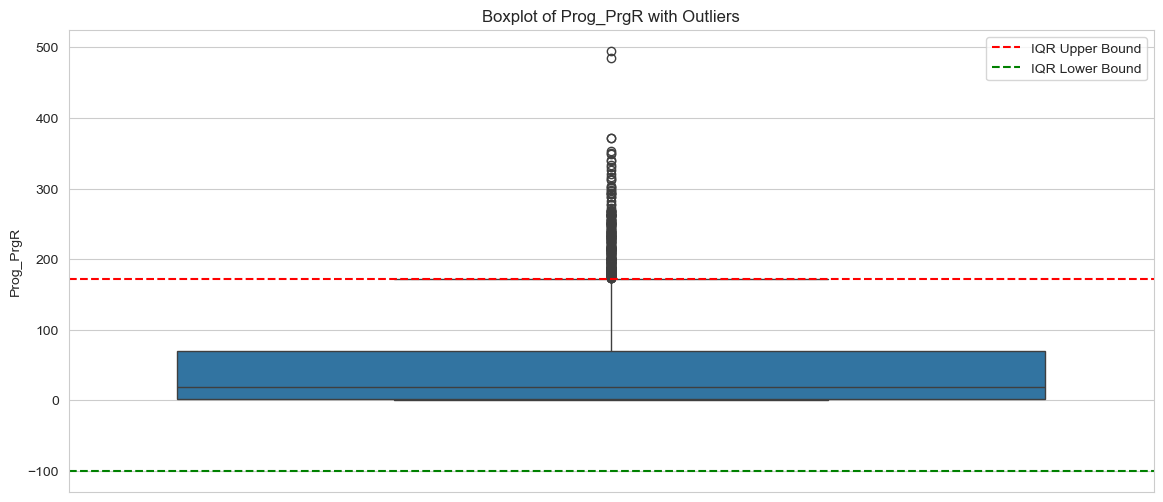

Per_90_Gls: 626 ouliers detected
Outliers: [0.99 0.99 0.84 9.   1.33 0.91 1.09 1.14 1.2  1.03 0.83 0.9  0.94 0.91
 0.87 0.88 1.   0.83 0.94 1.01 1.22 1.43 1.18 0.86 1.39 1.02 1.13 1.01
 1.53 1.14 1.05 0.89 3.33 0.84 0.84 1.1  1.19 0.91 2.   2.05 1.01 1.05
 1.5  0.85 0.84 1.08 0.87 0.87 1.45 0.89 0.88 0.92 2.43 1.15 0.91 1.
 0.99 0.83 0.84 1.14 1.02 1.   2.   1.03 1.02 0.83 0.84 6.92 4.5  1.07
 0.33 0.33 0.5  0.61 0.73 0.41 0.71 0.38 0.63 0.35 0.46 0.34 0.63 0.44
 0.7  0.36 0.65 0.62 0.35 0.7  0.38 0.51 0.55 0.43 0.5  0.43 0.45 0.39
 0.4  0.39 0.44 0.43 0.53 0.34 0.33 0.35 0.36 0.56 0.38 0.4  0.36 0.38
 0.38 0.43 0.62 0.41 0.36 0.39 0.56 0.35 0.42 0.41 0.44 0.36 0.39 0.53
 0.72 0.45 0.54 0.33 0.35 0.4  0.7  0.43 0.52 0.64 0.63 0.44 0.38 0.39
 0.6  0.49 0.42 0.53 0.45 0.33 0.5  0.47 0.64 0.54 0.57 0.46 0.45 0.57
 0.55 0.36 0.52 0.5  0.5  0.35 0.43 0.55 0.72 0.6  0.33 0.4  0.35 0.44
 0.35 0.43 0.59 0.51 0.63 0.37 0.37 0.54 0.62 0.41 0.39 0.46 0.53 0.35
 0.72 0.47 0.34 0.55 0.36 0.36 0.61 

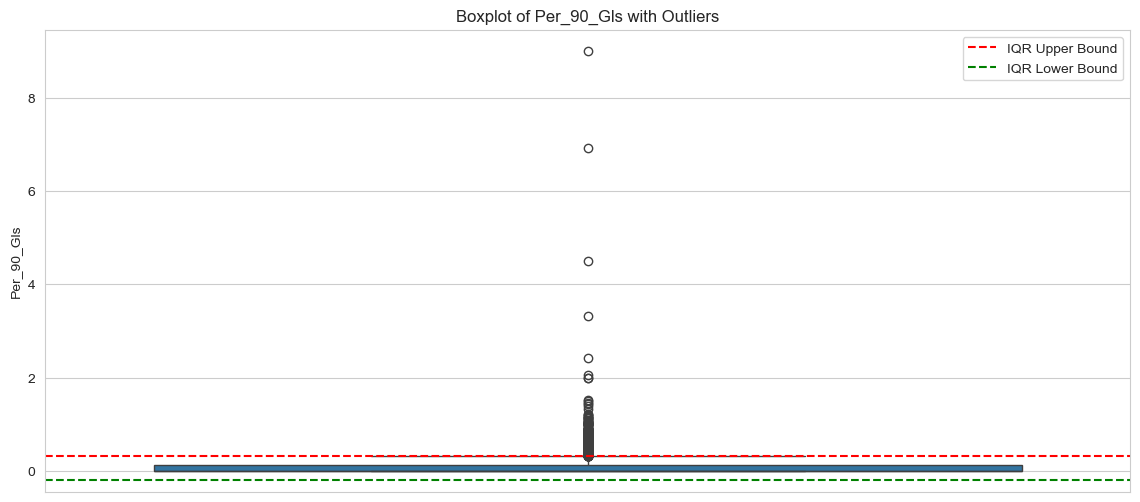

Per_90_Ast: 360 ouliers detected
Outliers: [0.65 2.09 0.74 0.66 0.64 2.05 0.63 1.76 1.14 1.15 1.14 2.57 0.75 1.5
 1.87 0.9  0.73 1.14 1.   0.91 3.1  1.84 0.78 1.18 0.68 2.   1.96 0.7
 1.01 3.   0.73 4.74 0.83 0.64 0.69 1.   1.03 4.5  3.6  0.73 2.43 0.6
 0.64 0.35 0.38 0.37 0.28 0.3  0.34 0.32 0.34 0.37 0.28 0.58 0.4  0.28
 0.29 0.46 0.42 0.44 0.59 0.39 0.29 0.32 0.34 0.32 0.3  0.5  0.41 0.53
 0.34 0.28 0.44 0.46 0.36 0.31 0.28 0.59 0.57 0.53 0.28 0.36 0.34 0.35
 0.28 0.35 0.39 0.33 0.39 0.46 0.32 0.29 0.29 0.4  0.29 0.41 0.31 0.3
 0.39 0.28 0.32 0.3  0.41 0.31 0.4  0.29 0.32 0.34 0.38 0.42 0.28 0.3
 0.31 0.29 0.29 0.28 0.36 0.34 0.34 0.44 0.33 0.32 0.32 0.39 0.33 0.51
 0.31 0.52 0.41 0.33 0.3  0.31 0.36 0.41 0.29 0.28 0.51 0.51 0.35 0.34
 0.28 0.29 0.28 0.36 0.31 0.38 0.31 0.5  0.28 0.43 0.3  0.39 0.33 0.44
 0.28 0.38 0.3  0.32 0.45 0.28 0.38 0.33 0.32 0.31 0.38 0.33 0.37 0.34
 0.28 0.39 0.46 0.29 0.37 0.32 0.37 0.49 0.58 0.35 0.55 0.29 0.4  0.42
 0.42 0.38 0.33 0.42 0.36 0.3  0.3  0.3

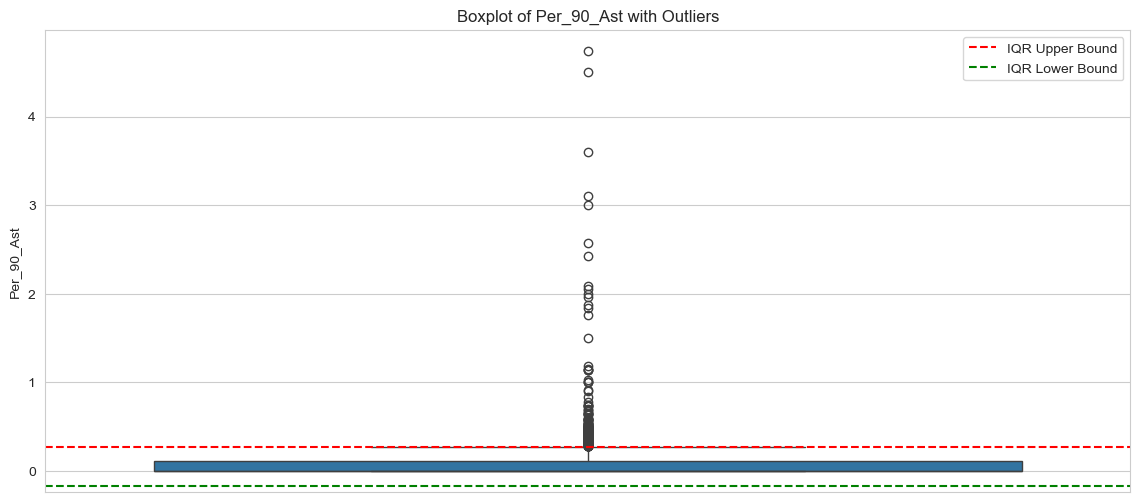

Per_90_G+A: 314 ouliers detected
Outliers: [1.16 2.   1.46 1.32 1.63 2.28 1.21 1.96 1.86 1.14 1.26 2.   1.18 1.84
 1.63 1.34 1.2  1.24 2.   1.14 1.76 1.16 1.87 2.09 1.14 2.05 1.33 1.26
 1.18 1.53 1.18 2.57 2.   2.05 1.45 3.6  4.86 3.33 1.41 3.1  1.15 1.51
 9.   6.92 4.5  1.63 1.45 1.22 1.43 1.5  1.58 1.22 1.38 1.29 4.5  4.74
 1.15 1.35 1.15 1.38 1.5  3.   1.26 1.42 1.44 1.14 1.46 1.05 0.88 0.85
 0.69 0.68 0.97 0.73 0.68 0.69 0.9  0.8  1.07 0.84 0.77 1.1  0.78 1.01
 0.67 0.7  0.66 0.75 0.67 0.99 0.91 0.69 0.77 0.87 0.69 0.66 0.67 0.7
 0.7  0.85 0.85 0.74 0.69 0.7  0.95 0.7  0.78 0.7  1.   1.13 0.73 1.03
 0.9  0.91 0.72 0.78 1.   0.71 0.86 0.79 0.67 1.   0.81 1.08 0.7  0.78
 0.88 1.04 1.05 0.76 0.82 0.81 0.85 0.79 0.89 0.71 0.69 1.07 0.87 0.83
 0.86 0.91 0.76 0.68 0.66 0.86 0.69 0.85 0.7  0.67 0.66 0.82 0.66 0.68
 0.94 0.76 1.03 1.01 0.91 0.73 0.83 0.76 0.91 0.9  0.71 0.67 0.72 0.7
 0.7  0.92 0.7  0.9  0.88 0.9  0.97 0.74 0.75 0.99 0.73 0.7  1.02 0.68
 1.08 0.79 0.84 0.68 0.78 0.76 0.82 

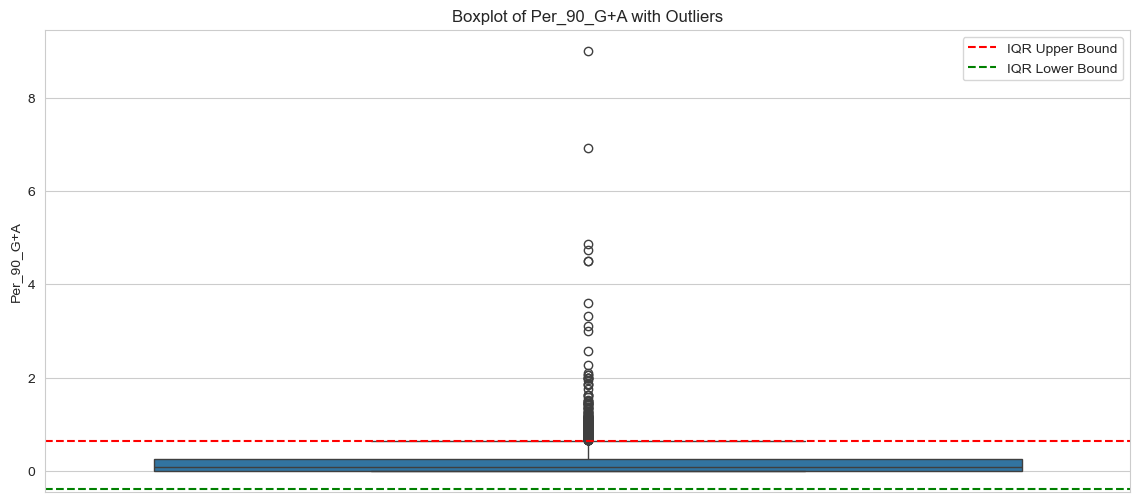

Per_90_G-PK: 600 ouliers detected
Outliers: [0.83 0.91 0.99 1.02 1.13 0.8  3.33 1.14 1.01 1.43 1.22 0.84 1.01 0.84
 1.05 0.91 0.94 1.03 0.84 1.1  1.53 1.14 0.83 0.79 1.01 4.5  0.84 0.92
 1.33 0.79 0.9  0.81 1.2  0.8  0.99 2.   1.05 0.91 9.   1.06 1.1  2.43
 0.82 1.   0.87 0.81 1.06 1.08 2.   1.5  1.01 1.   6.92 0.96 0.91 1.07
 1.03 0.87 0.84 1.45 0.83 0.88 0.91 1.09 0.61 0.32 0.46 0.34 0.32 0.5
 0.35 0.43 0.34 0.55 0.31 0.46 0.33 0.51 0.31 0.34 0.43 0.43 0.33 0.31
 0.71 0.41 0.36 0.31 0.34 0.53 0.56 0.43 0.34 0.44 0.33 0.4  0.35 0.36
 0.41 0.38 0.38 0.36 0.7  0.73 0.33 0.35 0.43 0.5  0.41 0.39 0.4  0.58
 0.45 0.68 0.53 0.36 0.41 0.36 0.35 0.53 0.39 0.4  0.39 0.59 0.7  0.33
 0.47 0.35 0.5  0.45 0.47 0.49 0.52 0.54 0.39 0.38 0.44 0.31 0.63 0.64
 0.51 0.37 0.54 0.41 0.35 0.35 0.6  0.33 0.32 0.68 0.55 0.35 0.45 0.5
 0.5  0.36 0.55 0.49 0.57 0.36 0.39 0.43 0.31 0.47 0.68 0.31 0.53 0.46
 0.49 0.62 0.54 0.37 0.58 0.51 0.43 0.57 0.38 0.45 0.38 0.39 0.35 0.39
 0.36 0.36 0.57 0.32 0.52 0.37 0.44

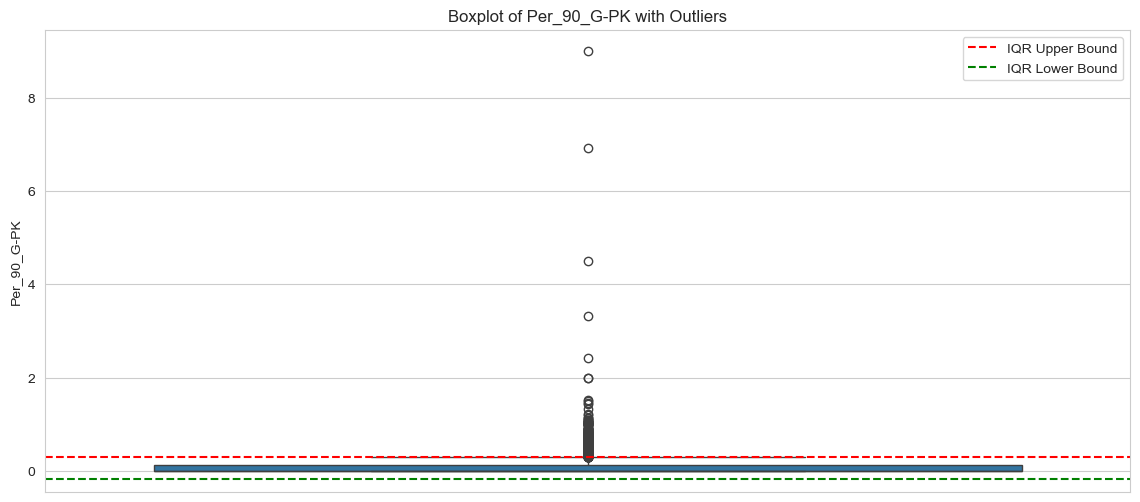

Per_90_G+A-PK: 296 ouliers detected
Outliers: [1.46 2.57 1.13 2.28 1.5  1.42 1.14 1.26 1.16 4.74 2.05 1.87 3.6  1.14
 1.1  4.86 1.12 1.11 1.32 1.57 4.5  1.41 1.15 1.27 1.15 3.33 1.11 1.33
 1.18 1.58 1.2  2.   1.84 1.18 1.14 1.43 1.22 3.1  4.5  1.49 1.14 1.53
 9.   1.26 1.45 1.38 1.22 1.18 1.96 2.09 1.5  1.51 1.21 2.   1.45 1.54
 1.76 1.34 3.   6.92 1.28 1.1  2.   1.29 1.49 1.26 1.13 1.   1.08 0.98
 0.66 0.87 1.07 0.71 0.79 1.07 0.69 0.68 0.82 0.85 0.83 0.64 0.7  0.68
 0.64 0.86 0.89 0.86 0.68 0.91 0.8  0.79 0.64 0.78 0.7  0.66 0.69 0.75
 1.05 0.91 0.91 0.71 0.75 0.66 0.96 0.7  0.7  0.93 0.95 0.63 0.64 0.89
 0.75 0.73 0.76 0.89 0.78 0.67 0.75 0.66 0.66 0.69 1.04 0.76 0.94 0.69
 1.03 0.87 0.91 0.82 0.75 0.66 0.66 1.01 0.73 0.71 0.85 1.   0.75 0.64
 0.7  0.85 0.7  0.94 0.92 1.02 0.78 0.63 0.65 0.69 0.7  0.66 0.69 0.9
 0.7  0.74 0.84 0.85 0.71 0.63 0.78 0.69 1.07 0.68 0.68 0.63 0.92 1.03
 0.64 0.68 0.94 0.84 0.76 0.71 0.63 0.76 1.07 0.83 0.98 0.65 0.97 0.84
 0.73 0.8  0.63 0.69 0.9  0.7  0

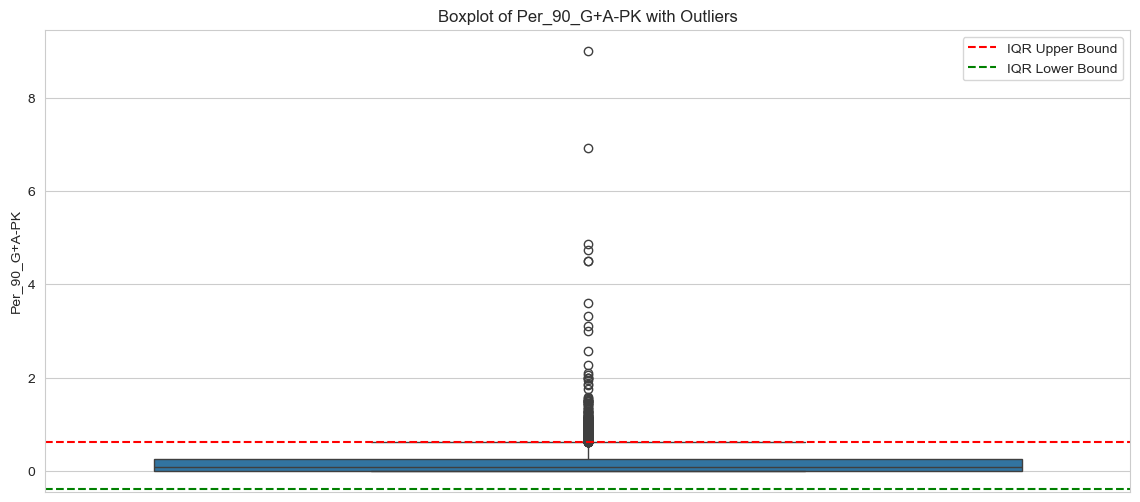

Per_90_xG: 366 ouliers detected
Outliers: [0.92 0.81 0.77 0.82 0.75 1.08 0.81 0.86 1.66 0.95 2.21 1.31 0.99 0.83
 1.77 1.01 3.94 2.15 1.29 2.03 0.99 3.23 0.92 1.57 0.8  1.39 0.91 0.79
 0.73 1.06 1.38 4.07 0.74 1.34 1.8  0.84 0.99 1.44 1.27 0.85 0.78 0.74
 1.25 0.73 1.41 0.76 0.89 0.92 1.18 0.94 1.47 1.46 0.73 1.2  0.44 0.63
 0.53 0.64 0.45 0.7  0.44 0.41 0.55 0.41 0.46 0.47 0.44 0.41 0.48 0.4
 0.58 0.66 0.45 0.48 0.44 0.55 0.42 0.49 0.45 0.48 0.58 0.47 0.59 0.39
 0.45 0.63 0.6  0.53 0.62 0.64 0.48 0.45 0.56 0.47 0.41 0.51 0.48 0.39
 0.4  0.39 0.46 0.51 0.5  0.61 0.4  0.65 0.45 0.45 0.6  0.45 0.39 0.58
 0.5  0.4  0.47 0.72 0.63 0.43 0.48 0.53 0.4  0.42 0.51 0.43 0.5  0.5
 0.39 0.51 0.43 0.65 0.41 0.39 0.39 0.56 0.57 0.45 0.41 0.49 0.52 0.55
 0.64 0.46 0.57 0.41 0.53 0.53 0.45 0.61 0.41 0.42 0.39 0.39 0.41 0.49
 0.63 0.62 0.47 0.61 0.69 0.52 0.44 0.5  0.56 0.54 0.65 0.64 0.47 0.4
 0.42 0.46 0.42 0.51 0.53 0.47 0.57 0.63 0.39 0.42 0.43 0.39 0.47 0.46
 0.46 0.43 0.4  0.49 0.42 0.41 0.68 0.

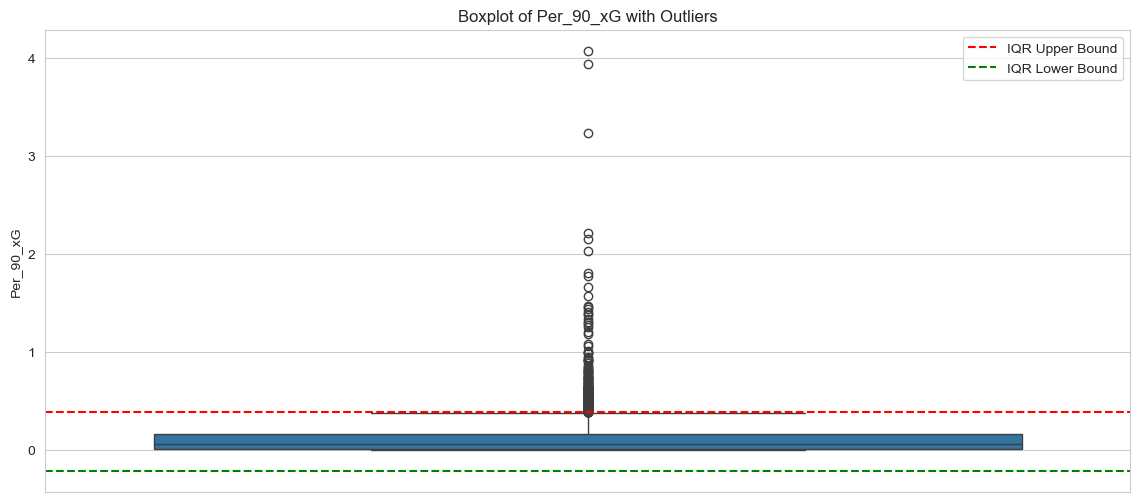

Per_90_XAG: 161 ouliers detected
Outliers: [2.01 6.93 4.87 1.77 5.61 1.27 0.8  1.17 1.7  0.66 0.84 2.13 1.43 0.7
 0.74 0.73 3.39 0.73 0.35 0.32 0.32 0.32 0.34 0.35 0.32 0.39 0.34 0.33
 0.3  0.35 0.43 0.33 0.29 0.42 0.35 0.36 0.38 0.42 0.29 0.34 0.47 0.33
 0.32 0.34 0.43 0.32 0.3  0.56 0.31 0.3  0.43 0.31 0.33 0.36 0.3  0.37
 0.3  0.3  0.3  0.48 0.35 0.33 0.29 0.56 0.63 0.29 0.51 0.46 0.39 0.3
 0.38 0.43 0.38 0.46 0.31 0.31 0.33 0.29 0.36 0.32 0.43 0.29 0.31 0.4
 0.42 0.29 0.4  0.53 0.34 0.41 0.34 0.37 0.34 0.32 0.41 0.33 0.39 0.31
 0.4  0.31 0.37 0.29 0.5  0.31 0.31 0.29 0.39 0.31 0.3  0.46 0.5  0.58
 0.48 0.29 0.57 0.32 0.5  0.34 0.32 0.44 0.31 0.45 0.41 0.39 0.29 0.32
 0.48 0.32 0.53 0.34 0.34 0.32 0.29 0.38 0.31 0.31 0.36 0.39 0.45 0.56
 0.38 0.42 0.32 0.31 0.32 0.37 0.34 0.31 0.44 0.29 0.39 0.29 0.42 0.29
 0.35 0.3  0.3  0.47 0.48 0.42 0.33]



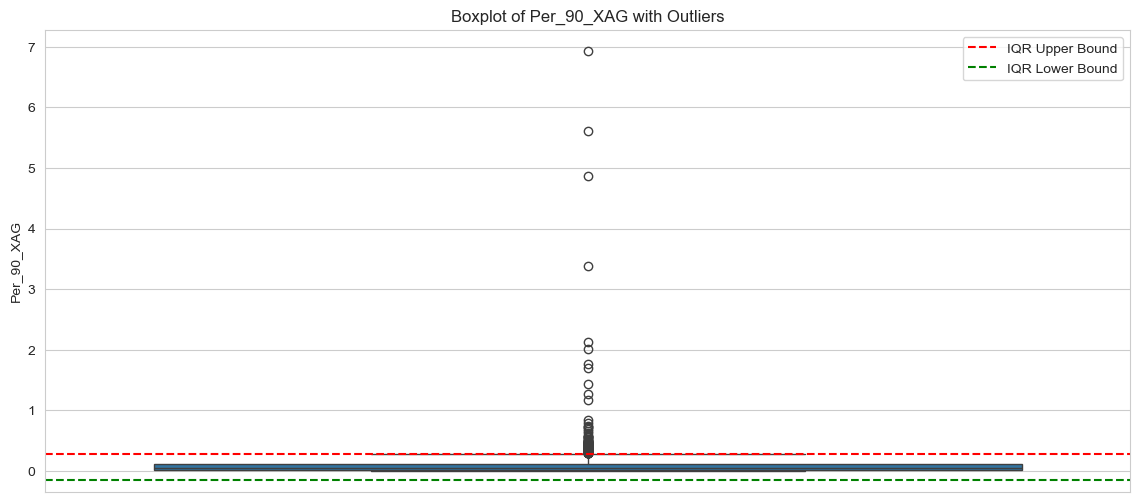

Per_90_XG+AG: 149 ouliers detected
Outliers: [ 1.33  1.67  1.27  2.13  1.15  1.2   1.18  1.74  1.25  2.11  1.38 10.16
  1.29  1.23  1.43  1.34  4.87  1.24  4.07  1.65  5.61  2.26  1.44  1.77
  1.41  1.27  3.94  1.82  1.29  2.21  1.19  1.7   1.22  2.01  1.14  1.66
  2.03  1.2   2.15  1.39  1.8   4.33  1.11  1.12  1.1   0.71  0.82  0.87
  0.94  0.88  0.7   0.73  0.76  0.76  0.74  0.73  0.83  0.72  0.8   0.79
  0.86  0.7   0.74  0.92  0.79  0.91  0.71  0.71  0.78  0.86  0.73  0.7
  0.88  0.71  0.7   1.09  0.93  0.9   0.86  0.85  0.95  0.72  0.78  0.73
  0.84  0.78  0.86  0.75  0.85  1.05  0.73  0.96  0.72  0.71  1.13  0.78
  0.71  0.77  0.78  0.88  1.05  0.7   0.76  0.82  0.95  0.78  0.94  0.78
  0.72  0.94  0.73  0.89  0.73  0.76  1.09  0.79  1.1   0.71  0.7   0.82
  0.94  0.84  0.84  0.71  0.71  0.7   0.74  0.7   0.75  0.9   0.8   0.7
  0.73  0.78  0.89  0.85  0.97  0.99  0.76  0.72  0.71  0.76  0.72  0.82
  0.74  0.93  0.87  0.83  0.81]



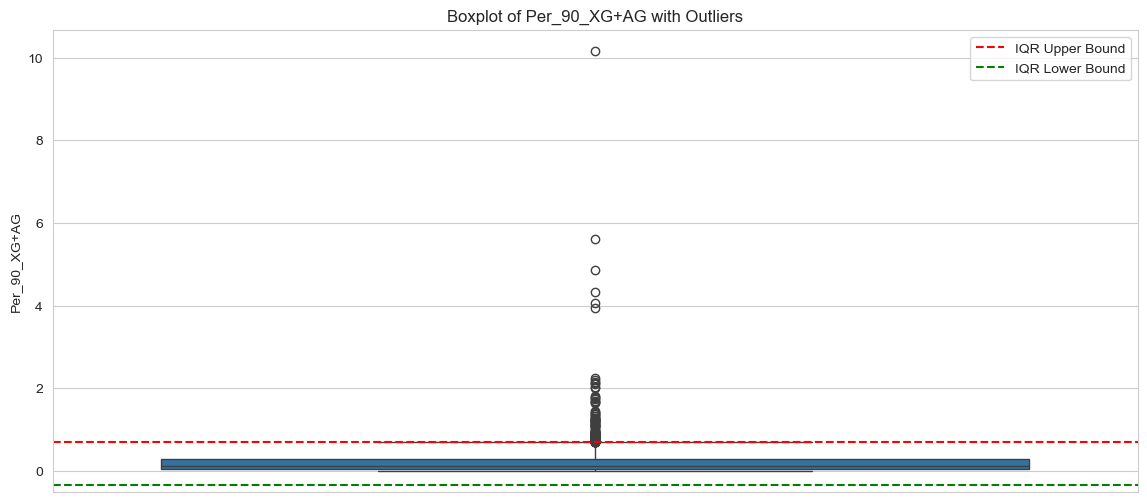

Per_90_npxG: 308 ouliers detected
Outliers: [2.21 0.81 0.85 1.39 3.23 1.57 1.06 0.69 2.03 0.92 1.31 1.27 0.78 1.46
 1.25 0.86 0.99 0.74 1.18 1.41 0.71 0.91 0.7  0.74 1.34 0.7  1.08 1.2
 1.47 0.99 1.8  0.76 0.72 1.44 0.82 0.85 0.86 0.94 0.92 1.38 0.73 0.72
 3.94 0.7  1.77 0.92 4.07 2.15 1.29 0.46 0.63 0.56 0.44 0.53 0.58 0.44
 0.41 0.41 0.44 0.61 0.54 0.46 0.55 0.45 0.4  0.47 0.41 0.43 0.38 0.46
 0.39 0.45 0.49 0.47 0.38 0.55 0.48 0.45 0.39 0.51 0.45 0.58 0.45 0.48
 0.55 0.44 0.61 0.59 0.43 0.53 0.61 0.45 0.51 0.56 0.37 0.4  0.42 0.45
 0.46 0.37 0.41 0.48 0.52 0.51 0.5  0.52 0.44 0.43 0.39 0.65 0.39 0.56
 0.45 0.52 0.41 0.52 0.39 0.6  0.46 0.57 0.41 0.53 0.53 0.61 0.62 0.41
 0.37 0.39 0.39 0.58 0.49 0.61 0.41 0.41 0.48 0.51 0.47 0.65 0.64 0.4
 0.55 0.46 0.37 0.57 0.58 0.42 0.51 0.37 0.45 0.5  0.44 0.46 0.38 0.43
 0.4  0.42 0.37 0.68 0.57 0.5  0.46 0.58 0.37 0.6  0.48 0.49 0.42 0.51
 0.4  0.43 0.49 0.44 0.4  0.39 0.38 0.49 0.45 0.38 0.4  0.45 0.38 0.47
 0.5  0.39 0.47 0.51 0.38 0.44 0.54

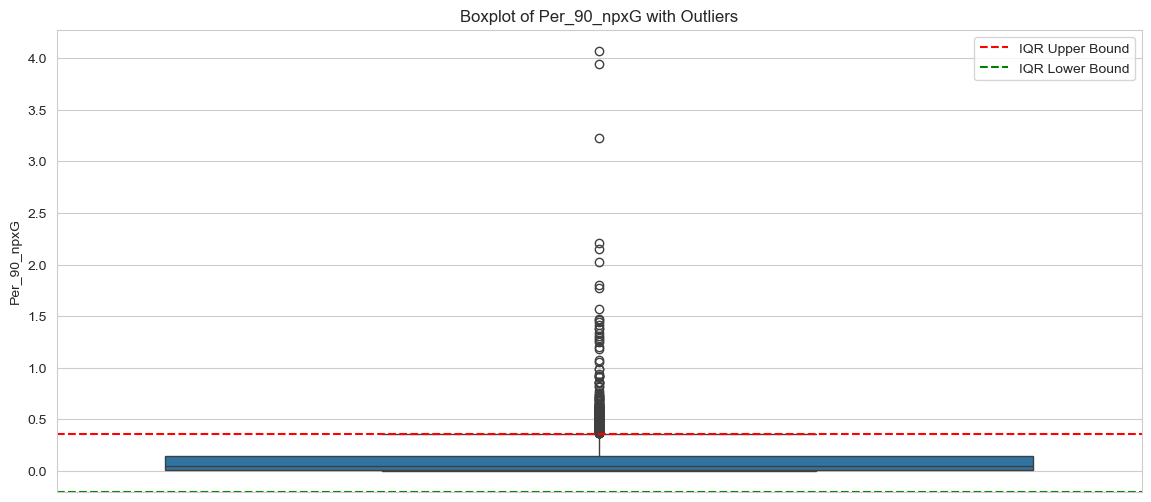

Per_90_npxG+AG: 146 ouliers detected
Outliers: [ 4.87  1.38  1.44  1.27  2.13  1.15  1.2   1.18  1.13  1.74  2.11 10.16
  1.29  1.11  1.14  1.24  1.43  1.34  1.65  1.77  2.26  4.07  1.67  1.33
  1.41  1.39  1.29  1.14  2.21  1.82  3.94  1.7   1.22  4.33  2.01  2.03
  5.61  2.15  1.14  1.8   1.25  0.68  0.83  0.8   0.68  0.97  0.7   0.74
  0.73  0.68  0.69  0.87  0.94  0.76  0.67  0.69  0.93  0.79  0.73  0.96
  0.67  0.7   0.74  0.92  0.91  0.71  0.68  0.91  0.78  0.86  0.81  0.71
  0.88  0.7   0.72  0.68  0.73  0.8   0.85  0.73  0.75  0.73  0.84  0.67
  1.06  0.75  0.85  0.71  0.84  0.73  0.86  0.72  0.71  0.78  0.71  0.74
  0.78  0.69  1.03  0.7   0.68  0.75  0.76  0.78  0.69  0.67  0.81  0.78
  1.06  0.94  0.67  0.79  0.73  0.76  0.74  0.82  0.68  0.8   0.94  0.79
  0.74  0.68  0.8   0.71  0.85  0.75  0.69  0.68  0.73  0.78  0.68  0.89
  0.9   0.68  0.72  0.69  0.94  0.76  0.76  0.67  0.68  0.99  0.81  0.87
  0.83  0.76]



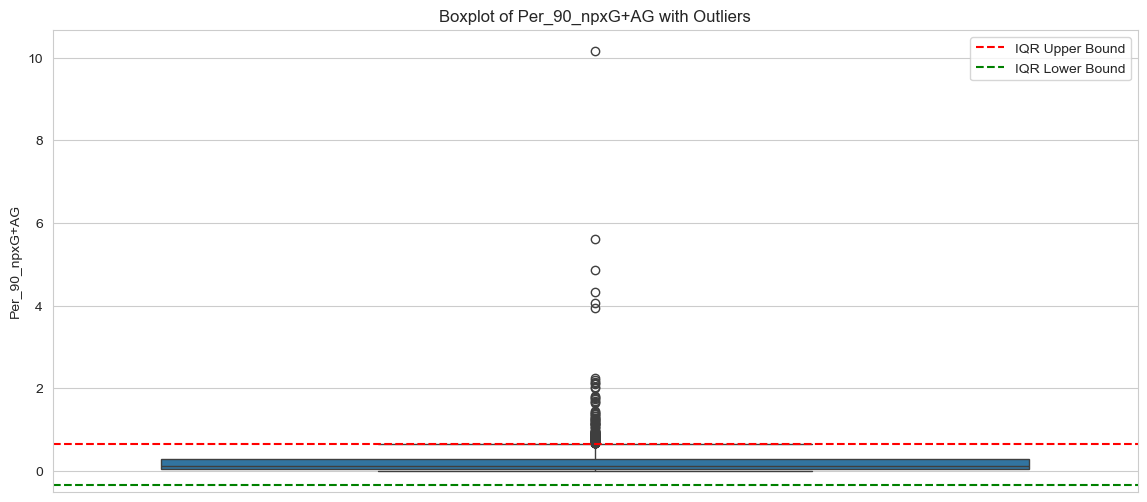

Age: 8 outliers
Born: 5 outliers
Perf_Gls: 523 outliers
Perf_Ast: 259 outliers
Perf_G+A: 389 outliers
Perf_G-PK: 461 outliers
Perf_PK: 472 outliers
Perf_PKatt: 582 outliers
Perf_CrdY: 127 outliers
Perf_CrdR: 879 outliers
Exp_xG: 490 outliers
Exp_npxG: 444 outliers
Exp_xAG: 302 outliers
Exp_npxG+xAG: 350 outliers
Prog_PrgC: 300 outliers
Prog_PrgP: 163 outliers
Prog_PrgR: 242 outliers
Per_90_Gls: 626 outliers
Per_90_Ast: 360 outliers
Per_90_G+A: 314 outliers
Per_90_G-PK: 600 outliers
Per_90_G+A-PK: 296 outliers
Per_90_xG: 366 outliers
Per_90_XAG: 161 outliers
Per_90_XG+AG: 149 outliers
Per_90_npxG: 308 outliers
Per_90_npxG+AG: 146 outliers


In [1586]:
detect_outliers_democratic(players)

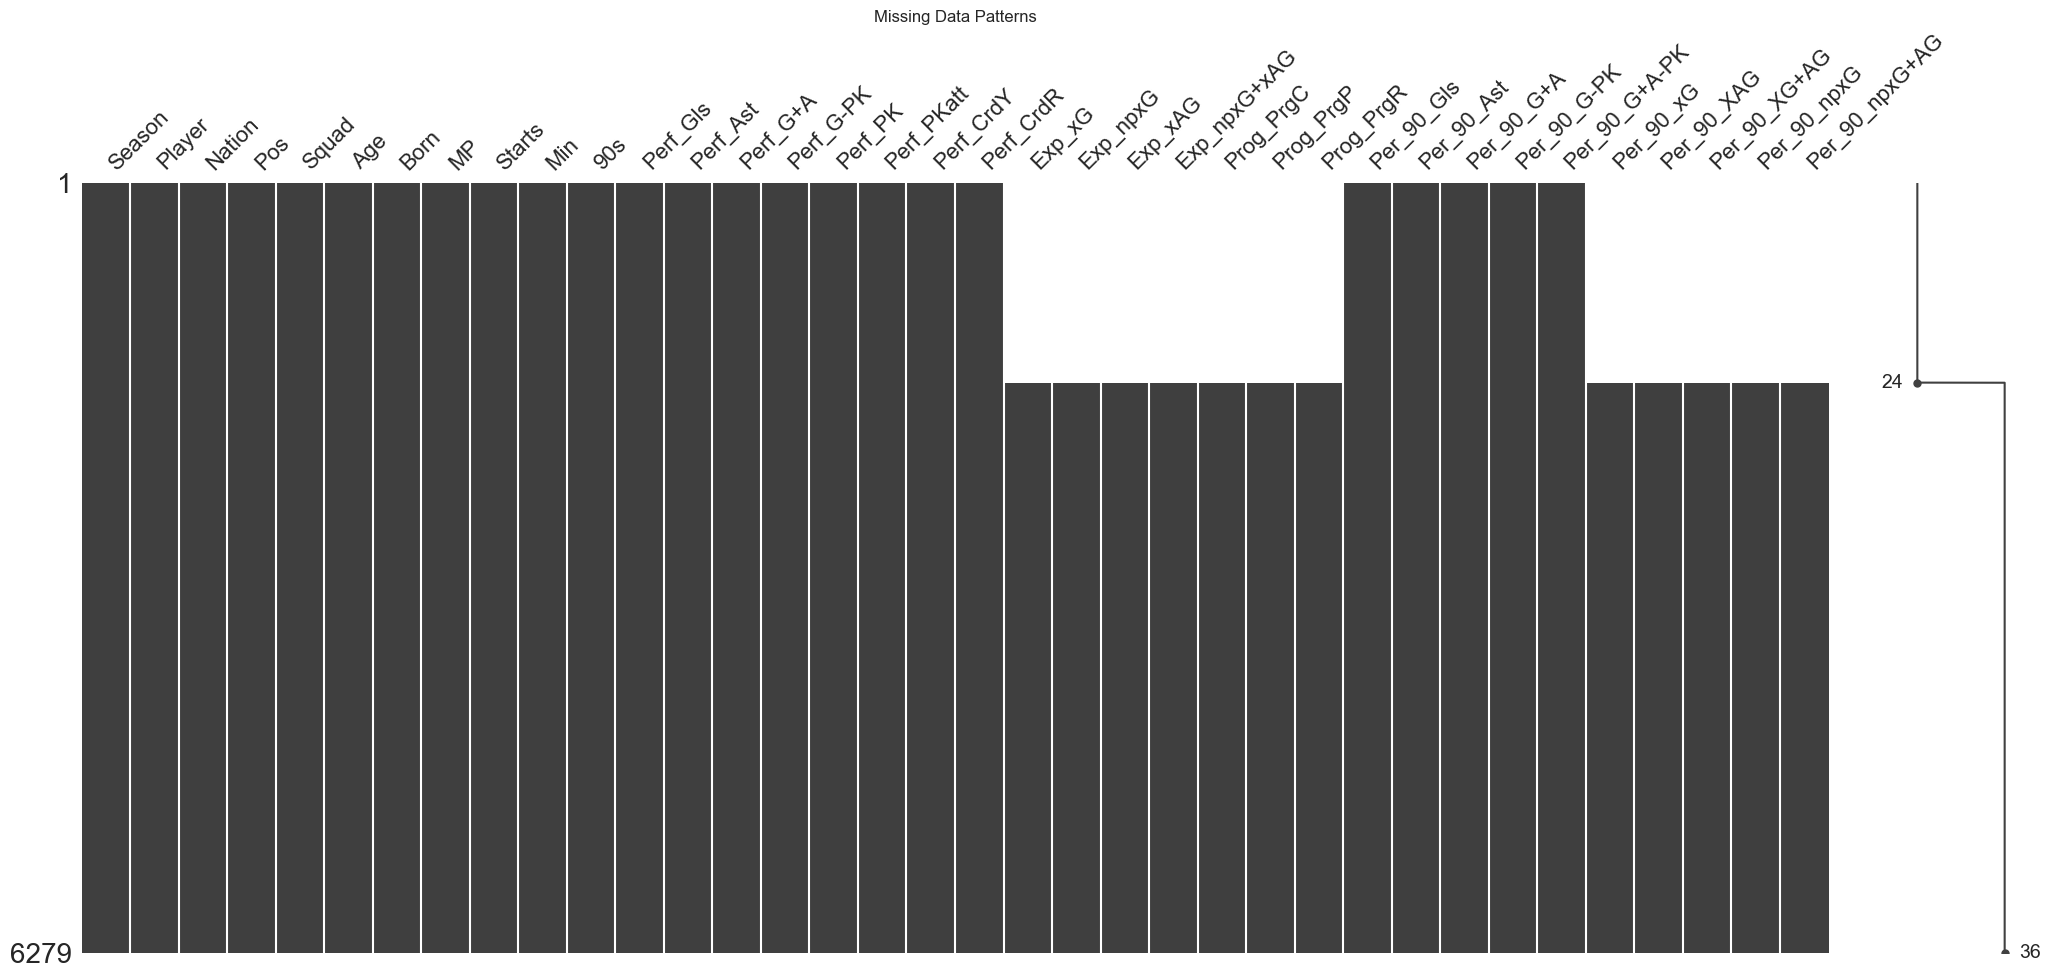

In [1228]:
visualize_missing_patterns(players)

In [1588]:
# Analysing the the null rows for Age
players[players['Age'].isnull()]

Season        Player  Nation Pos    Squad  Age  Born  MP  Starts  Min  \
5651   2023  Max Svensson  es ESP  FW  Osasuna  NaN   NaN   1       0    3   
6015   2024     Fer López     NaN  FW    Celta  NaN   NaN   5       2  144   

      ...  Per_90_Gls  Per_90_Ast  Per_90_G+A  Per_90_G-PK  Per_90_G+A-PK  \
5651  ...         0.0         0.0         0.0          0.0            0.0   
6015  ...         0.0         0.0         0.0          0.0            0.0   

      Per_90_xG  Per_90_XAG  Per_90_XG+AG  Per_90_npxG  Per_90_npxG+AG  
5651       0.00        0.00          0.00         0.00            0.00  
6015       0.11        0.38          0.49         0.11            0.49  

[2 rows x 36 columns]

In [1590]:
# we can remove the two rows as they carry less information as the Mins, MP and starts are very less
players = players.dropna(axis=0, subset=['Age'])

### Visualizations

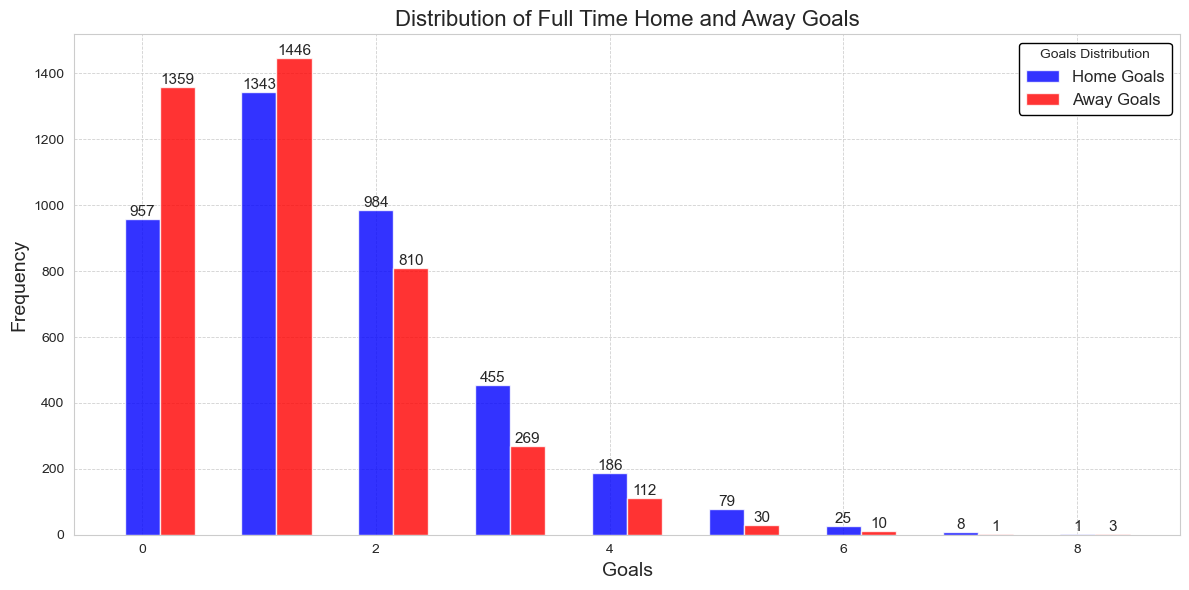

In [511]:
# Distribution of Full Time Home and Away Goals
home_goals = matches['FTHG'].value_counts().sort_index()[:9]
away_goals = matches['FTAG'].value_counts().sort_index()[:9]

x_index = home_goals.index
bar_width = 0.3

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

home_bar = plt.bar(x_index, home_goals, bar_width, label='Home Goals', color='blue', alpha=0.8)
away_bar = plt.bar(x_index + bar_width, away_goals, bar_width, label='Away Goals', color='red', alpha=0.8)

for bar in home_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=11)

for bar in away_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=11)

plt.xlabel('Goals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Full Time Home and Away Goals', fontsize=16)

plt.legend(loc='upper right', framealpha=1, frameon=True, title='Goals Distribution', fontsize=12, edgecolor = 'black')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

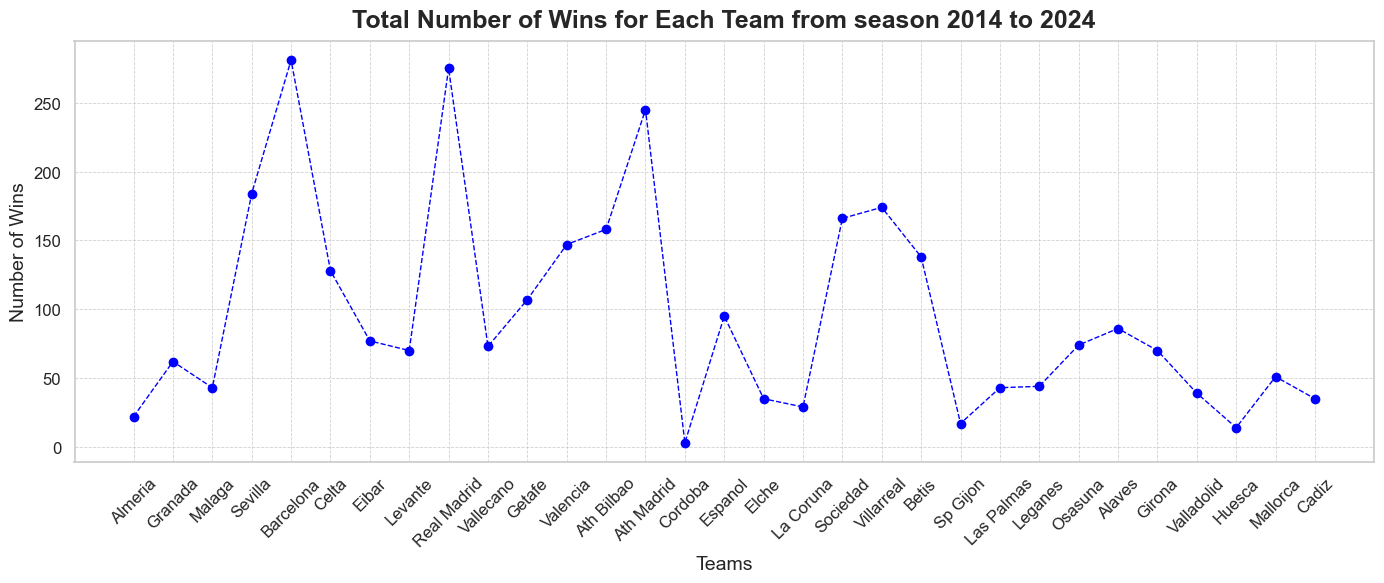

In [1703]:
# Total Number of Wins for Each Team from season 2014 to 2024

team_list = list(matches['Team'].unique())
team_win_dic = {}
team = []
for team in team_list:
    win_cnt = 0
    for i in range(len(matches)):
        if matches['FTR'][i] == 'H' and matches['HomeTeam'][i] == team:
            win_cnt += 1
        elif matches['FTR'][i] == 'A' and matches['AwayTeam'][i] == team:
            win_cnt += 1
               
    team_win_dic[team] = win_cnt
    
teams_win = team_win_dic.items()
team_win = pd.DataFrame(teams_win, columns=['Team','Number of Wins'])

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

plt.plot(team_win['Team'], team_win['Number of Wins'], marker='o', linestyle='--', color='blue', markersize=6, linewidth=1)

plt.title('Total Number of Wins for Each Team from season 2014 to 2024', fontsize=18, fontweight='bold', pad=10)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Number of Wins', fontsize=14)

plt.xticks(rotation=45, ha='center', fontsize=12)
plt.yticks(fontsize=12)    
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

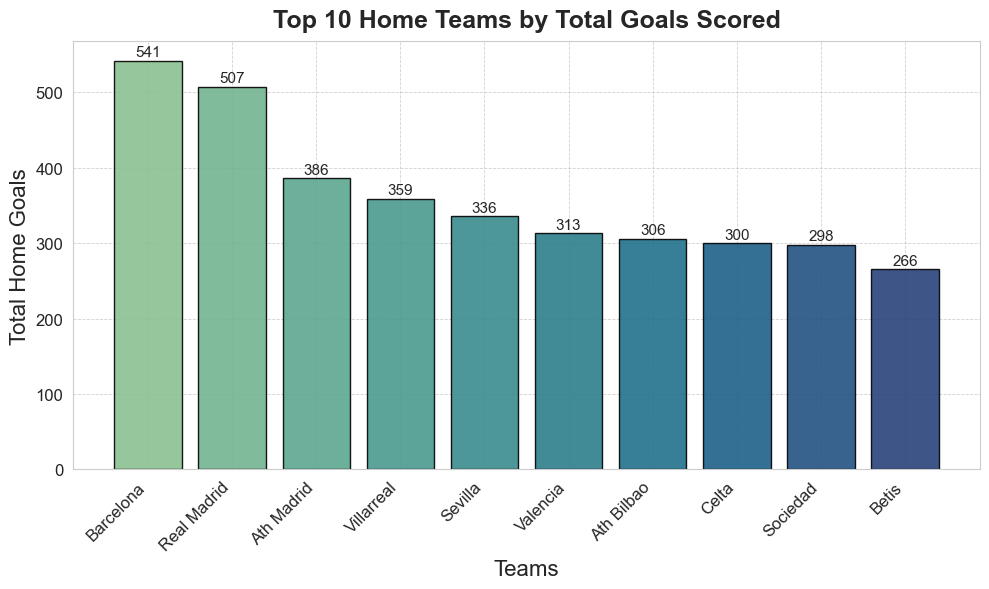

In [637]:
# Top 10 Home Teams by Total Goals Scored
home_goals = matches.groupby('HomeTeam')['FTHG'].sum().reset_index()
top_home_teams = home_goals.sort_values(by='FTHG', ascending=False).head(10)

sns.set_style("whitegrid")
colors = sns.color_palette("crest", len(top_home_teams))

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
bars = plt.bar(top_home_teams['HomeTeam'], top_home_teams['FTHG'], color=colors, edgecolor='black', alpha=0.9)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval*1.005, int(yval), ha='center', va = 'bottom', fontsize=11)

plt.title('Top 10 Home Teams by Total Goals Scored', fontsize=18, fontweight='bold', pad=10)
plt.xlabel('Teams', fontsize=16)
plt.ylabel('Total Home Goals', fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)    
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

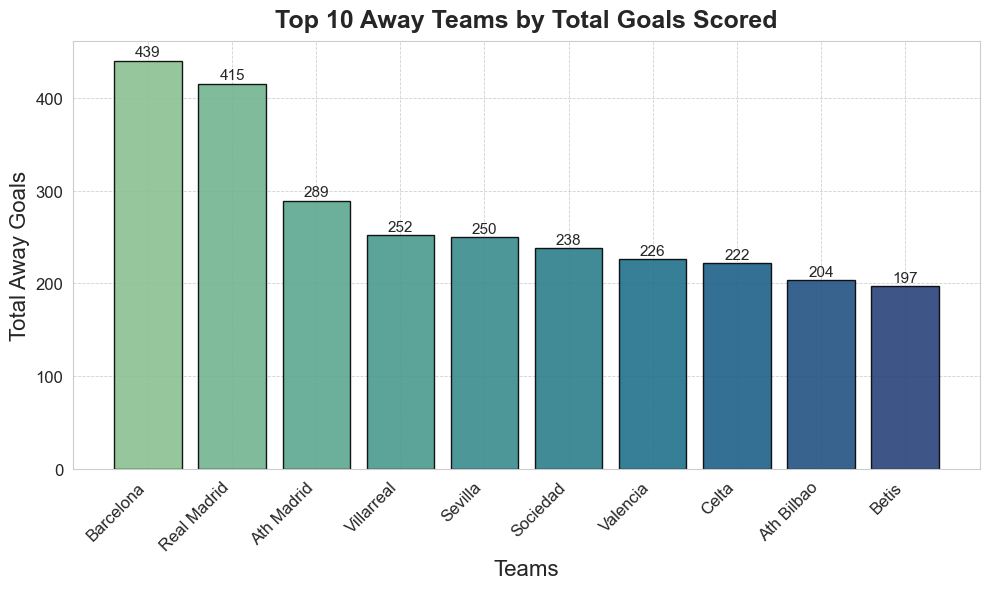

In [639]:
# Top 10 Away Teams by Total Goals Scored
away_goals = matches.groupby('AwayTeam')['FTAG'].sum().reset_index()
top_away_teams = away_goals.sort_values(by='FTAG', ascending=False).head(10)

sns.set_style("whitegrid")
colors = sns.color_palette("crest", len(top_away_teams))

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
bars = plt.bar(top_away_teams['AwayTeam'], top_away_teams['FTAG'], color=colors, edgecolor='black', alpha=0.9)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval*1.005, int(yval), ha='center', va = 'bottom', fontsize=11)

plt.title('Top 10 Away Teams by Total Goals Scored', fontsize=18, fontweight='bold', pad=10)
plt.xlabel('Teams', fontsize=16)
plt.ylabel('Total Away Goals', fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)    
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

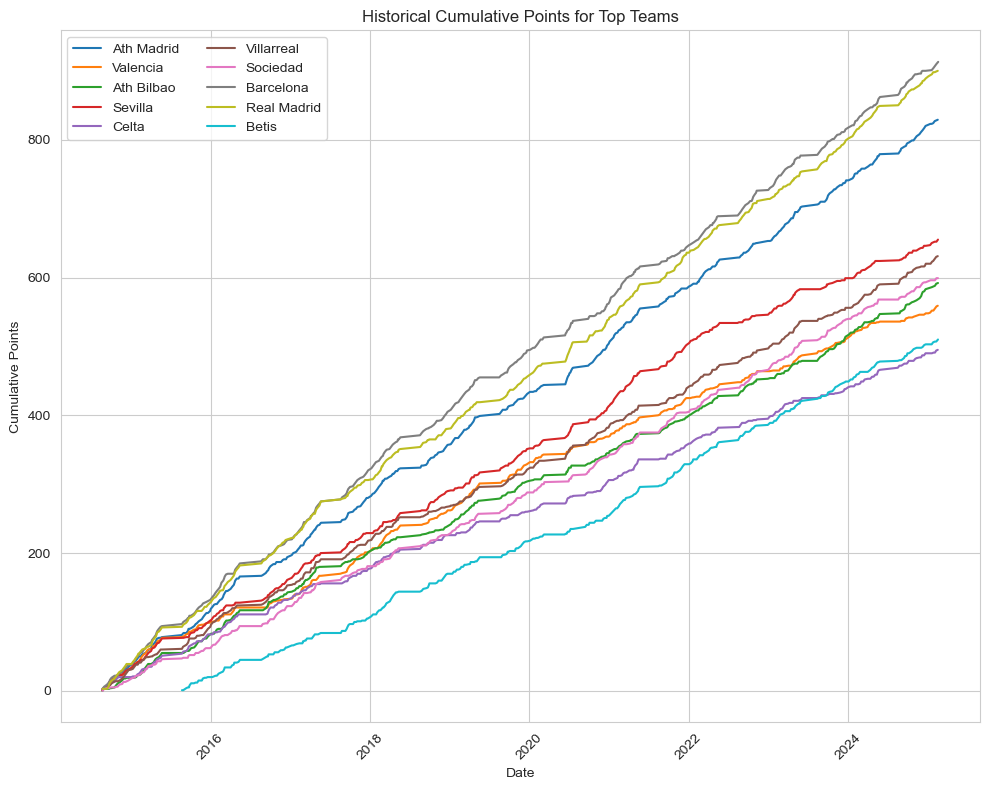

In [743]:
# Historical Cumulative Points for Top Teams

teams = matches['Team'].value_counts().head(10).index

def calculate_points(df, team):
    if df['HomeTeam'] == team:
        if df['FTR'] == 'H':
            return 3
        elif df['FTR'] == 'D':
            return 1
        else:
            return 0
    else:
        if df['FTR'] == 'A':
            return 3
        elif df['FTR'] == 'D':
            return 1
        else:
            return 0

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
for team in teams:
    team_data = matches[(matches['HomeTeam'] == team) | (matches['AwayTeam'] == team) ].sort_values('Date')
    team_data['Points'] = team_data.apply(lambda row: calculate_points(row, team), axis=1)
    team_data['CumulativePoints'] = team_data['Points'].cumsum()
    plt.plot(team_data['Date'], team_data['CumulativePoints'], label=team)

plt.title('Historical Cumulative Points for Top Teams')
plt.xlabel('Date')
plt.ylabel('Cumulative Points')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

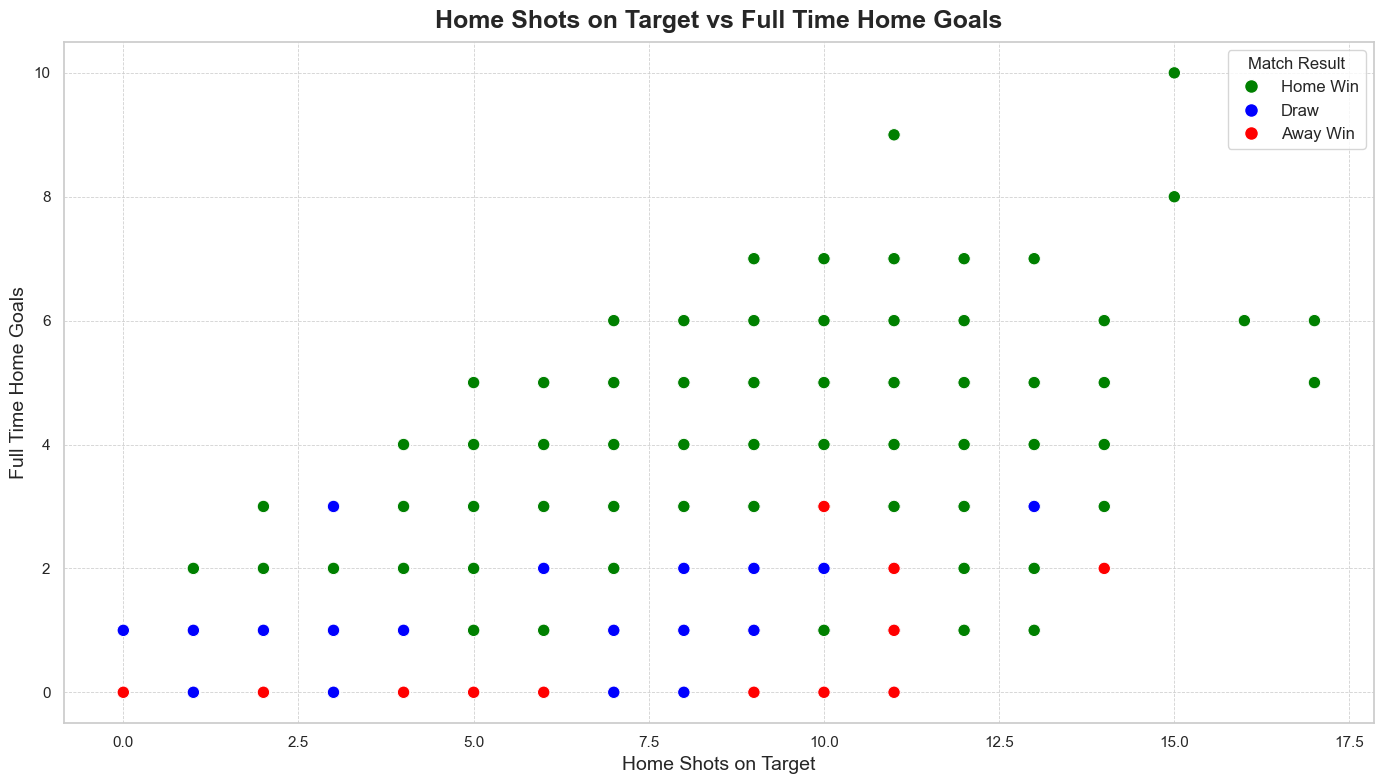

In [1707]:
# Home Shots on Target vs Full Time Home Goals

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

sns.scatterplot(x='HST', y='FTHG', data=matches, hue='FTR', palette={'H': 'green', 'D': 'blue', 'A': 'red'}, s=80)

plt.title('Home Shots on Target vs Full Time Home Goals', fontsize=18, fontweight='bold', pad=10)
plt.xlabel('Home Shots on Target', fontsize=14)
plt.ylabel('Full Time Home Goals', fontsize=14)

#custom legend handles for specific match results (Used ChatGPT for this)
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Home Win', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Draw', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Away Win', markerfacecolor='red', markersize=10)]

plt.legend(handles=handles, title='Match Result', loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

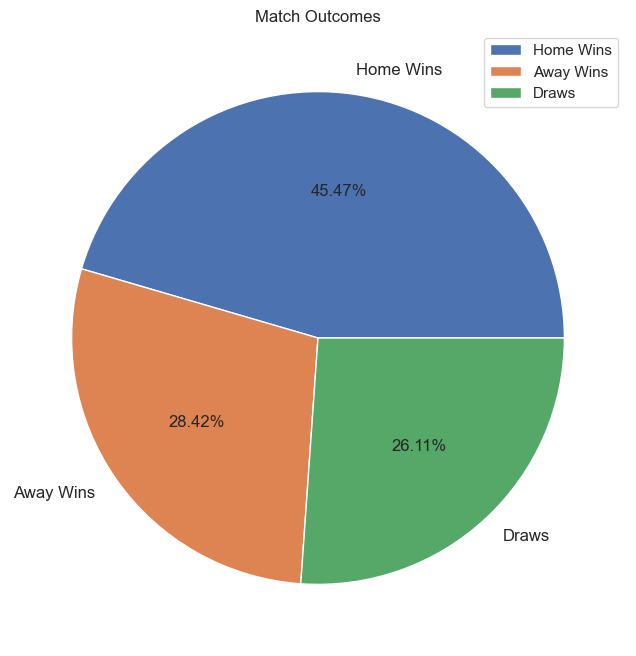

In [1709]:
# Match Outcomes
home_wins = matches[matches['FTR'] == 'H'].shape[0]
away_wins = matches[matches['FTR'] == 'A'].shape[0]
draws = matches[matches['FTR'] == 'D'].shape[0]

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))

plt.pie([home_wins, away_wins, draws], labels=['Home Wins', 'Away Wins', 'Draws'],autopct='%1.2f%%',textprops={'fontsize': 12})
plt.title('Match Outcomes')
plt.legend(loc='upper right')
plt.show()

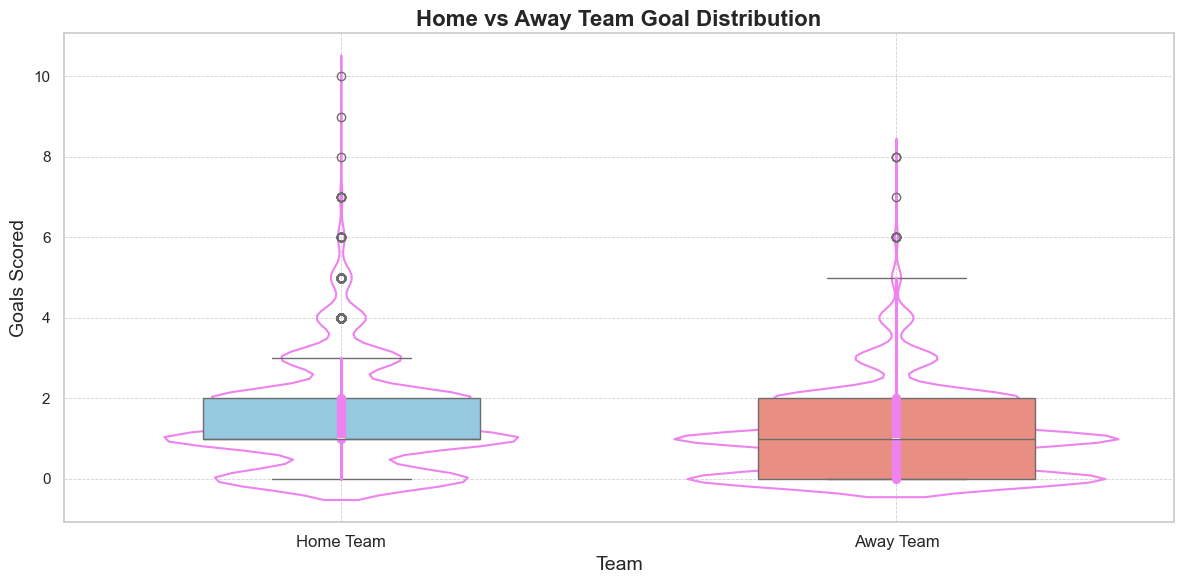

In [1713]:
# Home vs Away Team Goal Distribution

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.boxplot(data=matches[['FTHG', 'FTAG']], palette=["skyblue", "salmon"], width=0.5)
sns.violinplot(data=matches[['FTHG', 'FTAG']], color='violet',fill=False, bw_method='silverman')

plt.title('Home vs Away Team Goal Distribution', fontsize=16, fontweight='bold', pad=5)
plt.xlabel('Team', fontsize=14)
plt.ylabel('Goals Scored', fontsize=14)

plt.xticks([0, 1], ['Home Team', 'Away Team'], fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.tight_layout()
plt.show()

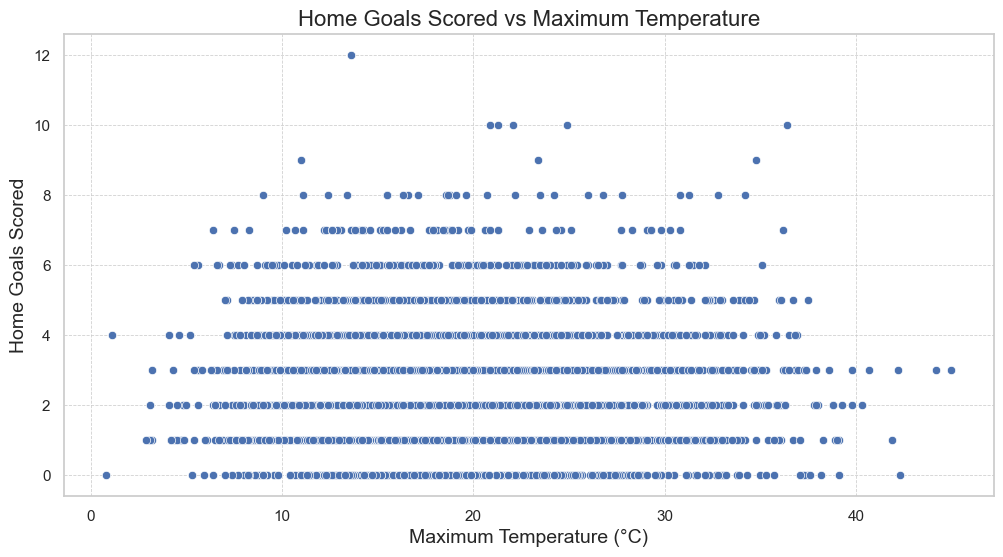

In [1711]:
# Plotting Home Goals vs Max Temperature

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
matches['TotalGoals'] = matches['FTHG'] + matches['FTAG']

sns.scatterplot(x='max_temp', y='TotalGoals', data=matches)

plt.title('Home Goals Scored vs Maximum Temperature', fontsize=16)
plt.xlabel('Maximum Temperature (°C)', fontsize=14)
plt.ylabel('Home Goals Scored', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)
plt.show()

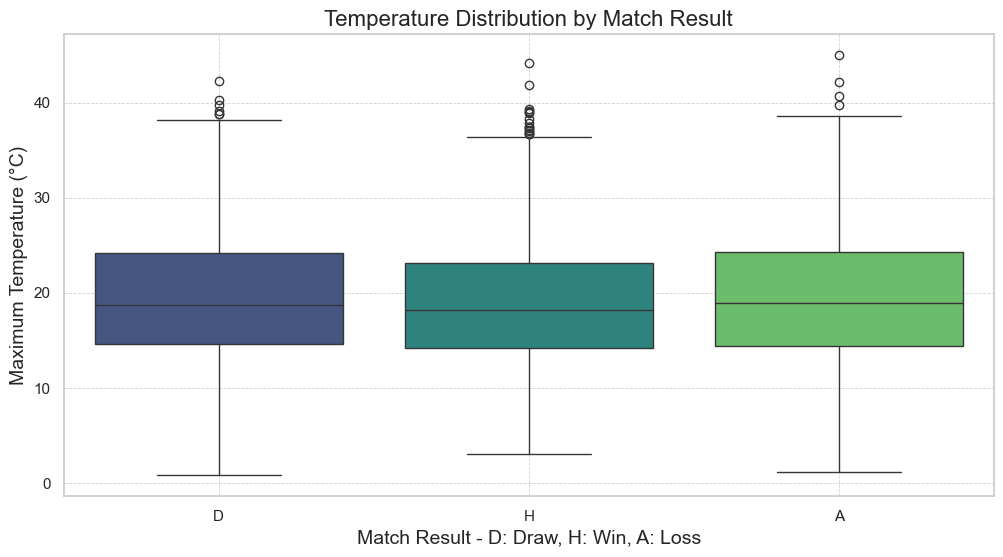

In [1642]:
# Temperature Distribution by Match Result
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='FTR', y='max_temp', data=matches, hue='FTR', palette="viridis")

plt.title('Temperature Distribution by Match Result', fontsize=16)
plt.xlabel('Match Result - D: Draw, H: Win, A: Loss', fontsize=14)
plt.ylabel('Maximum Temperature (°C)', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)
plt.show()

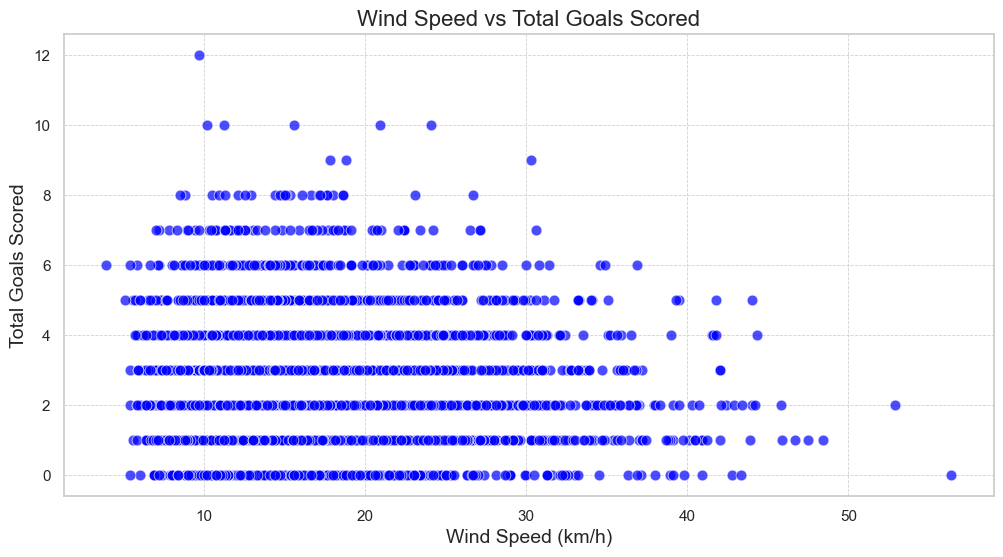

In [1656]:
# Scatter plot of wind speed vs. total goals scored
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.scatterplot(x='wind_speed', y='TotalGoals', data=matches, color='blue', alpha=0.7, s=60) 

plt.title('Wind Speed vs Total Goals Scored', fontsize=16)
plt.xlabel('Wind Speed (km/h)', fontsize=14)
plt.ylabel('Total Goals Scored', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)

plt.show()

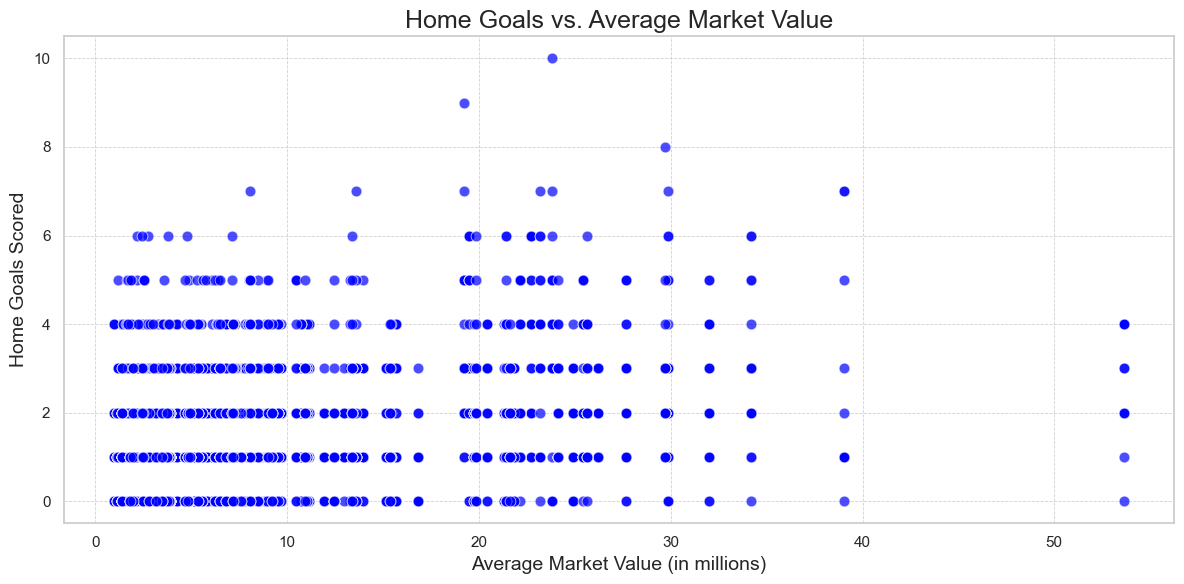

In [1767]:
# Home Goals vs. Average Market Value
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Avg Market Value in millions', y='FTHG', data=matches, color='blue', alpha=0.7, s=60)

plt.title('Home Goals vs. Average Market Value', fontsize=18)
plt.xlabel('Average Market Value (in millions)', fontsize=14)
plt.ylabel('Home Goals Scored', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)
plt.tight_layout()
plt.show()

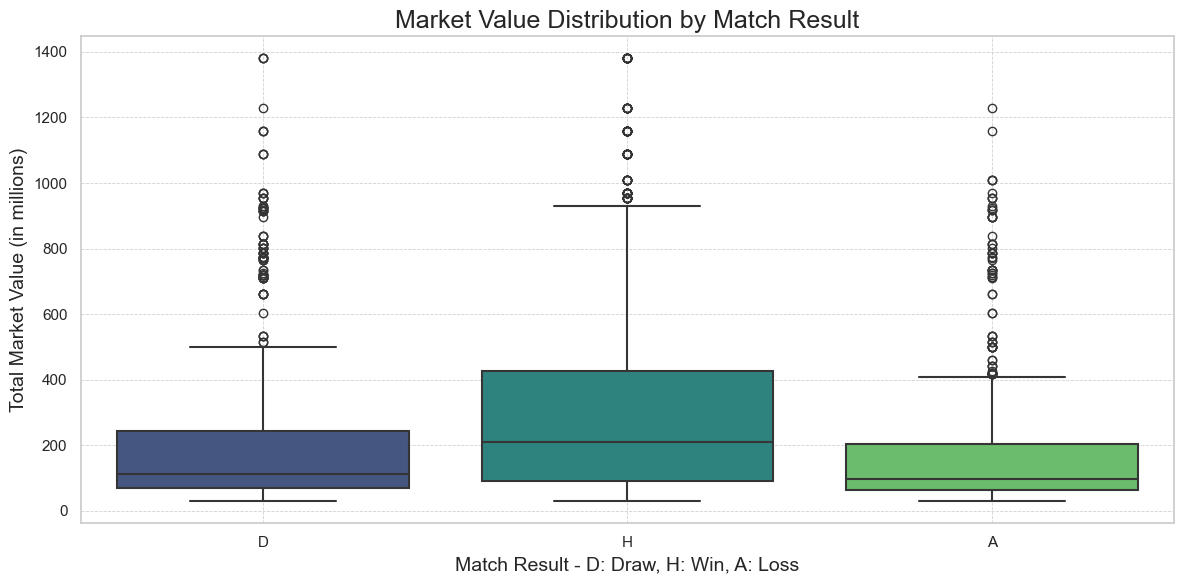

In [1769]:
# Market Value Distribution by Match Result

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(x='FTR', y='Total Market Value in millions', data=matches, hue='FTR', palette="viridis",showcaps=True, linewidth=1.5)

plt.title('Market Value Distribution by Match Result', fontsize=18)
plt.xlabel('Match Result - D: Draw, H: Win, A: Loss', fontsize=14)
plt.ylabel('Total Market Value (in millions)', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

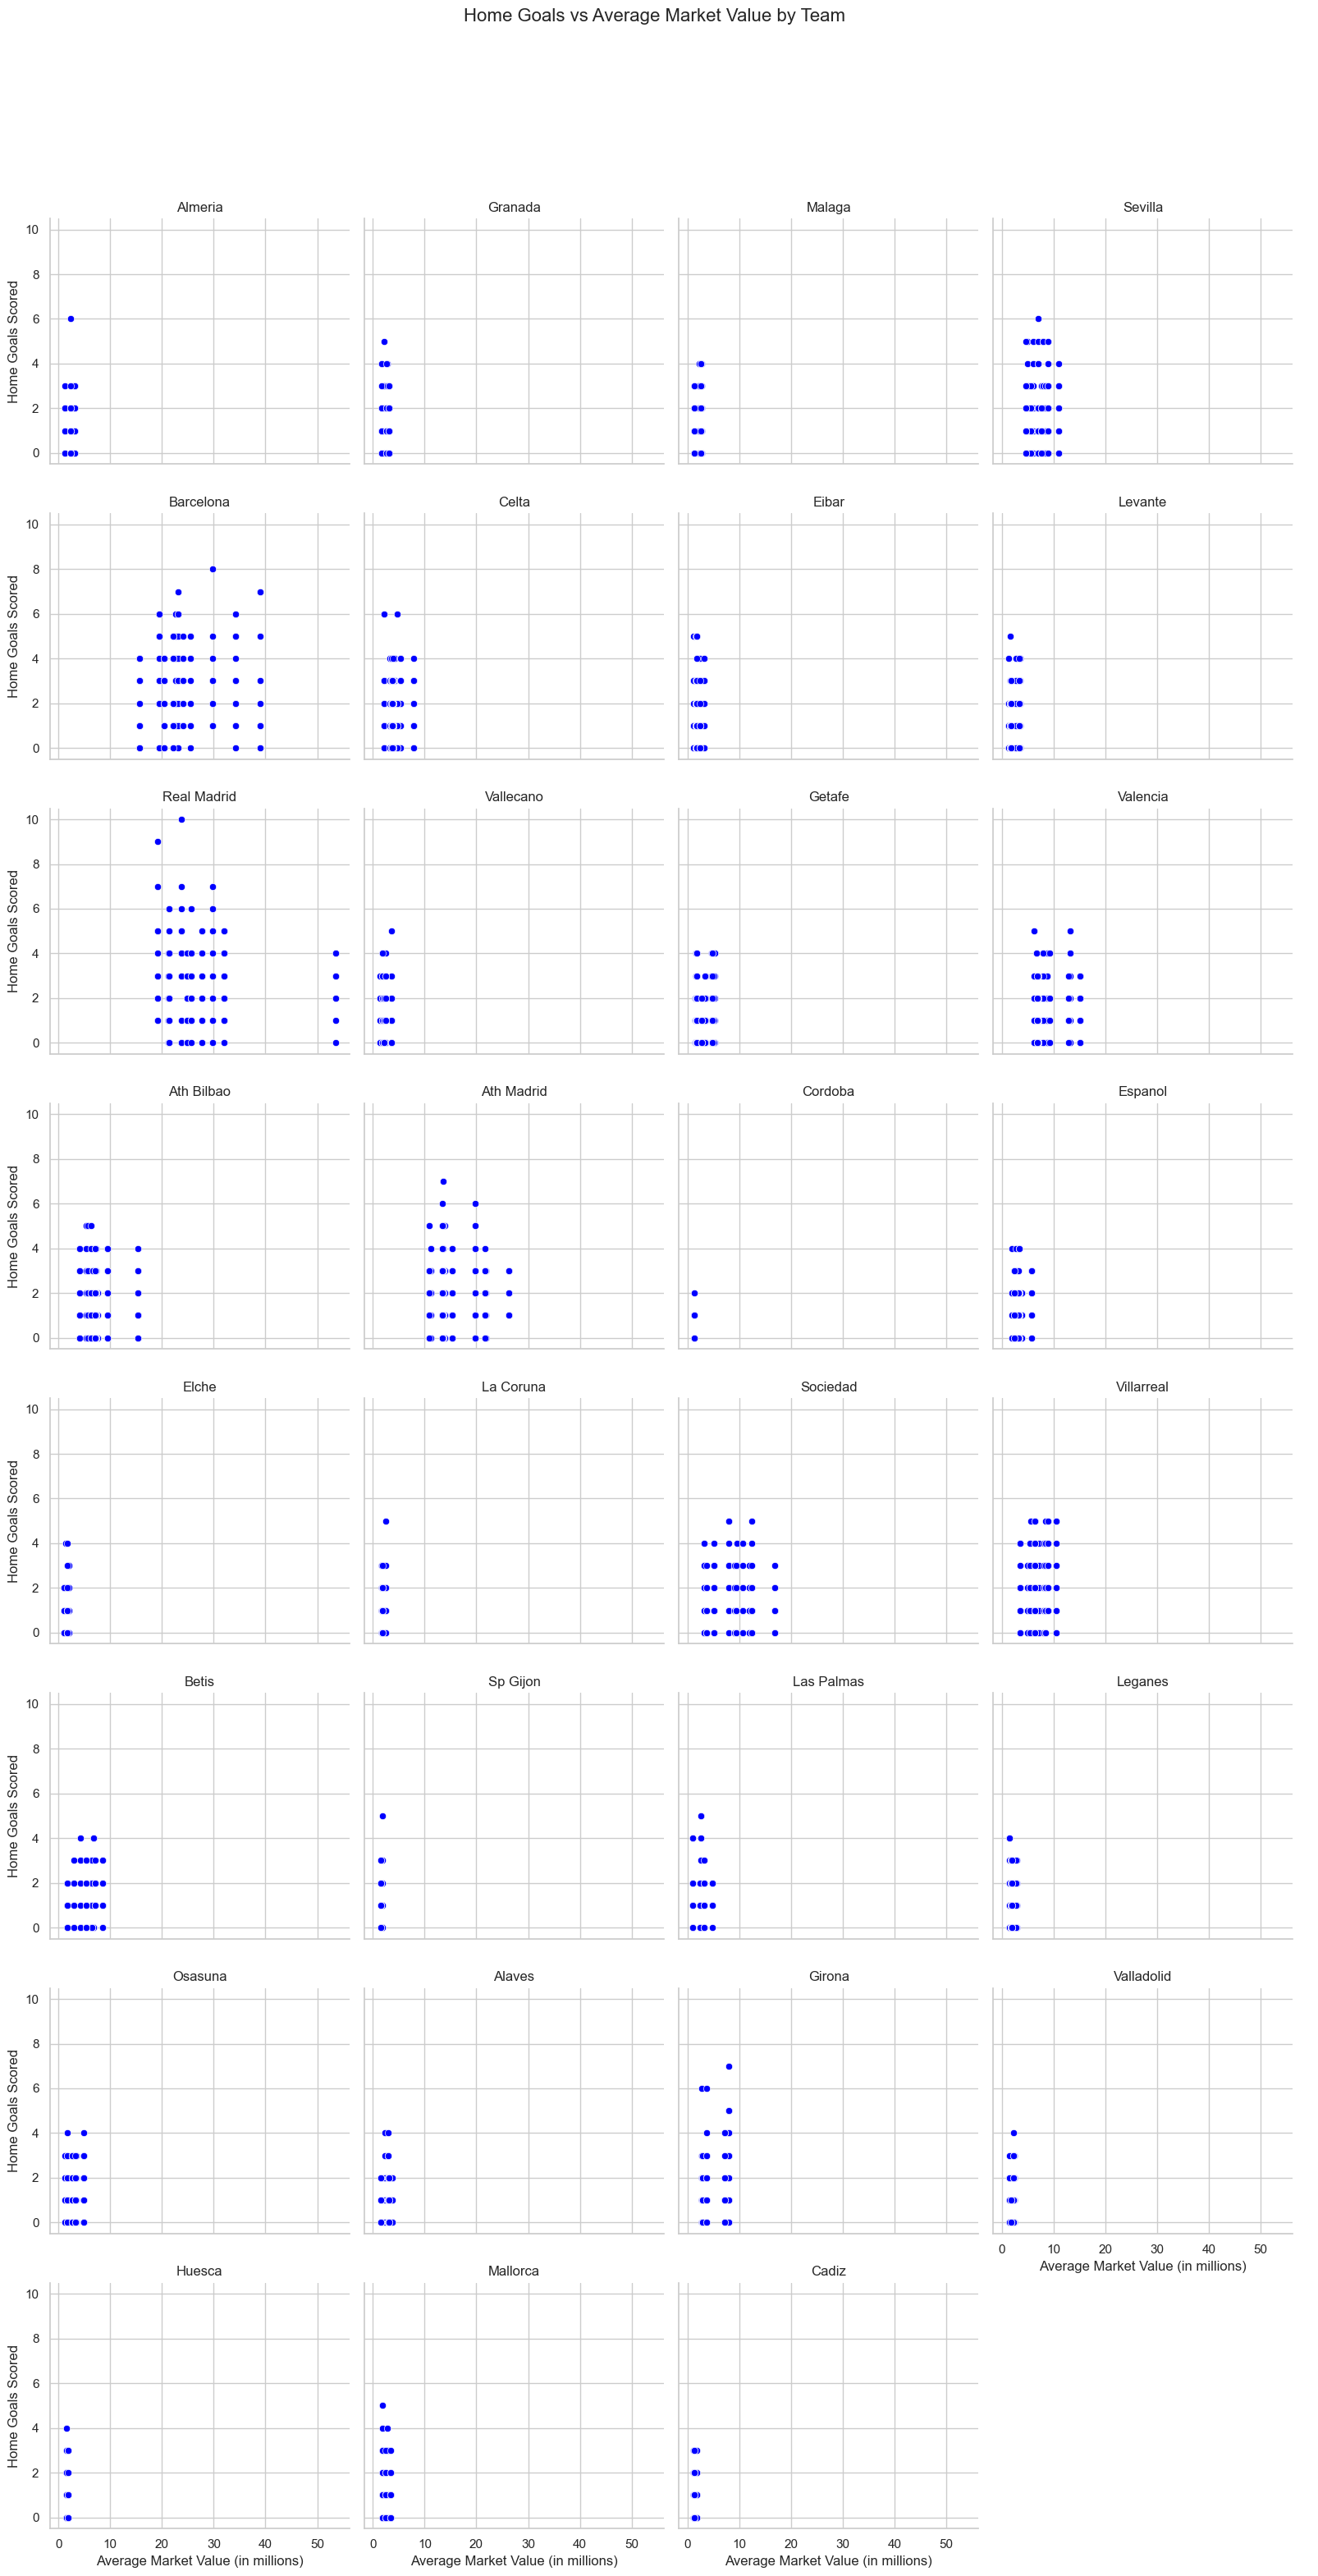

In [1771]:
# Home Goals vs Average Market Value by Team

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

g = sns.FacetGrid(matches, col='Team', col_wrap=4, height=4)
g.map(sns.scatterplot, 'Avg Market Value in millions', 'FTHG', color='blue')

g.add_legend()
g.set_axis_labels('Average Market Value (in millions)', 'Home Goals Scored')
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Home Goals vs Average Market Value by Team', fontsize=16)
plt.subplots_adjust(top=0.9) 
plt.show()

<Figure size 1200x600 with 0 Axes>

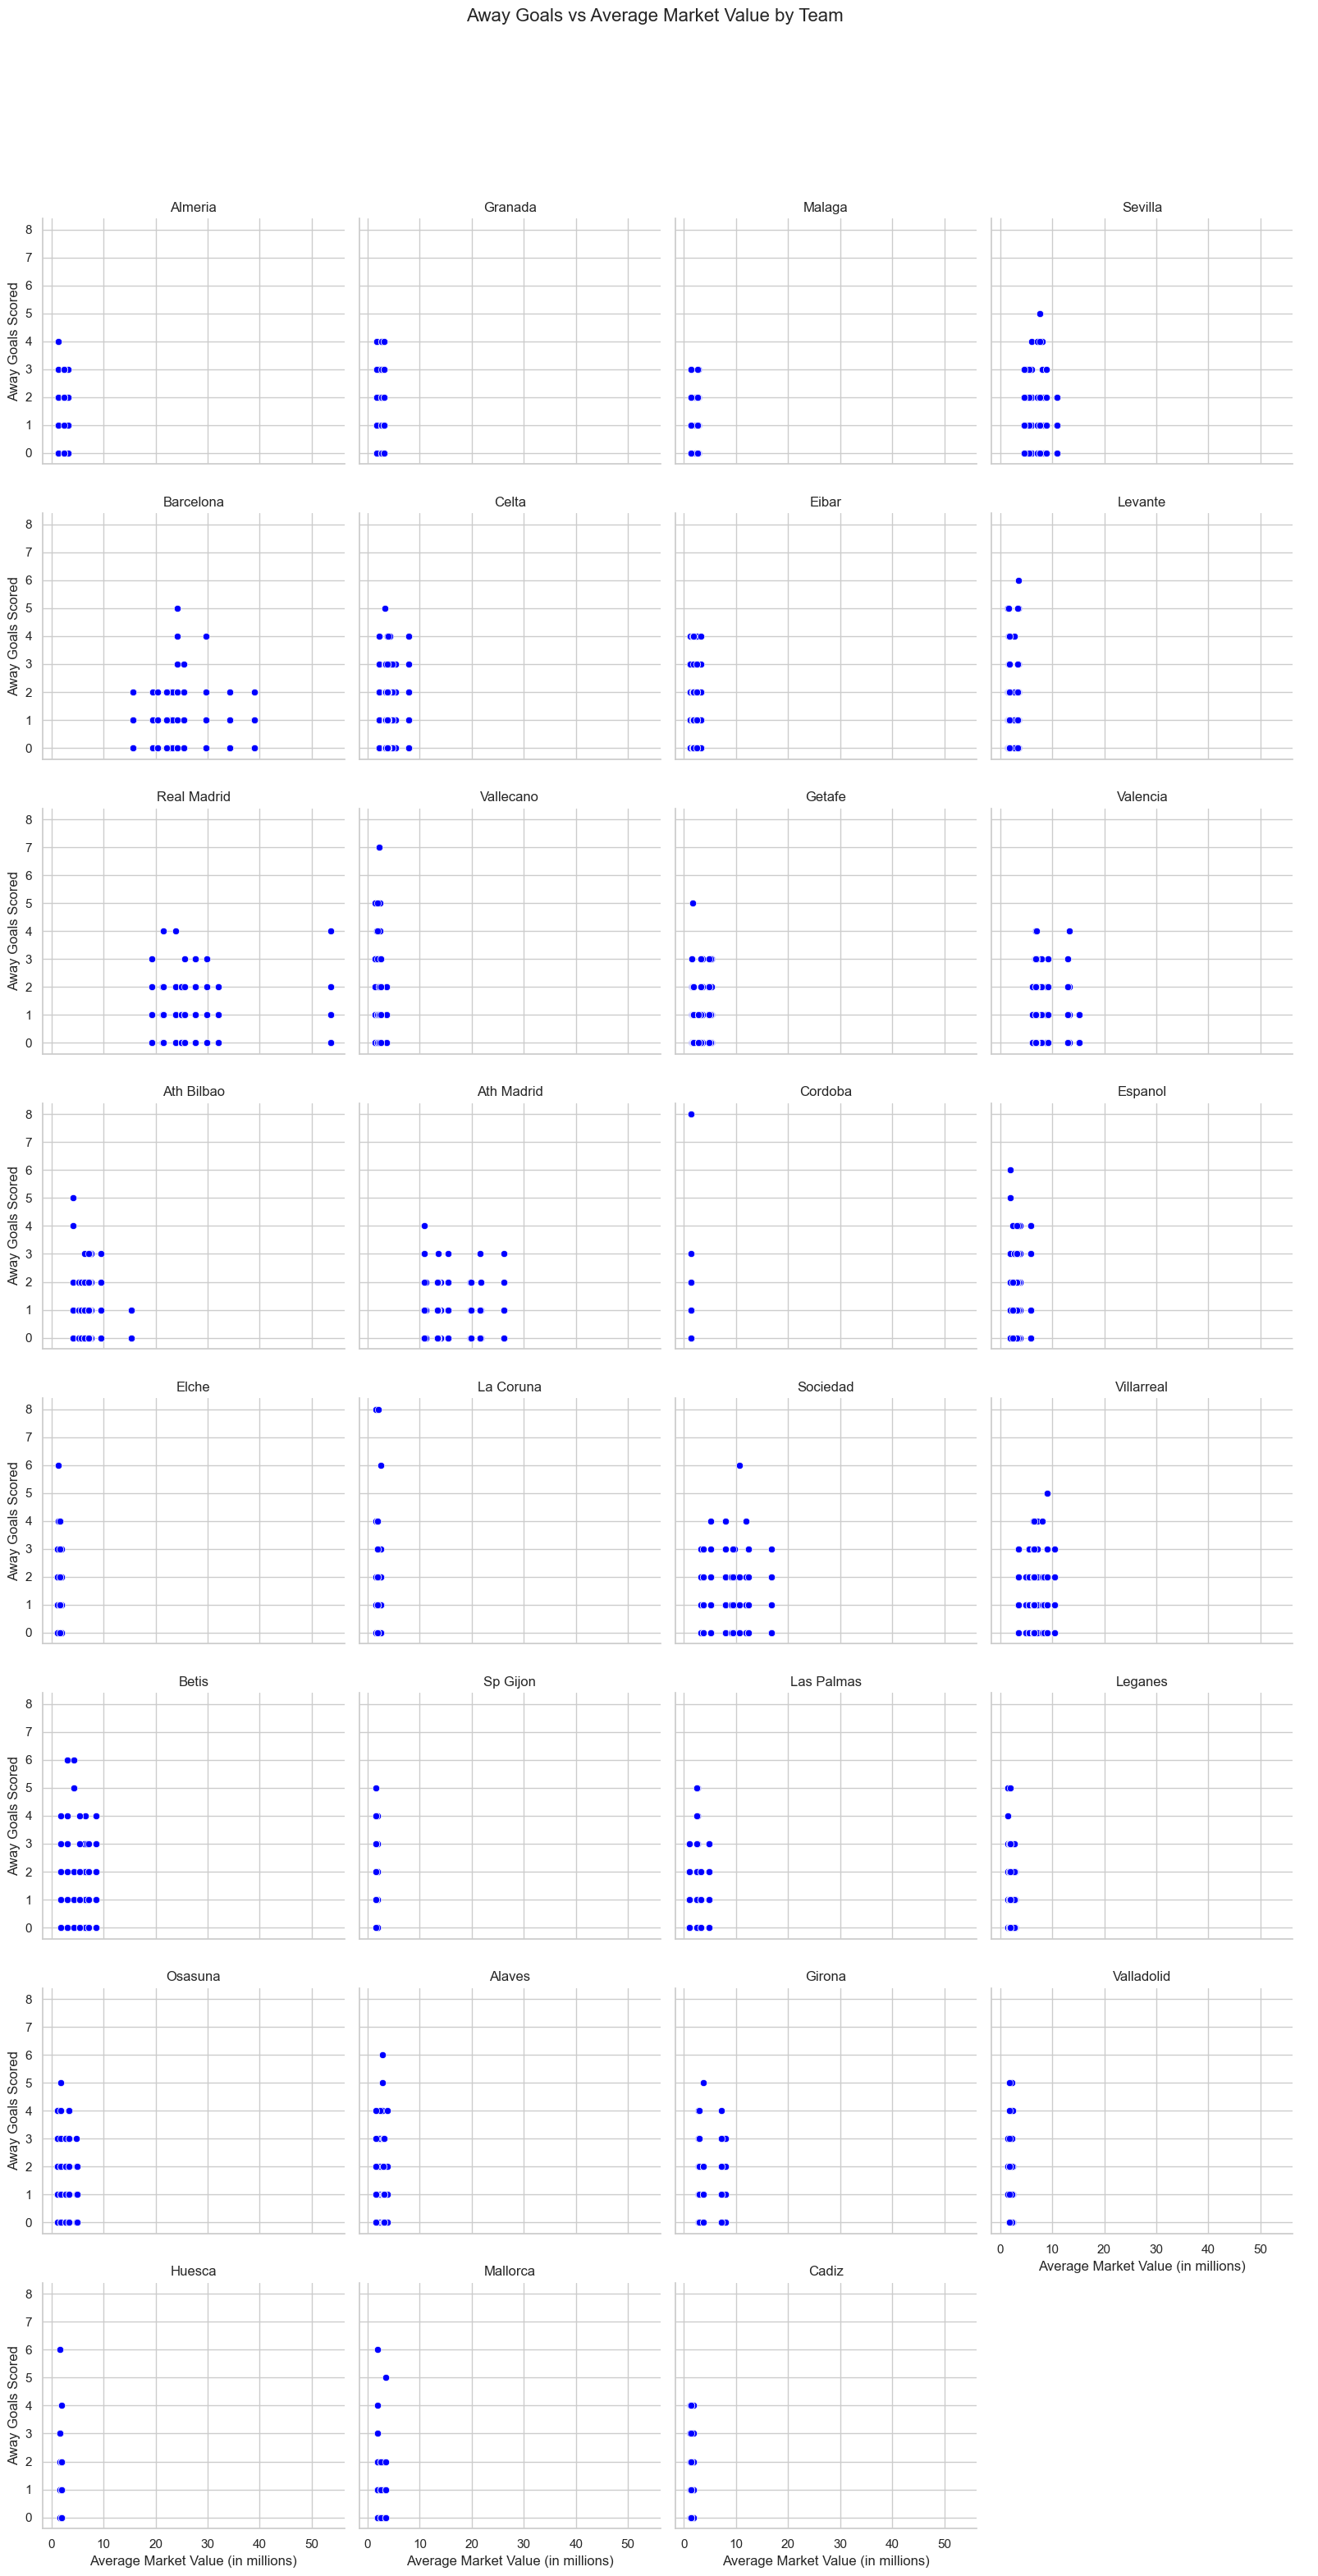

In [1773]:
# Away Goals vs Average Market Value by Team

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

g = sns.FacetGrid(matches, col='Team', col_wrap=4, height=4)
g.map(sns.scatterplot, 'Avg Market Value in millions', 'FTAG', color='blue')

g.add_legend()
g.set_axis_labels('Average Market Value (in millions)', 'Away Goals Scored')
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Away Goals vs Average Market Value by Team', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

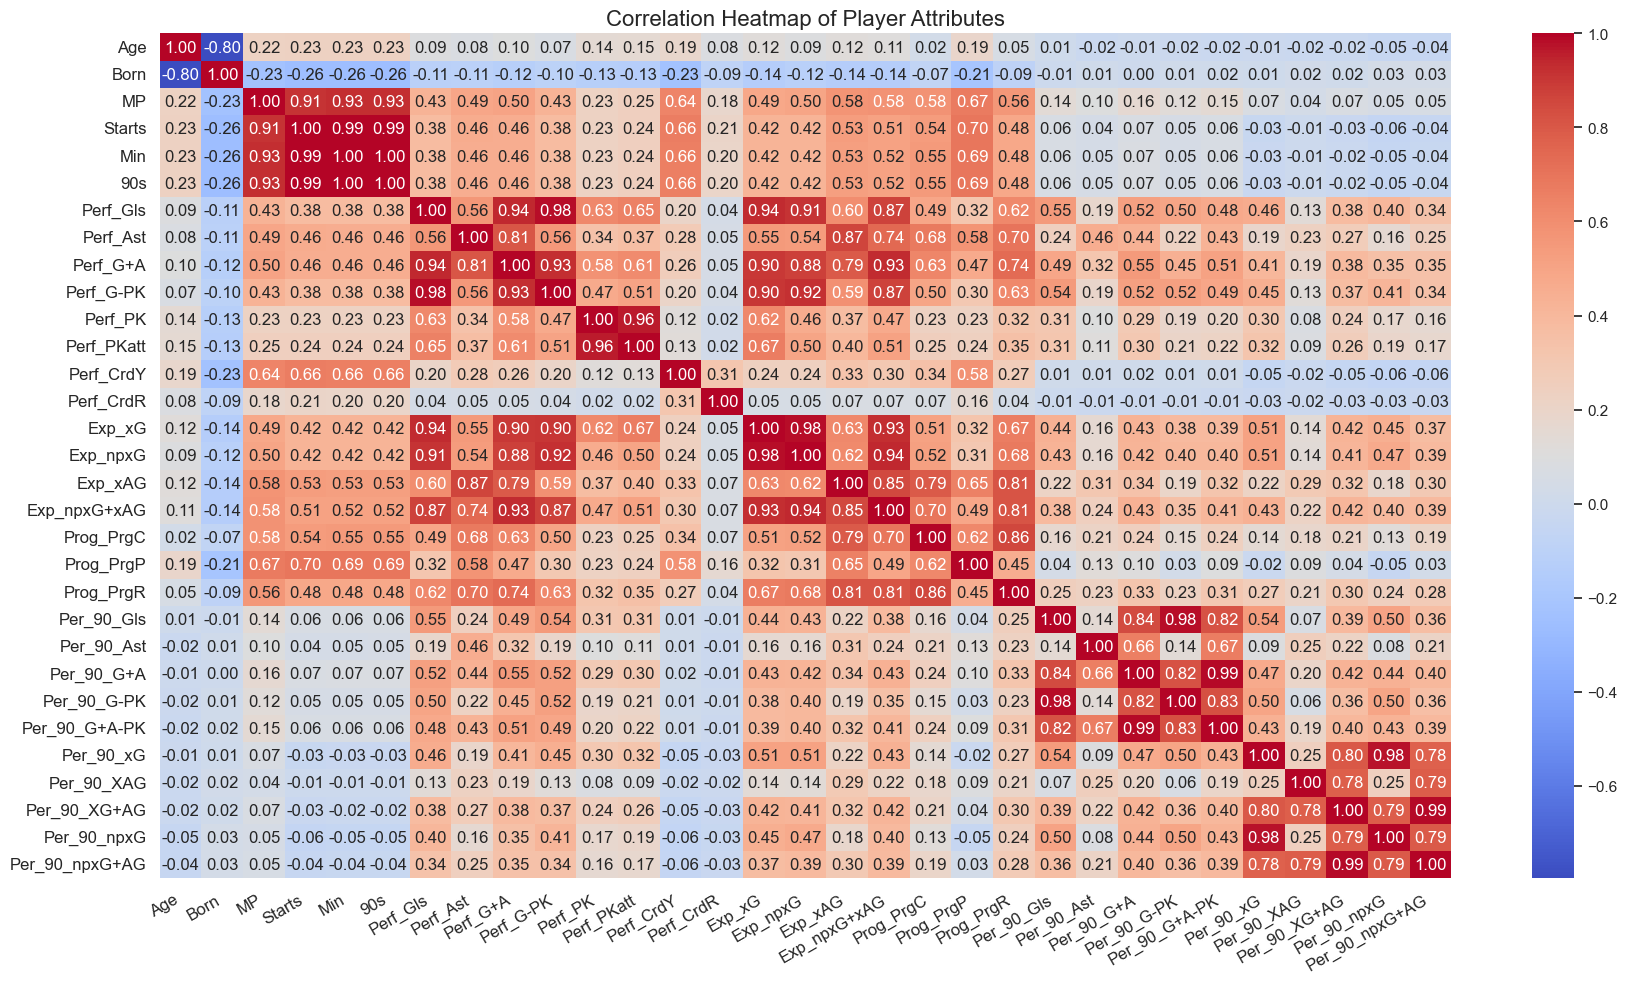

In [1775]:
# Correlation Heatmap of Player Attributes

players_num_cols = players.select_dtypes(include=['number'])
corr = players_num_cols.corr()

plt.figure(figsize=(18, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

plt.title('Correlation Heatmap of Player Attributes', fontsize=16)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust spacing to prevent clipping

# Show the plot
plt.show()

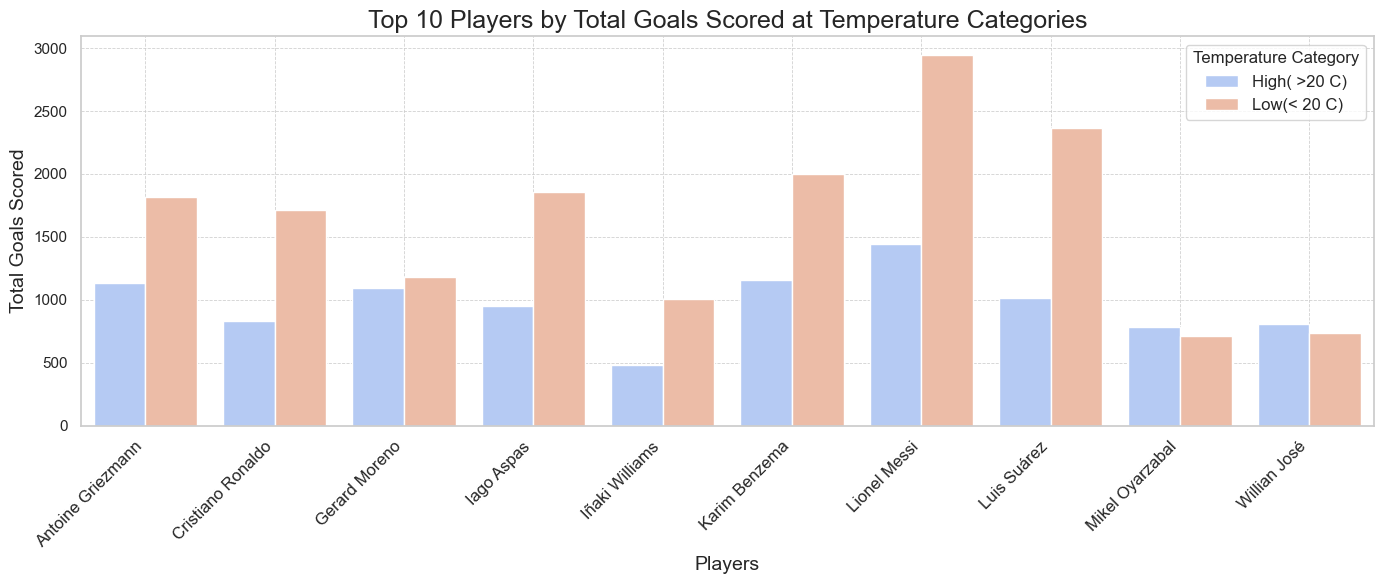

In [1778]:
# Top 10 Players by Total Goals Scored at Temperature Categorie

match_player['temp_category'] = np.where(match_player['max_temp'] < 20, 'Low(< 20 C)', 'High( >20 C)')
player_performance = (match_player.groupby(['Player', 'temp_category']).agg(Total_Goals=('Perf_Gls', 'sum'),Total_Assists=('Perf_Ast', 'sum')).reset_index())

top_players = player_performance.groupby('Player')['Total_Goals'].sum().nlargest(10).index
top_performance = player_performance[player_performance['Player'].isin(top_players)]

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.barplot(data=top_performance, x='Player', y='Total_Goals', hue='temp_category', palette='coolwarm')

plt.title('Top 10 Players by Total Goals Scored at Temperature Categories', fontsize=18)
plt.xlabel('Players', fontsize=14)
plt.ylabel('Total Goals Scored', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

plt.legend(title='Temperature Category', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)
plt.tight_layout()
plt.show()